<a href="https://colab.research.google.com/github/mattthelee/nlp-labs/blob/master/nnnlpLab10/Lab10_colabversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two models for DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [0]:
import pandas as pd
import glob
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf
from tqdm import tqdm
import collections
import time
from nltk.translate.bleu_score import corpus_bleu


# tf.enable_eager_execution()


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

f = glob.glob("/content/gdrive/My Drive/swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]


In [5]:
reduced_df.head()


,act_tag,text
0,qo,"Um, so what do you think? /"
1,^h,"Um, -/"
2,x,<Baby_talking>.
3,sd,"I lived, I lived in Sweden for two years. /"
4,b,Uh-huh. /


Theere are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

In [6]:
act_tag_counts = reduced_df['act_tag'].value_counts()
# Reduce the number of classes by replacing rare labels with the 'other' token
# By reducing the number i help to reduce the class imbalance 
# and also scale the confusion matrix down to a size that allows for interpretation
threshold = 100
for label in act_tag_counts.keys():
    if act_tag_counts[label] < threshold:
        reduced_df.replace(label,'other', inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Baseline BiLSTM Model

To get unique tags. 

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
# Load the onehot encoding dataframe from disk to avoid re-runs incorrectly mapping vectors
import os.path
fname = "one_hot_encoding_dic.pickle"
if os.path.isfile(fname) and False:
    pickle_in = open(fname,"rb")
    one_hot_encoding_dic = pickle.load(pickle_in)
else:
    one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


pickle_out = open(fname,"wb")
pickle.dump(one_hot_encoding_dic, pickle_out)
pickle_out.close()

In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [12]:
MAX_LENGTH = len(max(sentences, key=len))
#MAX_LENGTH = 150
# needs to be an even number of tensorflow reshaping to work
if MAX_LENGTH % 2 == 1:
    MAX_LENGTH += 1
print(MAX_LENGTH)

138


In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.

In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam
#Building the network
numberOfTags = len(reduced_df['act_tag'].value_counts())
embed_dim = 50

model = Sequential()
model.add(Embedding(len(wordvectors)+1, output_dim=embed_dim, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(numberOfTags,activation='softmax' ))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
weightsFilePath ="/content/gdrive/My Drive/weights.best.hdf5"

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 138, 50)           2186600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_1 (Dense)              (None, 58)                7482      
Total params: 2,252,962
Trainable params: 2,252,962
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Save the best weights to a file so we get the model with the best val acc

checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_sentences_X,y_train,epochs=5,batch_size=512,validation_data=(test_sentences_X, y_test), callbacks=[checkpoint],verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 220s 1ms/step - loss: 1.9609 - acc: 0.4981 - val_loss: 1.4567 - val_acc: 0.6168

Epoch 00001: val_acc improved from -inf to 0.61676, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.3088 - acc: 0.6459 - val_loss: 1.2258 - val_acc: 0.6616

Epoch 00002: val_acc improved from 0.61676 to 0.66164, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 3/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.1249 - acc: 0.6880 - val_loss: 1.1511 - val_acc: 0.6711

Epoch 00003: val_acc improved from 0.66164 to 0.67114, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 4/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.0181 - acc: 0.7133 - val_loss: 1.1141 - val_acc: 0.6800

Ep

In [23]:
model.load_weights(weightsFilePath)
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 120s 2ms/step


In [24]:
bfTotal = 0.0
brTotal = 0.0
sdTotal = 0.0
for i,row in enumerate(y_test):
    if np.array_equal(row,one_hot_encoding_dic['br']):
        brTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['bf']):
        bfTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['sd']):
        sdTotal += 1.0
        
print(bfTotal)
print(brTotal)
print(sdTotal)

254.0
52.0
17675.0


In [25]:
for i,key in enumerate(one_hot_encoding_dic.keys()):
    if key == 'br':
        brConfusionMatrixIndex = i
    elif key == 'bf':
        bfConfusionMatrixIndex = i
    elif key == 'sd':
        sdConfusionMatrixIndex = i
print(brConfusionMatrixIndex)
print(bfConfusionMatrixIndex)
print(sdConfusionMatrixIndex)

19
16
45


In [0]:
y_pred = model.predict(test_sentences_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.3269230769230769, bf accuracy: 0.0,sd Accuracy: 0.8264214992927864 
Overall accuracy: 68.10132016743587
The br was most commonly confused with: 
b
qw
+
other
The bf was most commonly confused with: 
qy
%
+
sv
sd


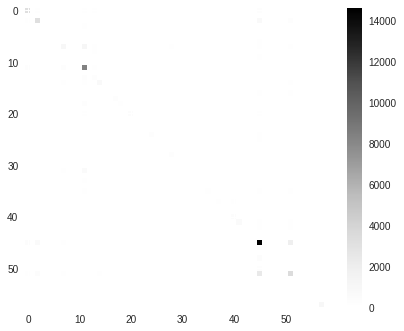

<Figure size 576x396 with 0 Axes>

In [46]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "other" and sd most commonly. 
# I think this is because they are some of the most common classes in the dataset.
# The 0% accuracy for bf was concerning so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly dark with a small number of bright dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")


In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
classBalancedWeightsFilePath = "/content/gdrive/My Drive/classBalancedweights.best.hdf5"

In [48]:

classBalancedCheckpoint = ModelCheckpoint(classBalancedWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(train_sentences_X, y_train, batch_size=512, epochs=5, class_weight = d_class_weights, validation_data=(test_sentences_X, y_test), callbacks=[classBalancedCheckpoint])

Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.6683 - acc: 0.4981 - val_loss: 2.1139 - val_acc: 0.4371

Epoch 00001: val_acc improved from -inf to 0.43710, saving model to /content/gdrive/My Drive/classBalancedweights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.4821 - acc: 0.5014 - val_loss: 2.0329 - val_acc: 0.4474

Epoch 00002: val_acc improved from 0.43710 to 0.44741, saving model to /content/gdrive/My Drive/classBalancedweights.best.hdf5
Epoch 3/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.3375 - acc: 0.5132 - val_loss: 2.0904 - val_acc: 0.4444

Epoch 00003: val_acc did not improve from 0.44741
Epoch 4/5
167704/167704 [==============================] - 214s 1ms/step - loss: 1.2332 - acc: 0.5231 - val_loss: 1.9711 - val_acc: 0.4650

Epoch 00004: val_acc improved from 0.44741 to 0.46505, saving model to /content/gdrive/M

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

##Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each sentence for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current sentence. The left-to-right LSTM output and the one from the reverse direction are concatenated and input to a hidden layer for classification.

Functions for creating weights and biases.

In [0]:
def weights_init(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [0]:
def bias_init(shape):
    return tf.Variable(tf.zeros(shape=shape))


 This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN.
    
      Input(s): 
              input - word_embedings
              filter_size - size of width and height of the Conv kernel
              number_of_channels - in this case it is always 1
              number_of_filters - how many representation of the input utterance are we going to output from this layer 
              strides - how many does kernel move to the side and up/down
              activation - a activation function
              max_pool - boolean value which will trigger a max_pool operation on the output tensor
      Output(s): 
               text_conv layer
    

In [0]:
def text_conv(input, filter_size, number_of_channels, number_of_filters, strides=(1, 1), activation=tf.nn.relu, max_pool=True):
    #print('Conv')
    #print(input)
    #print(filter_size)
    #print('conv end')
    weights = weights_init([filter_size, filter_size, number_of_channels, number_of_filters])
    print(tf.shape(input))
    bias = bias_init([number_of_filters])
    print('bias done')
    layer = tf.nn.conv2d(input, filter=weights, strides=[1, strides[0], strides[1], 1], padding='SAME')
    print('done')
    if activation != None:
        layer = activation(layer)
    print('this works')
    if max_pool:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2 ,1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer

    This method is used to create LSTM layer. And the data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You can create a BiLSTM by modifying this.
    
    Input(s): lstm_cell_unitis - used to define the number of units in a LSTM layer
              number_of_layers - used to define how many of LSTM layers do we want in the network
              batch_size - in this method this information is used to build starting state for the network
              dropout_rate - used to define how many cells in a layer do we want to 'turn off'
              
    Output(s): cell - lstm layer
               init_state - zero vectors used as a starting state for the network

In [0]:
def lstm_layer(lstm_size, number_of_layers, batch_size, dropout_rate):

    def cell(size, dropout_rate=None):
        layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        return tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
    cell = tf.contrib.rnn.MultiRNNCell([cell(lstm_size, dropout_rate) for _ in range(number_of_layers)])
    
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

    Use to transform/reshape conv output to 2d matrix, if it's necessary
    
    Input(s): Layer - text_cnn layer
              batch_size - how many samples do we feed at once
              seq_len - number of time steps
              
    Output(s): reshaped_layer - the layer with new shape
               number_of_elements - this param is used as a in_size for next layer

In [0]:
def flatten(layer, batch_size, seq_len):

    dims = layer.get_shape()
    number_of_elements = dims[2:].num_elements()
    
    reshaped_layer = tf.reshape(layer, [batch_size, int(seq_len/2), number_of_elements])
    return reshaped_layer, number_of_elements

    Output layer for the lstm netowrk
    
    Input(s): lstm_outputs - outputs from the RNN part of the network
              input_size - in this case it is RNN size (number of neuros in RNN layer)
              output_size - number of neuros for the output layer == number of classes
              
    Output(s) - logits, 

In [0]:
def dense_layer(input, in_size, out_size, dropout=False, activation=tf.nn.relu):
  
    weights = weights_init([in_size, out_size])
    bias = bias_init([out_size])
    
    layer = tf.matmul(input, weights) + bias
    
    if activation != None:
        layer = activation(layer)
    
    if dropout:
        layer = tf.nn.dropout(layer, 0.5)
        
    return layer

    Function used to calculate loss and minimize it
    
    Input(s): rnn_out - logits from the fully_connected layer
              targets - targets used to train network
              learning_rate/step_size
    
    
    Output(s): optimizer - optimizer of choice
               loss - calculated loss function

In [0]:
def loss_optimizer(logits, targets, learning_rate ):
    loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    print(loss)
    print(targets)
    print(logits)

    print(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optimizer

To create the model you can use these inputs:     
       
       Input(s): learning_rate/step_size - how fast are we going to find global minima
                  batch_size -  the nuber of samples to feed at once
                  seq_len - the number of timesteps in unrolled RNN
                  vocab_size - the number of nunique words in the vocab
                  embed_size - length of word embed vectors
                  conv_filters - number of filters in output tensor from CNN layer
                  conv_filter_size - height and width of conv kernel
                  number_of_lstm_layers - the number of layers used in the LSTM part of the network
                  lstm_units - the number of neurons/cells in a LSTM layer

In [0]:
class DATagging(object):
    
    def __init__(self, learning_rate=0.001, batch_size=100, seq_len=250, vocab_size=10000, embed_size=300,
                conv_filters=32, conv_filter_size=5, number_of_lstm_layers=1, lstm_units=128):
        
        # Clear tf graph for multiple cell running
        tf.reset_default_graph()
        
        # Create placeholders
        self.inputSentences = tf.placeholder(tf.int32, [batch_size, seq_len], name='inputSentences')
        self.targetLabels= tf.placeholder(tf.float32, [batch_size, numberOfTags], name='targetLabels')    

        
        
        #Embedding layer
        # Initialise word embeddings with random uniform dist
        wordEmbeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size]))
        # Embedding layer
        embeddingLayer = tf.nn.embedding_lookup(wordEmbeddings, self.inputSentences)
        
        # Reshape embedding layer to have a "channel"
        embeddingLayer = tf.expand_dims(embeddingLayer, -1)

        # Conv layer
        number_of_channels = 1
        sentence_embedding = text_conv(embeddingLayer, conv_filter_size,number_of_channels, conv_filters)
        flat_sentence_embedding, size = flatten(sentence_embedding, batch_size, seq_len)
        
        
        lstm_cell, init_state = lstm_layer(lstm_units, number_of_lstm_layers, batch_size, dropout_rate = 0.3)

        
        # BiLSTM layers
        
        (outputs,states) = tf.nn.bidirectional_dynamic_rnn(lstm_cell,
                                                       lstm_cell, 
                                                       flat_sentence_embedding,
                                                       dtype=tf.float32)
        
        
        # Need to reshape the outputs to be include only the last output from the sequence, 
        # but every instance in batch and every lstm output
        (forwardOutputs,backwardOutputs) = outputs
        reshapedForward = tf.squeeze(tf.slice(forwardOutputs, [0,0,0],[-1,1,-1]))
        reshapedBackward = tf.squeeze(tf.slice(backwardOutputs, [0,0,0],[-1,1,-1]))
        shapedOutputs = tf.concat([reshapedForward,reshapedBackward], 1)
        # Hidden layer, with relu activation as we want it to output word embeddings
        denseLayer = dense_layer(shapedOutputs, lstm_units*2, numberOfTags)
        
        #print(denseLayer)
        #print(self.targetLabels)
        self.loss, self.optimizer = loss_optimizer(denseLayer, self.targetLabels, learning_rate)
        
        predictions = tf.math.argmax(denseLayer, axis = 1)
        labels = tf.argmax(self.targetLabels, axis = 1)
        #print(predictions)
        #print(labels)
        
        self.accuracy = tf.metrics.accuracy(labels, predictions)[1]

In [0]:
def shuffleData(x_train,y_train):
    # Returns a shuffled batch of x and y data
    indices = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]
    return x_train_shuffled, y_train_shuffled


In [102]:
batch_size = 256
model2 = DATagging(learning_rate=0.001, 
                     batch_size=batch_size, 
                     seq_len=MAX_LENGTH, 
                     vocab_size=len(wordvectors) + 1, 
                     embed_size=50,
                     conv_filters=32, 
                     conv_filter_size=5, 
                     number_of_lstm_layers=1, 
                     lstm_units=128)

session = tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
epochs = 5
for i in range(epochs):
    epoch_loss = []
    train_accuracy = []
    for ii in tqdm(range(0, len(train_sentences_X), batch_size)):
        x_train_shuffled, y_train_shuffled = shuffleData(train_sentences_X,y_train)
        X_batch = x_train_shuffled[ii:ii+batch_size]
        y_batch = y_train_shuffled[ii:ii+batch_size]
        if len(y_batch) < batch_size:
            # If we are at the end of the data, take  batch from teh end, 
            # this repeats some data but allows us to use all of it
            X_batch = x_train_shuffled[-batch_size:]
            y_batch = y_train_shuffled[-batch_size:]
        
        c, _, a = session.run([model2.loss, model2.optimizer, model2.accuracy], feed_dict={model2.inputSentences:X_batch, 
                                                                                  model2.targetLabels:y_batch})
        print(f"Accuracy: {a}")
        epoch_loss.append(c)
        train_accuracy.append(a)
        
    
    print("Epoch: {}/{}".format(i, epochs), " | Epoch loss: {}".format(np.mean(epoch_loss)), 
          " | Mean train accuracy: {}".format(np.mean(train_accuracy)))
#model2.summary()
#history = model2.fit(train_sentences_X,y_train, epochs=5)

Tensor("Shape:0", shape=(4,), dtype=int32)
bias done
done
this works
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("targetLabels:0", shape=(256, 58), dtype=float32)
Tensor("Relu_1:0", shape=(256, 58), dtype=float32)
0.001




  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 1/656 [00:01<12:17,  1.13s/it]

Accuracy: 0.0390625




  0%|          | 2/656 [00:01<10:32,  1.03it/s]

Accuracy: 0.158203125




  0%|          | 3/656 [00:02<09:19,  1.17it/s]

Accuracy: 0.2096354216337204




  1%|          | 4/656 [00:02<08:21,  1.30it/s]

Accuracy: 0.228515625




  1%|          | 5/656 [00:03<07:37,  1.42it/s]

Accuracy: 0.24062499403953552




  1%|          | 6/656 [00:03<06:57,  1.56it/s]

Accuracy: 0.2545572817325592




  1%|          | 7/656 [00:04<07:00,  1.54it/s]

Accuracy: 0.2589285671710968




  1%|          | 8/656 [00:05<06:54,  1.56it/s]

Accuracy: 0.26416015625




  1%|▏         | 9/656 [00:05<06:33,  1.65it/s]

Accuracy: 0.2717013955116272




  2%|▏         | 10/656 [00:06<06:21,  1.69it/s]

Accuracy: 0.27421873807907104




  2%|▏         | 11/656 [00:06<06:16,  1.71it/s]

Accuracy: 0.2791193127632141




  2%|▏         | 12/656 [00:07<06:20,  1.69it/s]

Accuracy: 0.2835286557674408




  2%|▏         | 13/656 [00:08<06:14,  1.72it/s]

Accuracy: 0.28245192766189575




  2%|▏         | 14/656 [00:08<06:14,  1.71it/s]

Accuracy: 0.2857142984867096




  2%|▏         | 15/656 [00:09<05:59,  1.78it/s]

Accuracy: 0.28723958134651184




  2%|▏         | 16/656 [00:09<05:59,  1.78it/s]

Accuracy: 0.2890625




  3%|▎         | 17/656 [00:10<06:06,  1.75it/s]

Accuracy: 0.28538602590560913




  3%|▎         | 18/656 [00:10<05:57,  1.78it/s]

Accuracy: 0.2821180522441864




  3%|▎         | 19/656 [00:11<05:55,  1.79it/s]

Accuracy: 0.28083881735801697




  3%|▎         | 20/656 [00:11<05:52,  1.80it/s]

Accuracy: 0.2816406190395355




  3%|▎         | 21/656 [00:12<05:45,  1.84it/s]

Accuracy: 0.2808779776096344




  3%|▎         | 22/656 [00:12<05:43,  1.85it/s]

Accuracy: 0.2807173430919647




  4%|▎         | 23/656 [00:13<05:37,  1.88it/s]

Accuracy: 0.2797214686870575




  4%|▎         | 24/656 [00:14<05:39,  1.86it/s]

Accuracy: 0.28076171875




  4%|▍         | 25/656 [00:14<05:44,  1.83it/s]

Accuracy: 0.28171876072883606




  4%|▍         | 26/656 [00:15<05:50,  1.80it/s]

Accuracy: 0.28200119733810425




  4%|▍         | 27/656 [00:15<05:46,  1.81it/s]

Accuracy: 0.28182870149612427




  4%|▍         | 28/656 [00:16<05:48,  1.80it/s]

Accuracy: 0.2827846109867096




  4%|▍         | 29/656 [00:16<05:37,  1.86it/s]

Accuracy: 0.28461745381355286




  5%|▍         | 30/656 [00:17<05:56,  1.76it/s]

Accuracy: 0.2861979305744171




  5%|▍         | 31/656 [00:17<05:47,  1.80it/s]

Accuracy: 0.2865423262119293




  5%|▍         | 32/656 [00:18<05:48,  1.79it/s]

Accuracy: 0.2872314453125




  5%|▌         | 33/656 [00:19<05:58,  1.74it/s]

Accuracy: 0.29012784361839294




  5%|▌         | 34/656 [00:19<05:59,  1.73it/s]

Accuracy: 0.2904411852359772




  5%|▌         | 35/656 [00:20<05:53,  1.76it/s]

Accuracy: 0.2912946343421936




  5%|▌         | 36/656 [00:20<05:44,  1.80it/s]

Accuracy: 0.2944878339767456




  6%|▌         | 37/656 [00:21<05:43,  1.80it/s]

Accuracy: 0.2961359918117523




  6%|▌         | 38/656 [00:21<05:28,  1.88it/s]

Accuracy: 0.29841694235801697




  6%|▌         | 39/656 [00:22<05:31,  1.86it/s]

Accuracy: 0.3000801205635071




  6%|▌         | 40/656 [00:22<05:38,  1.82it/s]

Accuracy: 0.302734375




  6%|▋         | 41/656 [00:23<05:35,  1.83it/s]

Accuracy: 0.30554497241973877




  6%|▋         | 42/656 [00:24<05:42,  1.79it/s]

Accuracy: 0.306733638048172




  7%|▋         | 43/656 [00:24<05:41,  1.80it/s]

Accuracy: 0.30804869532585144




  7%|▋         | 44/656 [00:25<05:43,  1.78it/s]

Accuracy: 0.3099254369735718




  7%|▋         | 45/656 [00:25<05:33,  1.83it/s]

Accuracy: 0.31128472089767456




  7%|▋         | 46/656 [00:26<05:35,  1.82it/s]

Accuracy: 0.31275475025177




  7%|▋         | 47/656 [00:26<05:44,  1.77it/s]

Accuracy: 0.314245343208313




  7%|▋         | 48/656 [00:27<05:44,  1.77it/s]

Accuracy: 0.3164876401424408




  7%|▋         | 49/656 [00:28<05:47,  1.75it/s]

Accuracy: 0.31903699040412903




  8%|▊         | 50/656 [00:28<05:32,  1.82it/s]

Accuracy: 0.3219531178474426




  8%|▊         | 51/656 [00:29<05:29,  1.84it/s]

Accuracy: 0.3228400647640228




  8%|▊         | 52/656 [00:29<05:19,  1.89it/s]

Accuracy: 0.3242938816547394




  8%|▊         | 53/656 [00:30<05:14,  1.92it/s]

Accuracy: 0.32679834961891174




  8%|▊         | 54/656 [00:30<05:34,  1.80it/s]

Accuracy: 0.32870370149612427




  8%|▊         | 55/656 [00:31<05:33,  1.80it/s]

Accuracy: 0.3304687440395355




  9%|▊         | 56/656 [00:31<05:37,  1.78it/s]

Accuracy: 0.3314732015132904




  9%|▊         | 57/656 [00:32<05:34,  1.79it/s]

Accuracy: 0.3333333432674408




  9%|▉         | 58/656 [00:32<05:22,  1.85it/s]

Accuracy: 0.3358701467514038




  9%|▉         | 59/656 [00:33<05:46,  1.72it/s]

Accuracy: 0.33699682354927063




  9%|▉         | 60/656 [00:34<05:39,  1.76it/s]

Accuracy: 0.33873698115348816




  9%|▉         | 61/656 [00:34<05:22,  1.85it/s]

Accuracy: 0.3406762182712555




  9%|▉         | 62/656 [00:35<05:17,  1.87it/s]

Accuracy: 0.3419228792190552




 10%|▉         | 63/656 [00:35<05:16,  1.87it/s]

Accuracy: 0.3430679440498352




 10%|▉         | 64/656 [00:36<05:07,  1.92it/s]

Accuracy: 0.34466552734375




 10%|▉         | 65/656 [00:36<05:21,  1.84it/s]

Accuracy: 0.3456129729747772




 10%|█         | 66/656 [00:37<05:34,  1.76it/s]

Accuracy: 0.34741950035095215




 10%|█         | 67/656 [00:37<05:19,  1.84it/s]

Accuracy: 0.3495219349861145




 10%|█         | 68/656 [00:38<05:14,  1.87it/s]

Accuracy: 0.35133272409439087




 11%|█         | 69/656 [00:38<05:12,  1.88it/s]

Accuracy: 0.35292118787765503




 11%|█         | 70/656 [00:39<05:18,  1.84it/s]

Accuracy: 0.3546316921710968




 11%|█         | 71/656 [00:39<05:15,  1.85it/s]

Accuracy: 0.3565691113471985




 11%|█         | 72/656 [00:40<05:32,  1.76it/s]

Accuracy: 0.3589952290058136




 11%|█         | 73/656 [00:41<05:12,  1.87it/s]

Accuracy: 0.36055222153663635




 11%|█▏        | 74/656 [00:41<05:16,  1.84it/s]

Accuracy: 0.3621199429035187




 11%|█▏        | 75/656 [00:42<05:22,  1.80it/s]

Accuracy: 0.3636458218097687




 12%|█▏        | 76/656 [00:42<05:20,  1.81it/s]

Accuracy: 0.36538857221603394




 12%|█▏        | 77/656 [00:43<05:16,  1.83it/s]

Accuracy: 0.36703529953956604




 12%|█▏        | 78/656 [00:43<05:20,  1.80it/s]

Accuracy: 0.36768829822540283




 12%|█▏        | 79/656 [00:44<05:24,  1.78it/s]

Accuracy: 0.36862143874168396




 12%|█▏        | 80/656 [00:45<05:43,  1.68it/s]

Accuracy: 0.36982423067092896




 12%|█▏        | 81/656 [00:45<05:41,  1.68it/s]

Accuracy: 0.37109375




 12%|█▎        | 82/656 [00:46<05:33,  1.72it/s]

Accuracy: 0.3724275827407837




 13%|█▎        | 83/656 [00:46<05:25,  1.76it/s]

Accuracy: 0.37339985370635986




 13%|█▎        | 84/656 [00:47<05:15,  1.81it/s]

Accuracy: 0.3743024468421936




 13%|█▎        | 85/656 [00:47<05:09,  1.85it/s]

Accuracy: 0.3750459551811218




 13%|█▎        | 86/656 [00:48<05:10,  1.84it/s]

Accuracy: 0.37590843439102173




 13%|█▎        | 87/656 [00:48<05:13,  1.81it/s]

Accuracy: 0.3767510652542114




 13%|█▎        | 88/656 [00:49<05:15,  1.80it/s]

Accuracy: 0.3773082494735718




 14%|█▎        | 89/656 [00:50<05:18,  1.78it/s]

Accuracy: 0.37737008929252625




 14%|█▎        | 90/656 [00:50<05:09,  1.83it/s]

Accuracy: 0.37795138359069824




 14%|█▍        | 91/656 [00:51<05:11,  1.82it/s]

Accuracy: 0.3785199224948883




 14%|█▍        | 92/656 [00:51<05:07,  1.84it/s]

Accuracy: 0.37886378169059753




 14%|█▍        | 93/656 [00:52<05:26,  1.73it/s]

Accuracy: 0.37966230511665344




 14%|█▍        | 94/656 [00:52<05:19,  1.76it/s]

Accuracy: 0.3814411461353302




 14%|█▍        | 95/656 [00:53<05:28,  1.71it/s]

Accuracy: 0.38236019015312195




 15%|█▍        | 96/656 [00:53<05:12,  1.79it/s]

Accuracy: 0.3828531801700592




 15%|█▍        | 97/656 [00:54<05:19,  1.75it/s]

Accuracy: 0.3837387263774872




 15%|█▍        | 98/656 [00:55<05:18,  1.75it/s]

Accuracy: 0.3842075765132904




 15%|█▌        | 99/656 [00:55<05:20,  1.74it/s]

Accuracy: 0.3845486044883728




 15%|█▌        | 100/656 [00:56<05:22,  1.72it/s]

Accuracy: 0.38550782203674316




 15%|█▌        | 101/656 [00:56<05:25,  1.71it/s]

Accuracy: 0.38590654730796814




 16%|█▌        | 102/656 [00:57<05:31,  1.67it/s]

Accuracy: 0.38694852590560913




 16%|█▌        | 103/656 [00:58<05:25,  1.70it/s]

Accuracy: 0.3872497081756592




 16%|█▌        | 104/656 [00:58<05:22,  1.71it/s]

Accuracy: 0.3872821629047394




 16%|█▌        | 105/656 [00:59<05:16,  1.74it/s]

Accuracy: 0.38805803656578064




 16%|█▌        | 106/656 [00:59<05:14,  1.75it/s]

Accuracy: 0.38856130838394165




 16%|█▋        | 107/656 [01:00<05:28,  1.67it/s]

Accuracy: 0.3891647160053253




 16%|█▋        | 108/656 [01:01<05:23,  1.69it/s]

Accuracy: 0.3900824785232544




 17%|█▋        | 109/656 [01:01<05:23,  1.69it/s]

Accuracy: 0.39058917760849




 17%|█▋        | 110/656 [01:02<05:10,  1.76it/s]

Accuracy: 0.39161932468414307




 17%|█▋        | 111/656 [01:02<05:19,  1.71it/s]

Accuracy: 0.3925253450870514




 17%|█▋        | 112/656 [01:03<05:16,  1.72it/s]

Accuracy: 0.3931361734867096




 17%|█▋        | 113/656 [01:03<05:01,  1.80it/s]

Accuracy: 0.3937707543373108




 17%|█▋        | 114/656 [01:04<05:00,  1.80it/s]

Accuracy: 0.39449697732925415




 18%|█▊        | 115/656 [01:04<05:02,  1.79it/s]

Accuracy: 0.39527854323387146




 18%|█▊        | 116/656 [01:05<05:04,  1.78it/s]

Accuracy: 0.39594557881355286




 18%|█▊        | 117/656 [01:06<05:03,  1.78it/s]

Accuracy: 0.3969684839248657




 18%|█▊        | 118/656 [01:06<05:01,  1.79it/s]

Accuracy: 0.39727887511253357




 18%|█▊        | 119/656 [01:07<04:50,  1.85it/s]

Accuracy: 0.39741989970207214




 18%|█▊        | 120/656 [01:07<05:05,  1.76it/s]

Accuracy: 0.3978515565395355




 18%|█▊        | 121/656 [01:08<05:10,  1.72it/s]

Accuracy: 0.3987926244735718




 19%|█▊        | 122/656 [01:09<05:15,  1.70it/s]

Accuracy: 0.39930200576782227




 19%|█▉        | 123/656 [01:09<05:10,  1.72it/s]

Accuracy: 0.3994219899177551




 19%|█▉        | 124/656 [01:10<05:13,  1.70it/s]

Accuracy: 0.3998550772666931




 19%|█▉        | 125/656 [01:10<05:00,  1.77it/s]

Accuracy: 0.4000625014305115




 19%|█▉        | 126/656 [01:11<05:05,  1.73it/s]

Accuracy: 0.4009796679019928




 19%|█▉        | 127/656 [01:11<04:56,  1.79it/s]

Accuracy: 0.4015747904777527




 20%|█▉        | 128/656 [01:12<04:46,  1.84it/s]

Accuracy: 0.4022216796875




 20%|█▉        | 129/656 [01:12<04:56,  1.78it/s]

Accuracy: 0.40264657139778137




 20%|█▉        | 130/656 [01:13<05:07,  1.71it/s]

Accuracy: 0.4032151401042938




 20%|█▉        | 131/656 [01:14<04:53,  1.79it/s]

Accuracy: 0.4039837718009949




 20%|██        | 132/656 [01:14<04:44,  1.84it/s]

Accuracy: 0.404296875




 20%|██        | 133/656 [01:15<04:48,  1.81it/s]

Accuracy: 0.40486958622932434




 20%|██        | 134/656 [01:15<04:53,  1.78it/s]

Accuracy: 0.4053463041782379




 21%|██        | 135/656 [01:16<04:36,  1.88it/s]

Accuracy: 0.4059317111968994




 21%|██        | 136/656 [01:16<04:39,  1.86it/s]

Accuracy: 0.4064510464668274




 21%|██        | 137/656 [01:17<04:39,  1.86it/s]

Accuracy: 0.40693432092666626




 21%|██        | 138/656 [01:17<04:50,  1.79it/s]

Accuracy: 0.40741056203842163




 21%|██        | 139/656 [01:18<04:35,  1.87it/s]

Accuracy: 0.4081328809261322




 21%|██▏       | 140/656 [01:18<04:37,  1.86it/s]

Accuracy: 0.40884485840797424




 21%|██▏       | 141/656 [01:19<04:39,  1.84it/s]

Accuracy: 0.4089926779270172




 22%|██▏       | 142/656 [01:19<04:34,  1.87it/s]

Accuracy: 0.40946853160858154




 22%|██▏       | 143/656 [01:20<04:37,  1.85it/s]

Accuracy: 0.41034746170043945




 22%|██▏       | 144/656 [01:21<04:43,  1.81it/s]

Accuracy: 0.4109971821308136




 22%|██▏       | 145/656 [01:21<04:47,  1.78it/s]

Accuracy: 0.41150322556495667




 22%|██▏       | 146/656 [01:22<04:43,  1.80it/s]

Accuracy: 0.4118685722351074




 22%|██▏       | 147/656 [01:22<04:41,  1.81it/s]

Accuracy: 0.41236183047294617




 23%|██▎       | 148/656 [01:23<04:46,  1.77it/s]

Accuracy: 0.4132706820964813




 23%|██▎       | 149/656 [01:23<04:43,  1.79it/s]

Accuracy: 0.41366925835609436




 23%|██▎       | 150/656 [01:24<04:45,  1.77it/s]

Accuracy: 0.4142708480358124




 23%|██▎       | 151/656 [01:25<04:42,  1.79it/s]

Accuracy: 0.4147609770298004




 23%|██▎       | 152/656 [01:25<04:43,  1.78it/s]

Accuracy: 0.41516757011413574




 23%|██▎       | 153/656 [01:26<04:50,  1.73it/s]

Accuracy: 0.41551777720451355




 23%|██▎       | 154/656 [01:26<04:39,  1.80it/s]

Accuracy: 0.4156351387500763




 24%|██▎       | 155/656 [01:27<04:47,  1.74it/s]

Accuracy: 0.41625502705574036




 24%|██▍       | 156/656 [01:27<04:52,  1.71it/s]

Accuracy: 0.4165915548801422




 24%|██▍       | 157/656 [01:28<04:41,  1.77it/s]

Accuracy: 0.4168988764286041




 24%|██▍       | 158/656 [01:29<04:44,  1.75it/s]

Accuracy: 0.4170787036418915




 24%|██▍       | 159/656 [01:29<04:46,  1.74it/s]

Accuracy: 0.417354553937912




 24%|██▍       | 160/656 [01:30<04:46,  1.73it/s]

Accuracy: 0.4180664122104645




 25%|██▍       | 161/656 [01:30<04:36,  1.79it/s]

Accuracy: 0.41857531666755676




 25%|██▍       | 162/656 [01:31<04:33,  1.81it/s]

Accuracy: 0.41902971267700195




 25%|██▍       | 163/656 [01:31<04:30,  1.83it/s]

Accuracy: 0.4195983409881592




 25%|██▌       | 164/656 [01:32<04:26,  1.85it/s]

Accuracy: 0.42008861899375916




 25%|██▌       | 165/656 [01:32<04:33,  1.80it/s]

Accuracy: 0.4206676185131073




 25%|██▌       | 166/656 [01:33<04:29,  1.82it/s]

Accuracy: 0.4212867021560669




 25%|██▌       | 167/656 [01:33<04:18,  1.89it/s]

Accuracy: 0.421781450510025




 26%|██▌       | 168/656 [01:34<04:14,  1.92it/s]

Accuracy: 0.4221540093421936




 26%|██▌       | 169/656 [01:34<04:12,  1.93it/s]

Accuracy: 0.42286890745162964




 26%|██▌       | 170/656 [01:35<04:04,  1.99it/s]

Accuracy: 0.42357537150382996




 26%|██▌       | 171/656 [01:35<04:01,  2.01it/s]

Accuracy: 0.42429640889167786




 26%|██▌       | 172/656 [01:36<03:51,  2.09it/s]

Accuracy: 0.4246911406517029




 26%|██▋       | 173/656 [01:36<03:54,  2.06it/s]

Accuracy: 0.4251941740512848




 27%|██▋       | 174/656 [01:37<03:53,  2.07it/s]

Accuracy: 0.4254893958568573




 27%|██▋       | 175/656 [01:37<03:56,  2.03it/s]

Accuracy: 0.42627233266830444




 27%|██▋       | 176/656 [01:38<03:56,  2.03it/s]

Accuracy: 0.426513671875




 27%|██▋       | 177/656 [01:38<03:43,  2.15it/s]

Accuracy: 0.426928848028183




 27%|██▋       | 178/656 [01:39<03:36,  2.21it/s]

Accuracy: 0.42709797620773315




 27%|██▋       | 179/656 [01:39<03:39,  2.18it/s]

Accuracy: 0.4272870123386383




 27%|██▋       | 180/656 [01:40<03:40,  2.16it/s]

Accuracy: 0.42760416865348816




 28%|██▊       | 181/656 [01:40<03:44,  2.12it/s]

Accuracy: 0.4280688762664795




 28%|██▊       | 182/656 [01:41<03:59,  1.98it/s]

Accuracy: 0.4285714328289032




 28%|██▊       | 183/656 [01:41<03:57,  1.99it/s]

Accuracy: 0.4292179048061371




 28%|██▊       | 184/656 [01:42<03:50,  2.05it/s]

Accuracy: 0.429560124874115




 28%|██▊       | 185/656 [01:42<03:53,  2.02it/s]

Accuracy: 0.43021535873413086




 28%|██▊       | 186/656 [01:43<03:51,  2.03it/s]

Accuracy: 0.4309895932674408




 29%|██▊       | 187/656 [01:43<03:52,  2.02it/s]

Accuracy: 0.43127506971359253




 29%|██▊       | 188/656 [01:44<03:51,  2.03it/s]

Accuracy: 0.43157827854156494




 29%|██▉       | 189/656 [01:44<03:52,  2.01it/s]

Accuracy: 0.4320436418056488




 29%|██▉       | 190/656 [01:45<03:42,  2.09it/s]

Accuracy: 0.4325657784938812




 29%|██▉       | 191/656 [01:45<03:38,  2.13it/s]

Accuracy: 0.43295976519584656




 29%|██▉       | 192/656 [01:46<03:47,  2.04it/s]

Accuracy: 0.43341064453125




 29%|██▉       | 193/656 [01:46<03:23,  2.28it/s]

Accuracy: 0.43367472290992737




 30%|██▉       | 194/656 [01:46<03:05,  2.49it/s]

Accuracy: 0.4341978132724762




 30%|██▉       | 195/656 [01:47<02:56,  2.60it/s]

Accuracy: 0.4346955120563507




 30%|██▉       | 196/656 [01:47<02:47,  2.75it/s]

Accuracy: 0.43494898080825806




 30%|███       | 197/656 [01:47<02:40,  2.86it/s]

Accuracy: 0.4355567991733551




 30%|███       | 198/656 [01:48<02:39,  2.87it/s]

Accuracy: 0.4357638955116272




 30%|███       | 199/656 [01:48<02:34,  2.95it/s]

Accuracy: 0.43636149168014526




 30%|███       | 200/656 [01:48<02:31,  3.00it/s]

Accuracy: 0.4368359446525574




 31%|███       | 201/656 [01:48<02:29,  3.05it/s]

Accuracy: 0.43728622794151306




 31%|███       | 202/656 [01:49<02:27,  3.07it/s]

Accuracy: 0.43792542815208435




 31%|███       | 203/656 [01:49<02:25,  3.12it/s]

Accuracy: 0.4383081793785095




 31%|███       | 204/656 [01:49<02:24,  3.13it/s]

Accuracy: 0.4387446343898773




 31%|███▏      | 205/656 [01:50<02:26,  3.09it/s]

Accuracy: 0.43921494483947754




 31%|███▏      | 206/656 [01:50<02:24,  3.11it/s]

Accuracy: 0.4397186040878296




 32%|███▏      | 207/656 [01:50<02:24,  3.12it/s]

Accuracy: 0.43999093770980835




 32%|███▏      | 208/656 [01:51<02:26,  3.05it/s]

Accuracy: 0.4403921365737915




 32%|███▏      | 209/656 [01:51<02:25,  3.07it/s]

Accuracy: 0.4407520890235901




 32%|███▏      | 210/656 [01:51<02:24,  3.10it/s]

Accuracy: 0.44135046005249023




 32%|███▏      | 211/656 [01:52<02:22,  3.12it/s]

Accuracy: 0.44168394804000854




 32%|███▏      | 212/656 [01:52<02:22,  3.12it/s]

Accuracy: 0.44221699237823486




 32%|███▏      | 213/656 [01:52<02:21,  3.12it/s]

Accuracy: 0.4426349699497223




 33%|███▎      | 214/656 [01:53<02:20,  3.14it/s]

Accuracy: 0.443195104598999




 33%|███▎      | 215/656 [01:53<02:21,  3.11it/s]

Accuracy: 0.4436591565608978




 33%|███▎      | 216/656 [01:53<02:20,  3.13it/s]

Accuracy: 0.44424551725387573




 33%|███▎      | 217/656 [01:54<02:19,  3.14it/s]

Accuracy: 0.44466444849967957




 33%|███▎      | 218/656 [01:54<02:21,  3.09it/s]

Accuracy: 0.4452229142189026




 33%|███▎      | 219/656 [01:54<02:20,  3.11it/s]

Accuracy: 0.44540169835090637




 34%|███▎      | 220/656 [01:55<02:19,  3.12it/s]

Accuracy: 0.4458451569080353




 34%|███▎      | 221/656 [01:55<02:22,  3.04it/s]

Accuracy: 0.4460195004940033




 34%|███▍      | 222/656 [01:55<02:21,  3.07it/s]

Accuracy: 0.4460691213607788




 34%|███▍      | 223/656 [01:56<02:19,  3.10it/s]

Accuracy: 0.44643357396125793




 34%|███▍      | 224/656 [01:56<02:18,  3.12it/s]

Accuracy: 0.4466204047203064




 34%|███▍      | 225/656 [01:56<02:17,  3.13it/s]

Accuracy: 0.4469791650772095




 34%|███▍      | 226/656 [01:57<02:18,  3.10it/s]

Accuracy: 0.44743847846984863




 35%|███▍      | 227/656 [01:57<02:18,  3.10it/s]

Accuracy: 0.4478593170642853




 35%|███▍      | 228/656 [01:57<02:20,  3.05it/s]

Accuracy: 0.44827646017074585




 35%|███▍      | 229/656 [01:58<02:19,  3.06it/s]

Accuracy: 0.44851937890052795




 35%|███▌      | 230/656 [01:58<02:17,  3.10it/s]

Accuracy: 0.44896399974823




 35%|███▌      | 231/656 [01:58<02:18,  3.06it/s]

Accuracy: 0.4495738744735718




 35%|███▌      | 232/656 [01:58<02:17,  3.07it/s]

Accuracy: 0.45004376769065857




 36%|███▌      | 233/656 [01:59<02:18,  3.06it/s]

Accuracy: 0.45054319500923157




 36%|███▌      | 234/656 [01:59<02:20,  3.01it/s]

Accuracy: 0.45103833079338074




 36%|███▌      | 235/656 [01:59<02:17,  3.05it/s]

Accuracy: 0.45161235332489014




 36%|███▌      | 236/656 [02:00<02:17,  3.06it/s]

Accuracy: 0.45206567645072937




 36%|███▌      | 237/656 [02:00<02:19,  2.99it/s]

Accuracy: 0.4525645971298218




 36%|███▋      | 238/656 [02:00<02:17,  3.05it/s]

Accuracy: 0.4529280364513397




 36%|███▋      | 239/656 [02:01<02:15,  3.07it/s]

Accuracy: 0.4534028470516205




 37%|███▋      | 240/656 [02:01<02:14,  3.09it/s]

Accuracy: 0.4537597596645355




 37%|███▋      | 241/656 [02:01<02:13,  3.11it/s]

Accuracy: 0.45421096682548523




 37%|███▋      | 242/656 [02:02<02:12,  3.13it/s]

Accuracy: 0.45469072461128235




 37%|███▋      | 243/656 [02:02<02:12,  3.12it/s]

Accuracy: 0.4548932611942291




 37%|███▋      | 244/656 [02:02<02:12,  3.12it/s]

Accuracy: 0.45533427596092224




 37%|███▋      | 245/656 [02:03<02:12,  3.11it/s]

Accuracy: 0.4557238519191742




 38%|███▊      | 246/656 [02:03<02:10,  3.13it/s]

Accuracy: 0.45599910616874695




 38%|███▊      | 247/656 [02:03<02:13,  3.06it/s]

Accuracy: 0.45657262206077576




 38%|███▊      | 248/656 [02:04<02:11,  3.10it/s]

Accuracy: 0.45722025632858276




 38%|███▊      | 249/656 [02:04<02:10,  3.11it/s]

Accuracy: 0.45754894614219666




 38%|███▊      | 250/656 [02:04<02:10,  3.12it/s]

Accuracy: 0.4579218626022339




 38%|███▊      | 251/656 [02:05<02:09,  3.13it/s]

Accuracy: 0.4583851993083954




 38%|███▊      | 252/656 [02:05<02:08,  3.14it/s]

Accuracy: 0.4588448703289032




 39%|███▊      | 253/656 [02:05<02:08,  3.15it/s]

Accuracy: 0.45920825004577637




 39%|███▊      | 254/656 [02:06<02:09,  3.11it/s]

Accuracy: 0.4595995247364044




 39%|███▉      | 255/656 [02:06<02:08,  3.12it/s]

Accuracy: 0.4600183963775635




 39%|███▉      | 256/656 [02:06<02:08,  3.12it/s]

Accuracy: 0.460601806640625




 39%|███▉      | 257/656 [02:07<02:11,  3.04it/s]

Accuracy: 0.46116548776626587




 39%|███▉      | 258/656 [02:07<02:09,  3.06it/s]

Accuracy: 0.46145227551460266




 39%|███▉      | 259/656 [02:07<02:08,  3.10it/s]

Accuracy: 0.46197816729545593




 40%|███▉      | 260/656 [02:08<02:10,  3.04it/s]

Accuracy: 0.46219950914382935




 40%|███▉      | 261/656 [02:08<02:08,  3.08it/s]

Accuracy: 0.4625089764595032




 40%|███▉      | 262/656 [02:08<02:06,  3.11it/s]

Accuracy: 0.4627862572669983




 40%|████      | 263/656 [02:08<02:05,  3.13it/s]

Accuracy: 0.46320995688438416




 40%|████      | 264/656 [02:09<02:04,  3.14it/s]

Accuracy: 0.4637044370174408




 40%|████      | 265/656 [02:09<02:03,  3.16it/s]

Accuracy: 0.46403300762176514




 41%|████      | 266/656 [02:09<02:04,  3.14it/s]

Accuracy: 0.4646087884902954




 41%|████      | 267/656 [02:10<02:04,  3.13it/s]

Accuracy: 0.4651948809623718




 41%|████      | 268/656 [02:10<02:04,  3.13it/s]

Accuracy: 0.4654850661754608




 41%|████      | 269/656 [02:10<02:03,  3.14it/s]

Accuracy: 0.4657876491546631




 41%|████      | 270/656 [02:11<02:03,  3.11it/s]

Accuracy: 0.46616029739379883




 41%|████▏     | 271/656 [02:11<02:03,  3.12it/s]

Accuracy: 0.466501384973526




 41%|████▏     | 272/656 [02:11<02:04,  3.08it/s]

Accuracy: 0.4668543338775635




 42%|████▏     | 273/656 [02:12<02:08,  2.98it/s]

Accuracy: 0.46757668256759644




 42%|████▏     | 274/656 [02:12<02:06,  3.03it/s]

Accuracy: 0.46796590089797974




 42%|████▏     | 275/656 [02:12<02:04,  3.06it/s]

Accuracy: 0.46845170855522156




 42%|████▏     | 276/656 [02:13<02:03,  3.09it/s]

Accuracy: 0.4687216877937317




 42%|████▏     | 277/656 [02:13<02:02,  3.10it/s]

Accuracy: 0.46890512108802795




 42%|████▏     | 278/656 [02:13<02:01,  3.11it/s]

Accuracy: 0.46935421228408813




 43%|████▎     | 279/656 [02:14<02:00,  3.13it/s]

Accuracy: 0.4698280692100525




 43%|████▎     | 280/656 [02:14<02:00,  3.11it/s]

Accuracy: 0.4702427387237549




 43%|████▎     | 281/656 [02:14<01:59,  3.13it/s]

Accuracy: 0.47080737352371216




 43%|████▎     | 282/656 [02:15<01:59,  3.13it/s]

Accuracy: 0.47117409110069275




 43%|████▎     | 283/656 [02:15<01:59,  3.11it/s]

Accuracy: 0.4713587760925293




 43%|████▎     | 284/656 [02:15<01:58,  3.14it/s]

Accuracy: 0.47150087356567383




 43%|████▎     | 285/656 [02:16<01:58,  3.14it/s]

Accuracy: 0.47201207280158997




 44%|████▎     | 286/656 [02:16<02:00,  3.08it/s]

Accuracy: 0.4724923372268677




 44%|████▍     | 287/656 [02:16<01:58,  3.10it/s]

Accuracy: 0.47283318638801575




 44%|████▍     | 288/656 [02:17<01:58,  3.11it/s]

Accuracy: 0.4730631411075592




 44%|████▍     | 289/656 [02:17<01:58,  3.11it/s]

Accuracy: 0.4732780158519745




 44%|████▍     | 290/656 [02:17<01:57,  3.10it/s]

Accuracy: 0.47347790002822876




 44%|████▍     | 291/656 [02:18<01:56,  3.12it/s]

Accuracy: 0.4736495912075043




 45%|████▍     | 292/656 [02:18<01:56,  3.13it/s]

Accuracy: 0.47402074933052063




 45%|████▍     | 293/656 [02:18<01:57,  3.10it/s]

Accuracy: 0.47425606846809387




 45%|████▍     | 294/656 [02:18<01:56,  3.11it/s]

Accuracy: 0.4745429456233978




 45%|████▍     | 295/656 [02:19<01:55,  3.13it/s]

Accuracy: 0.4748278558254242




 45%|████▌     | 296/656 [02:19<01:57,  3.06it/s]

Accuracy: 0.47516363859176636




 45%|████▌     | 297/656 [02:19<01:56,  3.09it/s]

Accuracy: 0.4755234718322754




 45%|████▌     | 298/656 [02:20<01:55,  3.11it/s]

Accuracy: 0.47573667764663696




 46%|████▌     | 299/656 [02:20<01:56,  3.07it/s]

Accuracy: 0.47602686285972595




 46%|████▌     | 300/656 [02:20<01:54,  3.10it/s]

Accuracy: 0.4764973819255829




 46%|████▌     | 301/656 [02:21<01:54,  3.11it/s]

Accuracy: 0.4767571687698364




 46%|████▌     | 302/656 [02:21<01:53,  3.11it/s]

Accuracy: 0.47696346044540405




 46%|████▌     | 303/656 [02:21<01:53,  3.12it/s]

Accuracy: 0.47732311487197876




 46%|████▋     | 304/656 [02:22<01:52,  3.13it/s]

Accuracy: 0.4775005280971527




 46%|████▋     | 305/656 [02:22<01:51,  3.14it/s]

Accuracy: 0.4779585003852844




 47%|████▋     | 306/656 [02:22<01:52,  3.10it/s]

Accuracy: 0.478158175945282




 47%|████▋     | 307/656 [02:23<01:52,  3.10it/s]

Accuracy: 0.478280246257782




 47%|████▋     | 308/656 [02:23<01:51,  3.11it/s]

Accuracy: 0.47849026322364807




 47%|████▋     | 309/656 [02:23<01:54,  3.04it/s]

Accuracy: 0.4789138436317444




 47%|████▋     | 310/656 [02:24<01:52,  3.07it/s]

Accuracy: 0.47928428649902344




 47%|████▋     | 311/656 [02:24<01:51,  3.10it/s]

Accuracy: 0.47970256209373474




 48%|████▊     | 312/656 [02:24<01:52,  3.06it/s]

Accuracy: 0.47995543479919434




 48%|████▊     | 313/656 [02:25<01:52,  3.05it/s]

Accuracy: 0.4800693988800049




 48%|████▊     | 314/656 [02:25<01:50,  3.09it/s]

Accuracy: 0.48028215765953064




 48%|████▊     | 315/656 [02:25<01:50,  3.09it/s]

Accuracy: 0.48046875




 48%|████▊     | 316/656 [02:26<01:49,  3.12it/s]

Accuracy: 0.480851948261261




 48%|████▊     | 317/656 [02:26<01:48,  3.13it/s]

Accuracy: 0.48122042417526245




 48%|████▊     | 318/656 [02:26<01:48,  3.13it/s]

Accuracy: 0.48136547207832336




 49%|████▊     | 319/656 [02:27<01:48,  3.11it/s]

Accuracy: 0.48164430260658264




 49%|████▉     | 320/656 [02:27<01:47,  3.12it/s]

Accuracy: 0.4819580018520355




 49%|████▉     | 321/656 [02:27<01:46,  3.14it/s]

Accuracy: 0.48235493898391724




 49%|████▉     | 322/656 [02:28<01:48,  3.08it/s]

Accuracy: 0.4827979505062103




 49%|████▉     | 323/656 [02:28<01:47,  3.10it/s]

Accuracy: 0.4831172525882721




 49%|████▉     | 324/656 [02:28<01:46,  3.12it/s]

Accuracy: 0.48342254757881165




 50%|████▉     | 325/656 [02:28<01:47,  3.07it/s]

Accuracy: 0.48371395468711853




 50%|████▉     | 326/656 [02:29<01:46,  3.11it/s]

Accuracy: 0.4839915633201599




 50%|████▉     | 327/656 [02:29<01:45,  3.12it/s]

Accuracy: 0.48433917760849




 50%|█████     | 328/656 [02:29<01:44,  3.13it/s]

Accuracy: 0.4845298230648041




 50%|█████     | 329/656 [02:30<01:44,  3.14it/s]

Accuracy: 0.48476681113243103




 50%|█████     | 330/656 [02:30<01:43,  3.14it/s]

Accuracy: 0.4850142002105713




 50%|█████     | 331/656 [02:30<01:43,  3.14it/s]

Accuracy: 0.48526009917259216




 51%|█████     | 332/656 [02:31<01:43,  3.12it/s]

Accuracy: 0.4852456748485565




 51%|█████     | 333/656 [02:31<01:43,  3.13it/s]

Accuracy: 0.4855949580669403




 51%|█████     | 334/656 [02:31<01:42,  3.14it/s]

Accuracy: 0.48589539527893066




 51%|█████     | 335/656 [02:32<01:44,  3.08it/s]

Accuracy: 0.4860774278640747




 51%|█████     | 336/656 [02:32<01:42,  3.11it/s]

Accuracy: 0.4861886203289032




 51%|█████▏    | 337/656 [02:32<01:42,  3.12it/s]

Accuracy: 0.48628756403923035




 52%|█████▏    | 338/656 [02:33<01:41,  3.14it/s]

Accuracy: 0.48646679520606995




 52%|█████▏    | 339/656 [02:33<01:41,  3.13it/s]

Accuracy: 0.48669108748435974




 52%|█████▏    | 340/656 [02:33<01:40,  3.15it/s]

Accuracy: 0.4868336319923401




 52%|█████▏    | 341/656 [02:34<01:39,  3.15it/s]

Accuracy: 0.48705554008483887




 52%|█████▏    | 342/656 [02:34<01:40,  3.13it/s]

Accuracy: 0.4873332381248474




 52%|█████▏    | 343/656 [02:34<01:39,  3.15it/s]

Accuracy: 0.4876662790775299




 52%|█████▏    | 344/656 [02:35<01:40,  3.11it/s]

Accuracy: 0.4879859983921051




 53%|█████▎    | 345/656 [02:35<01:41,  3.07it/s]

Accuracy: 0.48816803097724915




 53%|█████▎    | 346/656 [02:35<01:40,  3.09it/s]

Accuracy: 0.4884505867958069




 53%|█████▎    | 347/656 [02:36<01:39,  3.11it/s]

Accuracy: 0.48878782987594604




 53%|█████▎    | 348/656 [02:36<01:41,  3.04it/s]

Accuracy: 0.48892107605934143




 53%|█████▎    | 349/656 [02:36<01:39,  3.07it/s]

Accuracy: 0.4891766607761383




 53%|█████▎    | 350/656 [02:37<01:39,  3.09it/s]

Accuracy: 0.4894196391105652




 54%|█████▎    | 351/656 [02:37<01:37,  3.12it/s]

Accuracy: 0.4895833432674408




 54%|█████▎    | 352/656 [02:37<01:36,  3.14it/s]

Accuracy: 0.48984596133232117




 54%|█████▍    | 353/656 [02:37<01:35,  3.16it/s]

Accuracy: 0.4900296628475189




 54%|█████▍    | 354/656 [02:38<01:36,  3.13it/s]

Accuracy: 0.4903557598590851




 54%|█████▍    | 355/656 [02:38<01:36,  3.13it/s]

Accuracy: 0.4905809760093689




 54%|█████▍    | 356/656 [02:38<01:35,  3.13it/s]

Accuracy: 0.4907830059528351




 54%|█████▍    | 357/656 [02:39<01:35,  3.14it/s]

Accuracy: 0.4911370873451233




 55%|█████▍    | 358/656 [02:39<01:36,  3.08it/s]

Accuracy: 0.4913582503795624




 55%|█████▍    | 359/656 [02:39<01:35,  3.10it/s]

Accuracy: 0.4914802312850952




 55%|█████▍    | 360/656 [02:40<01:35,  3.11it/s]

Accuracy: 0.4917100667953491




 55%|█████▌    | 361/656 [02:40<01:35,  3.10it/s]

Accuracy: 0.4920576512813568




 55%|█████▌    | 362/656 [02:40<01:34,  3.12it/s]

Accuracy: 0.4923062026500702




 55%|█████▌    | 363/656 [02:41<01:33,  3.13it/s]

Accuracy: 0.4925103187561035




 55%|█████▌    | 364/656 [02:41<01:32,  3.14it/s]

Accuracy: 0.492809921503067




 56%|█████▌    | 365/656 [02:41<01:32,  3.16it/s]

Accuracy: 0.4929473400115967




 56%|█████▌    | 366/656 [02:42<01:31,  3.17it/s]

Accuracy: 0.4931800663471222




 56%|█████▌    | 367/656 [02:42<01:31,  3.17it/s]

Accuracy: 0.4933795928955078




 56%|█████▌    | 368/656 [02:42<01:32,  3.11it/s]

Accuracy: 0.49363112449645996




 56%|█████▋    | 369/656 [02:43<01:31,  3.12it/s]

Accuracy: 0.49375423789024353




 56%|█████▋    | 370/656 [02:43<01:31,  3.14it/s]

Accuracy: 0.4939294755458832




 57%|█████▋    | 371/656 [02:43<01:32,  3.07it/s]

Accuracy: 0.49407219886779785




 57%|█████▋    | 372/656 [02:44<01:32,  3.08it/s]

Accuracy: 0.49436113238334656




 57%|█████▋    | 373/656 [02:44<01:31,  3.10it/s]

Accuracy: 0.49449145793914795




 57%|█████▋    | 374/656 [02:44<01:29,  3.14it/s]

Accuracy: 0.49470463395118713




 57%|█████▋    | 375/656 [02:44<01:28,  3.17it/s]

Accuracy: 0.4949166774749756




 57%|█████▋    | 376/656 [02:45<01:28,  3.16it/s]

Accuracy: 0.4952106773853302




 57%|█████▋    | 377/656 [02:45<01:27,  3.17it/s]

Accuracy: 0.495399534702301




 58%|█████▊    | 378/656 [02:45<01:27,  3.17it/s]

Accuracy: 0.49548405408859253




 58%|█████▊    | 379/656 [02:46<01:27,  3.17it/s]

Accuracy: 0.49569177627563477




 58%|█████▊    | 380/656 [02:46<01:27,  3.16it/s]

Accuracy: 0.49606290459632874




 58%|█████▊    | 381/656 [02:46<01:28,  3.11it/s]

Accuracy: 0.49635007977485657




 58%|█████▊    | 382/656 [02:47<01:27,  3.12it/s]

Accuracy: 0.49645164608955383




 58%|█████▊    | 383/656 [02:47<01:27,  3.12it/s]

Accuracy: 0.4967464804649353




 59%|█████▊    | 384/656 [02:47<01:27,  3.09it/s]

Accuracy: 0.4969991147518158




 59%|█████▊    | 385/656 [02:48<01:26,  3.12it/s]

Accuracy: 0.4970982074737549




 59%|█████▉    | 386/656 [02:48<01:26,  3.11it/s]

Accuracy: 0.4973384737968445




 59%|█████▉    | 387/656 [02:48<01:25,  3.13it/s]

Accuracy: 0.49756741523742676




 59%|█████▉    | 388/656 [02:49<01:25,  3.15it/s]

Accuracy: 0.4977649748325348




 59%|█████▉    | 389/656 [02:49<01:24,  3.16it/s]

Accuracy: 0.49787113070487976




 59%|█████▉    | 390/656 [02:49<01:24,  3.16it/s]

Accuracy: 0.49803686141967773




 60%|█████▉    | 391/656 [02:50<01:25,  3.11it/s]

Accuracy: 0.49824169278144836




 60%|█████▉    | 392/656 [02:50<01:24,  3.13it/s]

Accuracy: 0.49837571382522583




 60%|█████▉    | 393/656 [02:50<01:23,  3.14it/s]

Accuracy: 0.4987177848815918




 60%|██████    | 394/656 [02:51<01:25,  3.08it/s]

Accuracy: 0.49889951944351196




 60%|██████    | 395/656 [02:51<01:24,  3.10it/s]

Accuracy: 0.49903085827827454




 60%|██████    | 396/656 [02:51<01:23,  3.10it/s]

Accuracy: 0.4991418123245239




 61%|██████    | 397/656 [02:52<01:23,  3.12it/s]

Accuracy: 0.49946868419647217




 61%|██████    | 398/656 [02:52<01:22,  3.12it/s]

Accuracy: 0.49974483251571655




 61%|██████    | 399/656 [02:52<01:22,  3.13it/s]

Accuracy: 0.49997061491012573




 61%|██████    | 400/656 [02:52<01:21,  3.14it/s]

Accuracy: 0.5002148151397705




 61%|██████    | 401/656 [02:53<01:21,  3.13it/s]

Accuracy: 0.5003994107246399




 61%|██████▏   | 402/656 [02:53<01:21,  3.12it/s]

Accuracy: 0.5005441308021545




 61%|██████▏   | 403/656 [02:53<01:20,  3.14it/s]

Accuracy: 0.5006300210952759




 62%|██████▏   | 404/656 [02:54<01:21,  3.09it/s]

Accuracy: 0.5008315443992615




 62%|██████▏   | 405/656 [02:54<01:20,  3.11it/s]

Accuracy: 0.5009163022041321




 62%|██████▏   | 406/656 [02:54<01:21,  3.06it/s]

Accuracy: 0.501125693321228




 62%|██████▏   | 407/656 [02:55<01:23,  2.99it/s]

Accuracy: 0.5012668967247009




 62%|██████▏   | 408/656 [02:55<01:21,  3.03it/s]

Accuracy: 0.5015414357185364




 62%|██████▏   | 409/656 [02:55<01:20,  3.06it/s]

Accuracy: 0.5016236305236816




 62%|██████▎   | 410/656 [02:56<01:19,  3.08it/s]

Accuracy: 0.5018006563186646




 63%|██████▎   | 411/656 [02:56<01:19,  3.10it/s]

Accuracy: 0.5019103288650513




 63%|██████▎   | 412/656 [02:56<01:19,  3.07it/s]

Accuracy: 0.5021806955337524




 63%|██████▎   | 413/656 [02:57<01:18,  3.10it/s]

Accuracy: 0.502345621585846




 63%|██████▎   | 414/656 [02:57<01:18,  3.10it/s]

Accuracy: 0.5024532079696655




 63%|██████▎   | 415/656 [02:57<01:17,  3.12it/s]

Accuracy: 0.5027390718460083




 63%|██████▎   | 416/656 [02:58<01:17,  3.11it/s]

Accuracy: 0.502882719039917




 64%|██████▎   | 417/656 [02:58<01:18,  3.06it/s]

Accuracy: 0.5031943321228027




 64%|██████▎   | 418/656 [02:58<01:17,  3.07it/s]

Accuracy: 0.5034576654434204




 64%|██████▍   | 419/656 [02:59<01:16,  3.09it/s]

Accuracy: 0.5036172270774841




 64%|██████▍   | 420/656 [02:59<01:18,  3.01it/s]

Accuracy: 0.5036923289299011




 64%|██████▍   | 421/656 [02:59<01:17,  3.05it/s]

Accuracy: 0.5038227438926697




 64%|██████▍   | 422/656 [03:00<01:15,  3.08it/s]

Accuracy: 0.5039247870445251




 64%|██████▍   | 423/656 [03:00<01:15,  3.10it/s]

Accuracy: 0.5041648149490356




 65%|██████▍   | 424/656 [03:00<01:14,  3.13it/s]

Accuracy: 0.504459023475647




 65%|██████▍   | 425/656 [03:01<01:13,  3.12it/s]

Accuracy: 0.5046966671943665




 65%|██████▍   | 426/656 [03:01<01:13,  3.11it/s]

Accuracy: 0.5050157904624939




 65%|██████▌   | 427/656 [03:01<01:13,  3.12it/s]

Accuracy: 0.5051503777503967




 65%|██████▌   | 428/656 [03:02<01:13,  3.12it/s]

Accuracy: 0.5053665041923523




 65%|██████▌   | 429/656 [03:02<01:12,  3.13it/s]

Accuracy: 0.5054906010627747




 66%|██████▌   | 430/656 [03:02<01:13,  3.09it/s]

Accuracy: 0.5056413412094116




 66%|██████▌   | 431/656 [03:03<01:12,  3.11it/s]

Accuracy: 0.5058820247650146




 66%|██████▌   | 432/656 [03:03<01:11,  3.12it/s]

Accuracy: 0.5060492753982544




 66%|██████▌   | 433/656 [03:03<01:12,  3.06it/s]

Accuracy: 0.5062337517738342




 66%|██████▌   | 434/656 [03:03<01:11,  3.10it/s]

Accuracy: 0.5063363909721375




 66%|██████▋   | 435/656 [03:04<01:11,  3.11it/s]

Accuracy: 0.5066092014312744




 66%|██████▋   | 436/656 [03:04<01:10,  3.12it/s]

Accuracy: 0.5067374110221863




 67%|██████▋   | 437/656 [03:04<01:09,  3.13it/s]

Accuracy: 0.5069811940193176




 67%|██████▋   | 438/656 [03:05<01:09,  3.13it/s]

Accuracy: 0.5071257948875427




 67%|██████▋   | 439/656 [03:05<01:09,  3.14it/s]

Accuracy: 0.5073053240776062




 67%|██████▋   | 440/656 [03:05<01:08,  3.14it/s]

Accuracy: 0.507537305355072




 67%|██████▋   | 441/656 [03:06<01:08,  3.15it/s]

Accuracy: 0.5077416300773621




 67%|██████▋   | 442/656 [03:06<01:08,  3.14it/s]

Accuracy: 0.5078920125961304




 68%|██████▊   | 443/656 [03:06<01:08,  3.09it/s]

Accuracy: 0.5080329179763794




 68%|██████▊   | 444/656 [03:07<01:08,  3.11it/s]

Accuracy: 0.5081908106803894




 68%|██████▊   | 445/656 [03:07<01:07,  3.13it/s]

Accuracy: 0.5083567500114441




 68%|██████▊   | 446/656 [03:07<01:07,  3.09it/s]

Accuracy: 0.5085657238960266




 68%|██████▊   | 447/656 [03:08<01:07,  3.12it/s]

Accuracy: 0.5087737441062927




 68%|██████▊   | 448/656 [03:08<01:06,  3.13it/s]

Accuracy: 0.5089896321296692




 68%|██████▊   | 449/656 [03:08<01:06,  3.13it/s]

Accuracy: 0.5092479586601257




 69%|██████▊   | 450/656 [03:09<01:05,  3.14it/s]

Accuracy: 0.5092881917953491




 69%|██████▉   | 451/656 [03:09<01:05,  3.14it/s]

Accuracy: 0.5093542337417603




 69%|██████▉   | 452/656 [03:09<01:04,  3.15it/s]

Accuracy: 0.509506344795227




 69%|██████▉   | 453/656 [03:10<01:04,  3.13it/s]

Accuracy: 0.5095629692077637




 69%|██████▉   | 454/656 [03:10<01:04,  3.14it/s]

Accuracy: 0.5097140073776245




 69%|██████▉   | 455/656 [03:10<01:03,  3.14it/s]

Accuracy: 0.5097699165344238




 70%|██████▉   | 456/656 [03:11<01:05,  3.06it/s]

Accuracy: 0.5100054740905762




 70%|██████▉   | 457/656 [03:11<01:04,  3.09it/s]

Accuracy: 0.5101203322410583




 70%|██████▉   | 458/656 [03:11<01:03,  3.11it/s]

Accuracy: 0.5102944374084473




 70%|██████▉   | 459/656 [03:11<01:03,  3.12it/s]

Accuracy: 0.5103826522827148




 70%|███████   | 460/656 [03:12<01:02,  3.13it/s]

Accuracy: 0.510546863079071




 70%|███████   | 461/656 [03:12<01:02,  3.14it/s]

Accuracy: 0.51075279712677




 70%|███████   | 462/656 [03:12<01:02,  3.11it/s]

Accuracy: 0.510991632938385




 71%|███████   | 463/656 [03:13<01:02,  3.11it/s]

Accuracy: 0.5111534595489502




 71%|███████   | 464/656 [03:13<01:01,  3.12it/s]

Accuracy: 0.5113735795021057




 71%|███████   | 465/656 [03:13<01:01,  3.12it/s]

Accuracy: 0.5114583373069763




 71%|███████   | 466/656 [03:14<01:01,  3.08it/s]

Accuracy: 0.5116349458694458




 71%|███████   | 467/656 [03:14<01:01,  3.09it/s]

Accuracy: 0.5118860602378845




 71%|███████▏  | 468/656 [03:14<01:00,  3.11it/s]

Accuracy: 0.5120359063148499




 71%|███████▏  | 469/656 [03:15<01:01,  3.05it/s]

Accuracy: 0.5120602250099182




 72%|███████▏  | 470/656 [03:15<01:00,  3.09it/s]

Accuracy: 0.5121425986289978




 72%|███████▏  | 471/656 [03:15<00:59,  3.11it/s]

Accuracy: 0.512274444103241




 72%|███████▏  | 472/656 [03:16<00:59,  3.12it/s]

Accuracy: 0.5125711560249329




 72%|███████▏  | 473/656 [03:16<00:58,  3.13it/s]

Accuracy: 0.5126023888587952




 72%|███████▏  | 474/656 [03:16<00:57,  3.14it/s]

Accuracy: 0.5128230452537537




 72%|███████▏  | 475/656 [03:17<00:57,  3.15it/s]

Accuracy: 0.5130345225334167




 73%|███████▎  | 476/656 [03:17<00:57,  3.13it/s]

Accuracy: 0.5132123231887817




 73%|███████▎  | 477/656 [03:17<00:56,  3.15it/s]

Accuracy: 0.5133156180381775




 73%|███████▎  | 478/656 [03:18<00:56,  3.16it/s]

Accuracy: 0.5135411024093628




 73%|███████▎  | 479/656 [03:18<00:57,  3.10it/s]

Accuracy: 0.5136269927024841




 73%|███████▎  | 480/656 [03:18<00:56,  3.12it/s]

Accuracy: 0.5137939453125




 73%|███████▎  | 481/656 [03:19<00:55,  3.14it/s]

Accuracy: 0.5140495300292969




 73%|███████▎  | 482/656 [03:19<00:56,  3.09it/s]

Accuracy: 0.5141338109970093




 74%|███████▎  | 483/656 [03:19<00:55,  3.12it/s]

Accuracy: 0.5142744183540344




 74%|███████▍  | 484/656 [03:20<00:54,  3.14it/s]

Accuracy: 0.5143982172012329




 74%|███████▍  | 485/656 [03:20<00:53,  3.17it/s]

Accuracy: 0.5145055055618286




 74%|███████▍  | 486/656 [03:20<00:53,  3.17it/s]

Accuracy: 0.5146363973617554




 74%|███████▍  | 487/656 [03:20<00:53,  3.18it/s]

Accuracy: 0.5148710012435913




 74%|███████▍  | 488/656 [03:21<00:53,  3.16it/s]

Accuracy: 0.5149526000022888




 75%|███████▍  | 489/656 [03:21<00:53,  3.13it/s]

Accuracy: 0.5151936411857605




 75%|███████▍  | 490/656 [03:21<00:52,  3.14it/s]

Accuracy: 0.5154416561126709




 75%|███████▍  | 491/656 [03:22<00:52,  3.16it/s]

Accuracy: 0.5155534148216248




 75%|███████▌  | 492/656 [03:22<00:53,  3.07it/s]

Accuracy: 0.5157043933868408




 75%|███████▌  | 493/656 [03:22<00:52,  3.10it/s]

Accuracy: 0.5157914161682129




 75%|███████▌  | 494/656 [03:23<00:52,  3.11it/s]

Accuracy: 0.5158542990684509




 75%|███████▌  | 495/656 [03:23<00:52,  3.09it/s]

Accuracy: 0.5159879922866821




 76%|███████▌  | 496/656 [03:23<00:51,  3.11it/s]

Accuracy: 0.5161290168762207




 76%|███████▌  | 497/656 [03:24<00:50,  3.13it/s]

Accuracy: 0.5162066221237183




 76%|███████▌  | 498/656 [03:24<00:50,  3.14it/s]

Accuracy: 0.5164486169815063




 76%|███████▌  | 499/656 [03:24<00:49,  3.14it/s]

Accuracy: 0.5165252089500427




 76%|███████▌  | 500/656 [03:25<00:49,  3.14it/s]

Accuracy: 0.5167109370231628




 76%|███████▋  | 501/656 [03:25<00:49,  3.15it/s]

Accuracy: 0.5168491005897522




 77%|███████▋  | 502/656 [03:25<00:49,  3.12it/s]

Accuracy: 0.5170412063598633




 77%|███████▋  | 503/656 [03:26<00:49,  3.10it/s]

Accuracy: 0.517123818397522




 77%|███████▋  | 504/656 [03:26<00:48,  3.13it/s]

Accuracy: 0.5172216296195984




 77%|███████▋  | 505/656 [03:26<00:48,  3.09it/s]

Accuracy: 0.5172416567802429




 77%|███████▋  | 506/656 [03:27<00:48,  3.11it/s]

Accuracy: 0.5173851251602173




 77%|███████▋  | 507/656 [03:27<00:47,  3.14it/s]

Accuracy: 0.5175819993019104




 77%|███████▋  | 508/656 [03:27<00:47,  3.14it/s]

Accuracy: 0.5176934599876404




 78%|███████▊  | 509/656 [03:27<00:46,  3.13it/s]

Accuracy: 0.5178812742233276




 78%|███████▊  | 510/656 [03:28<00:46,  3.13it/s]

Accuracy: 0.5181449055671692




 78%|███████▊  | 511/656 [03:28<00:46,  3.14it/s]

Accuracy: 0.5184686779975891




 78%|███████▊  | 512/656 [03:28<00:46,  3.12it/s]

Accuracy: 0.51873779296875




 78%|███████▊  | 513/656 [03:29<00:45,  3.13it/s]

Accuracy: 0.518884003162384




 78%|███████▊  | 514/656 [03:29<00:45,  3.12it/s]

Accuracy: 0.5190068483352661




 79%|███████▊  | 515/656 [03:29<00:46,  3.06it/s]

Accuracy: 0.5190306305885315




 79%|███████▊  | 516/656 [03:30<00:45,  3.08it/s]

Accuracy: 0.5191754698753357




 79%|███████▉  | 517/656 [03:30<00:44,  3.10it/s]

Accuracy: 0.5193650126457214




 79%|███████▉  | 518/656 [03:30<00:44,  3.10it/s]

Accuracy: 0.5196142196655273




 79%|███████▉  | 519/656 [03:31<00:44,  3.11it/s]

Accuracy: 0.5197344422340393




 79%|███████▉  | 520/656 [03:31<00:43,  3.11it/s]

Accuracy: 0.5198842883110046




 79%|███████▉  | 521/656 [03:31<00:43,  3.13it/s]

Accuracy: 0.5199286341667175




 80%|███████▉  | 522/656 [03:32<00:42,  3.13it/s]

Accuracy: 0.5200850367546082




 80%|███████▉  | 523/656 [03:32<00:42,  3.13it/s]

Accuracy: 0.5202258825302124




 80%|███████▉  | 524/656 [03:32<00:41,  3.16it/s]

Accuracy: 0.5203885436058044




 80%|████████  | 525/656 [03:33<00:42,  3.09it/s]

Accuracy: 0.520505964756012




 80%|████████  | 526/656 [03:33<00:41,  3.10it/s]

Accuracy: 0.5205857753753662




 80%|████████  | 527/656 [03:33<00:41,  3.12it/s]

Accuracy: 0.5207245945930481




 80%|████████  | 528/656 [03:34<00:42,  3.05it/s]

Accuracy: 0.5209442973136902




 81%|████████  | 529/656 [03:34<00:41,  3.08it/s]

Accuracy: 0.5211926698684692




 81%|████████  | 530/656 [03:34<00:40,  3.09it/s]

Accuracy: 0.5213074684143066




 81%|████████  | 531/656 [03:35<00:40,  3.07it/s]

Accuracy: 0.5213997960090637




 81%|████████  | 532/656 [03:35<00:39,  3.12it/s]

Accuracy: 0.5215578079223633




 81%|████████▏ | 533/656 [03:35<00:39,  3.14it/s]

Accuracy: 0.5217592120170593




 81%|████████▏ | 534/656 [03:36<00:38,  3.14it/s]

Accuracy: 0.521923303604126




 82%|████████▏ | 535/656 [03:36<00:38,  3.13it/s]

Accuracy: 0.5220794677734375




 82%|████████▏ | 536/656 [03:36<00:38,  3.14it/s]

Accuracy: 0.5223152041435242




 82%|████████▏ | 537/656 [03:36<00:37,  3.15it/s]

Accuracy: 0.5225209593772888




 82%|████████▏ | 538/656 [03:37<00:37,  3.11it/s]

Accuracy: 0.5227041840553284




 82%|████████▏ | 539/656 [03:37<00:37,  3.14it/s]

Accuracy: 0.5228287577629089




 82%|████████▏ | 540/656 [03:37<00:36,  3.14it/s]

Accuracy: 0.5229672789573669




 82%|████████▏ | 541/656 [03:38<00:37,  3.10it/s]

Accuracy: 0.523155927658081




 83%|████████▎ | 542/656 [03:38<00:36,  3.12it/s]

Accuracy: 0.5232141017913818




 83%|████████▎ | 543/656 [03:38<00:36,  3.14it/s]

Accuracy: 0.5234015583992004




 83%|████████▎ | 544/656 [03:39<00:35,  3.15it/s]

Accuracy: 0.5235739350318909




 83%|████████▎ | 545/656 [03:39<00:35,  3.16it/s]

Accuracy: 0.5236310362815857




 83%|████████▎ | 546/656 [03:39<00:34,  3.16it/s]

Accuracy: 0.523816704750061




 83%|████████▎ | 547/656 [03:40<00:34,  3.17it/s]

Accuracy: 0.5240587592124939




 84%|████████▎ | 548/656 [03:40<00:34,  3.13it/s]

Accuracy: 0.5242429971694946




 84%|████████▎ | 549/656 [03:40<00:34,  3.14it/s]

Accuracy: 0.5243980288505554




 84%|████████▍ | 550/656 [03:41<00:33,  3.13it/s]

Accuracy: 0.5245951414108276




 84%|████████▍ | 551/656 [03:41<00:34,  3.06it/s]

Accuracy: 0.5246568918228149




 84%|████████▍ | 552/656 [03:41<00:33,  3.10it/s]

Accuracy: 0.5247254371643066




 84%|████████▍ | 553/656 [03:42<00:33,  3.12it/s]

Accuracy: 0.5248572826385498




 84%|████████▍ | 554/656 [03:42<00:32,  3.10it/s]

Accuracy: 0.5250028371810913




 85%|████████▍ | 555/656 [03:42<00:32,  3.11it/s]

Accuracy: 0.5250774025917053




 85%|████████▍ | 556/656 [03:43<00:32,  3.12it/s]

Accuracy: 0.5252571105957031




 85%|████████▍ | 557/656 [03:43<00:31,  3.13it/s]

Accuracy: 0.5253450274467468




 85%|████████▌ | 558/656 [03:43<00:31,  3.14it/s]

Accuracy: 0.5254676342010498




 85%|████████▌ | 559/656 [03:44<00:30,  3.15it/s]

Accuracy: 0.5255967974662781




 85%|████████▌ | 560/656 [03:44<00:30,  3.14it/s]

Accuracy: 0.5257603526115417




 86%|████████▌ | 561/656 [03:44<00:30,  3.13it/s]

Accuracy: 0.5259023904800415




 86%|████████▌ | 562/656 [03:44<00:30,  3.13it/s]

Accuracy: 0.5260926485061646




 86%|████████▌ | 563/656 [03:45<00:29,  3.14it/s]

Accuracy: 0.5261295437812805




 86%|████████▌ | 564/656 [03:45<00:30,  3.05it/s]

Accuracy: 0.5263048410415649




 86%|████████▌ | 565/656 [03:45<00:29,  3.09it/s]

Accuracy: 0.5265002846717834




 86%|████████▋ | 566/656 [03:46<00:28,  3.12it/s]

Accuracy: 0.5265362858772278




 86%|████████▋ | 567/656 [03:46<00:28,  3.13it/s]

Accuracy: 0.5267581343650818




 87%|████████▋ | 568/656 [03:46<00:28,  3.13it/s]

Accuracy: 0.5268073081970215




 87%|████████▋ | 569/656 [03:47<00:27,  3.14it/s]

Accuracy: 0.5269593000411987




 87%|████████▋ | 570/656 [03:47<00:27,  3.14it/s]

Accuracy: 0.5271450281143188




 87%|████████▋ | 571/656 [03:47<00:27,  3.14it/s]

Accuracy: 0.5272753238677979




 87%|████████▋ | 572/656 [03:48<00:26,  3.12it/s]

Accuracy: 0.5273095965385437




 87%|████████▋ | 573/656 [03:48<00:26,  3.14it/s]

Accuracy: 0.5274664759635925




 88%|████████▊ | 574/656 [03:48<00:26,  3.10it/s]

Accuracy: 0.5276023745536804




 88%|████████▊ | 575/656 [03:49<00:26,  3.11it/s]

Accuracy: 0.5276970267295837




 88%|████████▊ | 576/656 [03:49<00:25,  3.12it/s]

Accuracy: 0.5277777910232544




 88%|████████▊ | 577/656 [03:49<00:25,  3.11it/s]

Accuracy: 0.527925968170166




 88%|████████▊ | 578/656 [03:50<00:24,  3.13it/s]

Accuracy: 0.5280128121376038




 88%|████████▊ | 579/656 [03:50<00:24,  3.13it/s]

Accuracy: 0.5280858874320984




 88%|████████▊ | 580/656 [03:50<00:24,  3.15it/s]

Accuracy: 0.5281519293785095




 89%|████████▊ | 581/656 [03:51<00:23,  3.17it/s]

Accuracy: 0.5281975865364075




 89%|████████▊ | 582/656 [03:51<00:23,  3.16it/s]

Accuracy: 0.5283035039901733




 89%|████████▉ | 583/656 [03:51<00:23,  3.17it/s]

Accuracy: 0.5284962058067322




 89%|████████▉ | 584/656 [03:52<00:23,  3.11it/s]

Accuracy: 0.5286279916763306




 89%|████████▉ | 585/656 [03:52<00:22,  3.14it/s]

Accuracy: 0.528739333152771




 89%|████████▉ | 586/656 [03:52<00:22,  3.15it/s]

Accuracy: 0.5288236141204834




 89%|████████▉ | 587/656 [03:52<00:22,  3.08it/s]

Accuracy: 0.5288876295089722




 90%|████████▉ | 588/656 [03:53<00:21,  3.12it/s]

Accuracy: 0.5290311574935913




 90%|████████▉ | 589/656 [03:53<00:21,  3.13it/s]

Accuracy: 0.5291144847869873




 90%|████████▉ | 590/656 [03:53<00:21,  3.11it/s]

Accuracy: 0.529177725315094




 90%|█████████ | 591/656 [03:54<00:20,  3.12it/s]

Accuracy: 0.5293067693710327




 90%|█████████ | 592/656 [03:54<00:20,  3.11it/s]

Accuracy: 0.5294486284255981




 90%|█████████ | 593/656 [03:54<00:20,  3.12it/s]

Accuracy: 0.5296427011489868




 91%|█████████ | 594/656 [03:55<00:19,  3.12it/s]

Accuracy: 0.529809832572937




 91%|█████████ | 595/656 [03:55<00:19,  3.13it/s]

Accuracy: 0.5300288796424866




 91%|█████████ | 596/656 [03:55<00:19,  3.14it/s]

Accuracy: 0.530227541923523




 91%|█████████ | 597/656 [03:56<00:18,  3.11it/s]

Accuracy: 0.530333936214447




 91%|█████████ | 598/656 [03:56<00:18,  3.13it/s]

Accuracy: 0.5304922461509705




 91%|█████████▏| 599/656 [03:56<00:18,  3.14it/s]

Accuracy: 0.5306500196456909




 91%|█████████▏| 600/656 [03:57<00:17,  3.15it/s]

Accuracy: 0.530748724937439




 92%|█████████▏| 601/656 [03:57<00:17,  3.15it/s]

Accuracy: 0.5308990478515625




 92%|█████████▏| 602/656 [03:57<00:17,  3.16it/s]

Accuracy: 0.5310618281364441




 92%|█████████▏| 603/656 [03:58<00:16,  3.16it/s]

Accuracy: 0.5312046408653259




 92%|█████████▏| 604/656 [03:58<00:16,  3.16it/s]

Accuracy: 0.5312694311141968




 92%|█████████▏| 605/656 [03:58<00:16,  3.16it/s]

Accuracy: 0.531482458114624




 92%|█████████▏| 606/656 [03:59<00:15,  3.16it/s]

Accuracy: 0.5315722823143005




 93%|█████████▎| 607/656 [03:59<00:15,  3.08it/s]

Accuracy: 0.5316232442855835




 93%|█████████▎| 608/656 [03:59<00:15,  3.09it/s]

Accuracy: 0.5317190289497375




 93%|█████████▎| 609/656 [04:00<00:15,  3.11it/s]

Accuracy: 0.5318785905838013




 93%|█████████▎| 610/656 [04:00<00:15,  3.06it/s]

Accuracy: 0.5320632457733154




 93%|█████████▎| 611/656 [04:00<00:14,  3.09it/s]

Accuracy: 0.5321003198623657




 93%|█████████▎| 612/656 [04:00<00:14,  3.12it/s]

Accuracy: 0.5322520732879639




 93%|█████████▎| 613/656 [04:01<00:13,  3.14it/s]

Accuracy: 0.5324926376342773




 94%|█████████▎| 614/656 [04:01<00:13,  3.12it/s]

Accuracy: 0.5326305627822876




 94%|█████████▍| 615/656 [04:01<00:13,  3.15it/s]

Accuracy: 0.5327743887901306




 94%|█████████▍| 616/656 [04:02<00:12,  3.15it/s]

Accuracy: 0.5329114198684692




 94%|█████████▍| 617/656 [04:02<00:12,  3.11it/s]

Accuracy: 0.5330416560173035




 94%|█████████▍| 618/656 [04:02<00:12,  3.12it/s]

Accuracy: 0.5331778526306152




 94%|█████████▍| 619/656 [04:03<00:11,  3.14it/s]

Accuracy: 0.5332946181297302




 95%|█████████▍| 620/656 [04:03<00:11,  3.07it/s]

Accuracy: 0.5334173440933228




 95%|█████████▍| 621/656 [04:03<00:11,  3.10it/s]

Accuracy: 0.5336025357246399




 95%|█████████▍| 622/656 [04:04<00:10,  3.10it/s]

Accuracy: 0.5336616039276123




 95%|█████████▍| 623/656 [04:04<00:10,  3.12it/s]

Accuracy: 0.5338144302368164




 95%|█████████▌| 624/656 [04:04<00:10,  3.11it/s]

Accuracy: 0.5339543223381042




 95%|█████████▌| 625/656 [04:05<00:09,  3.14it/s]

Accuracy: 0.5340625047683716




 95%|█████████▌| 626/656 [04:05<00:09,  3.15it/s]

Accuracy: 0.534089207649231




 96%|█████████▌| 627/656 [04:05<00:09,  3.15it/s]

Accuracy: 0.5341656804084778




 96%|█████████▌| 628/656 [04:06<00:08,  3.13it/s]

Accuracy: 0.5343227386474609




 96%|█████████▌| 629/656 [04:06<00:08,  3.14it/s]

Accuracy: 0.534355103969574




 96%|█████████▌| 630/656 [04:06<00:08,  3.11it/s]

Accuracy: 0.5344122052192688




 96%|█████████▌| 631/656 [04:07<00:08,  3.12it/s]

Accuracy: 0.5346052646636963




 96%|█████████▋| 632/656 [04:07<00:07,  3.13it/s]

Accuracy: 0.5347483158111572




 96%|█████████▋| 633/656 [04:07<00:07,  3.10it/s]

Accuracy: 0.5348476767539978




 97%|█████████▋| 634/656 [04:08<00:07,  3.10it/s]

Accuracy: 0.5348851680755615




 97%|█████████▋| 635/656 [04:08<00:06,  3.11it/s]

Accuracy: 0.5350455045700073




 97%|█████████▋| 636/656 [04:08<00:06,  3.13it/s]

Accuracy: 0.5351930856704712




 97%|█████████▋| 637/656 [04:08<00:06,  3.11it/s]

Accuracy: 0.5353095531463623




 97%|█████████▋| 638/656 [04:09<00:05,  3.12it/s]

Accuracy: 0.5353950262069702




 97%|█████████▋| 639/656 [04:09<00:05,  3.12it/s]

Accuracy: 0.5355046987533569




 98%|█████████▊| 640/656 [04:09<00:05,  3.12it/s]

Accuracy: 0.5356506109237671




 98%|█████████▊| 641/656 [04:10<00:04,  3.13it/s]

Accuracy: 0.5357839465141296




 98%|█████████▊| 642/656 [04:10<00:04,  3.14it/s]

Accuracy: 0.5359594225883484




 98%|█████████▊| 643/656 [04:10<00:04,  3.07it/s]

Accuracy: 0.5361100435256958




 98%|█████████▊| 644/656 [04:11<00:03,  3.10it/s]

Accuracy: 0.5361085534095764




 98%|█████████▊| 645/656 [04:11<00:03,  3.12it/s]

Accuracy: 0.5362039804458618




 98%|█████████▊| 646/656 [04:11<00:03,  3.14it/s]

Accuracy: 0.5362991094589233




 99%|█████████▊| 647/656 [04:12<00:02,  3.15it/s]

Accuracy: 0.536442220211029




 99%|█████████▉| 648/656 [04:12<00:02,  3.15it/s]

Accuracy: 0.5365909337997437




 99%|█████████▉| 649/656 [04:12<00:02,  3.15it/s]

Accuracy: 0.5367633104324341




 99%|█████████▉| 650/656 [04:13<00:01,  3.12it/s]

Accuracy: 0.5368208885192871




 99%|█████████▉| 651/656 [04:13<00:01,  3.13it/s]

Accuracy: 0.5369083881378174




 99%|█████████▉| 652/656 [04:13<00:01,  3.15it/s]

Accuracy: 0.536995530128479




100%|█████████▉| 653/656 [04:14<00:00,  3.12it/s]

Accuracy: 0.537142276763916




100%|█████████▉| 654/656 [04:14<00:00,  3.07it/s]

Accuracy: 0.5372945070266724




100%|█████████▉| 655/656 [04:14<00:00,  3.10it/s]

Accuracy: 0.5373270511627197




100%|██████████| 656/656 [04:15<00:00,  3.03it/s]



  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.5375202298164368
Epoch: 0/5  | Epoch loss: 1.8359882831573486  | Mean train accuracy: 0.4590923488140106




  0%|          | 1/656 [00:00<03:29,  3.12it/s]

Accuracy: 0.5377069115638733




  0%|          | 2/656 [00:00<03:28,  3.14it/s]

Accuracy: 0.537780225276947




  0%|          | 3/656 [00:00<03:27,  3.14it/s]

Accuracy: 0.5378236174583435




  1%|          | 4/656 [00:01<03:27,  3.14it/s]

Accuracy: 0.5378491878509521




  1%|          | 5/656 [00:01<03:27,  3.14it/s]

Accuracy: 0.5379514694213867




  1%|          | 6/656 [00:01<03:26,  3.15it/s]

Accuracy: 0.5380535125732422




  1%|          | 7/656 [00:02<03:27,  3.13it/s]

Accuracy: 0.5381728410720825




  1%|          | 8/656 [00:02<03:27,  3.13it/s]

Accuracy: 0.538332998752594




  1%|▏         | 9/656 [00:02<03:26,  3.13it/s]

Accuracy: 0.5384691953659058




  2%|▏         | 10/656 [00:03<03:27,  3.11it/s]

Accuracy: 0.5385873913764954




  2%|▏         | 11/656 [00:03<03:26,  3.12it/s]

Accuracy: 0.5386583805084229




  2%|▏         | 12/656 [00:03<03:24,  3.14it/s]

Accuracy: 0.5386999249458313




  2%|▏         | 13/656 [00:04<03:30,  3.06it/s]

Accuracy: 0.53882896900177




  2%|▏         | 14/656 [00:04<03:28,  3.08it/s]

Accuracy: 0.5388992428779602




  2%|▏         | 15/656 [00:04<03:28,  3.08it/s]

Accuracy: 0.5390334129333496




  2%|▏         | 16/656 [00:05<03:27,  3.09it/s]

Accuracy: 0.539004385471344




  3%|▎         | 17/656 [00:05<03:26,  3.10it/s]

Accuracy: 0.5391437411308289




  3%|▎         | 18/656 [00:05<03:25,  3.11it/s]

Accuracy: 0.5392537713050842




  3%|▎         | 19/656 [00:06<03:24,  3.12it/s]

Accuracy: 0.5393229126930237




  3%|▎         | 20/656 [00:06<03:24,  3.11it/s]

Accuracy: 0.5393803119659424




  3%|▎         | 21/656 [00:06<03:23,  3.12it/s]

Accuracy: 0.5394605994224548




  3%|▎         | 22/656 [00:07<03:23,  3.12it/s]

Accuracy: 0.5395464897155762




  4%|▎         | 23/656 [00:07<03:24,  3.09it/s]

Accuracy: 0.5396147966384888




  4%|▎         | 24/656 [00:07<03:23,  3.11it/s]

Accuracy: 0.5397977828979492




  4%|▍         | 25/656 [00:08<03:23,  3.10it/s]

Accuracy: 0.5399630665779114




  4%|▍         | 26/656 [00:08<03:26,  3.04it/s]

Accuracy: 0.5399674773216248




  4%|▍         | 27/656 [00:08<03:24,  3.08it/s]

Accuracy: 0.5400862693786621




  4%|▍         | 28/656 [00:09<03:22,  3.11it/s]

Accuracy: 0.5401761531829834




  4%|▍         | 29/656 [00:09<03:20,  3.13it/s]

Accuracy: 0.5402942299842834




  5%|▍         | 30/656 [00:09<03:18,  3.15it/s]

Accuracy: 0.5403949618339539




  5%|▍         | 31/656 [00:09<03:17,  3.16it/s]

Accuracy: 0.5404214262962341




  5%|▍         | 32/656 [00:10<03:16,  3.18it/s]

Accuracy: 0.5405102968215942




  5%|▌         | 33/656 [00:10<03:17,  3.15it/s]

Accuracy: 0.5406215786933899




  5%|▌         | 34/656 [00:10<03:16,  3.16it/s]

Accuracy: 0.5406136512756348




  5%|▌         | 35/656 [00:11<03:16,  3.17it/s]

Accuracy: 0.540634036064148




  5%|▌         | 36/656 [00:11<03:19,  3.10it/s]

Accuracy: 0.5407841801643372




  6%|▌         | 37/656 [00:11<03:18,  3.11it/s]

Accuracy: 0.5408831834793091




  6%|▌         | 38/656 [00:12<03:17,  3.12it/s]

Accuracy: 0.5409987568855286




  6%|▌         | 39/656 [00:12<03:19,  3.09it/s]

Accuracy: 0.5411477088928223




  6%|▌         | 40/656 [00:12<03:18,  3.11it/s]

Accuracy: 0.5412344932556152




  6%|▋         | 41/656 [00:13<03:17,  3.11it/s]

Accuracy: 0.5413715243339539




  6%|▋         | 42/656 [00:13<03:16,  3.13it/s]

Accuracy: 0.5414689183235168




  7%|▋         | 43/656 [00:13<03:16,  3.13it/s]

Accuracy: 0.5415884256362915




  7%|▋         | 44/656 [00:14<03:15,  3.14it/s]

Accuracy: 0.5416294932365417




  7%|▋         | 45/656 [00:14<03:14,  3.14it/s]

Accuracy: 0.5416202545166016




  7%|▋         | 46/656 [00:14<03:15,  3.13it/s]

Accuracy: 0.5416722297668457




  7%|▋         | 47/656 [00:15<03:14,  3.13it/s]

Accuracy: 0.5418574213981628




  7%|▋         | 48/656 [00:15<03:13,  3.14it/s]

Accuracy: 0.5420088171958923




  7%|▋         | 49/656 [00:15<03:17,  3.08it/s]

Accuracy: 0.5420988202095032




  8%|▊         | 50/656 [00:16<03:16,  3.09it/s]

Accuracy: 0.5421885848045349




  8%|▊         | 51/656 [00:16<03:14,  3.11it/s]

Accuracy: 0.542289137840271




  8%|▊         | 52/656 [00:16<03:12,  3.13it/s]

Accuracy: 0.5424611568450928




  8%|▊         | 53/656 [00:16<03:12,  3.13it/s]

Accuracy: 0.5425555109977722




  8%|▊         | 54/656 [00:17<03:11,  3.14it/s]

Accuracy: 0.5426716804504395




  8%|▊         | 55/656 [00:17<03:10,  3.15it/s]

Accuracy: 0.542803943157196




  9%|▊         | 56/656 [00:17<03:12,  3.12it/s]

Accuracy: 0.5429248809814453




  9%|▊         | 57/656 [00:18<03:11,  3.12it/s]

Accuracy: 0.54296875




  9%|▉         | 58/656 [00:18<03:11,  3.13it/s]

Accuracy: 0.5431656837463379




  9%|▉         | 59/656 [00:18<03:12,  3.11it/s]

Accuracy: 0.5432692170143127




  9%|▉         | 60/656 [00:19<03:10,  3.13it/s]

Accuracy: 0.5433833599090576




  9%|▉         | 61/656 [00:19<03:09,  3.14it/s]

Accuracy: 0.5434645414352417




  9%|▉         | 62/656 [00:19<03:14,  3.05it/s]

Accuracy: 0.5435780882835388




 10%|▉         | 63/656 [00:20<03:12,  3.09it/s]

Accuracy: 0.5437836647033691




 10%|▉         | 64/656 [00:20<03:10,  3.11it/s]

Accuracy: 0.5438531041145325




 10%|▉         | 65/656 [00:20<03:08,  3.14it/s]

Accuracy: 0.5439114570617676




 10%|█         | 66/656 [00:21<03:07,  3.15it/s]

Accuracy: 0.5440453886985779




 10%|█         | 67/656 [00:21<03:06,  3.16it/s]

Accuracy: 0.5441519618034363




 10%|█         | 68/656 [00:21<03:06,  3.16it/s]

Accuracy: 0.5442582368850708




 11%|█         | 69/656 [00:22<03:06,  3.14it/s]

Accuracy: 0.5443857908248901




 11%|█         | 70/656 [00:22<03:06,  3.15it/s]

Accuracy: 0.5444322228431702




 11%|█         | 71/656 [00:22<03:05,  3.15it/s]

Accuracy: 0.5445591807365417




 11%|█         | 72/656 [00:23<03:11,  3.06it/s]

Accuracy: 0.5446375012397766




 11%|█         | 73/656 [00:23<03:08,  3.09it/s]

Accuracy: 0.5447048544883728




 11%|█▏        | 74/656 [00:23<03:06,  3.12it/s]

Accuracy: 0.5448041558265686




 11%|█▏        | 75/656 [00:24<03:05,  3.13it/s]

Accuracy: 0.5449298620223999




 12%|█▏        | 76/656 [00:24<03:04,  3.14it/s]

Accuracy: 0.5450392961502075




 12%|█▏        | 77/656 [00:24<03:03,  3.15it/s]

Accuracy: 0.5451430082321167




 12%|█▏        | 78/656 [00:24<03:03,  3.14it/s]

Accuracy: 0.5452518463134766




 12%|█▏        | 79/656 [00:25<03:05,  3.12it/s]

Accuracy: 0.5453816056251526




 12%|█▏        | 80/656 [00:25<03:04,  3.13it/s]

Accuracy: 0.54541015625




 12%|█▏        | 81/656 [00:25<03:04,  3.12it/s]

Accuracy: 0.545496940612793




 12%|█▎        | 82/656 [00:26<03:05,  3.10it/s]

Accuracy: 0.5456205606460571




 13%|█▎        | 83/656 [00:26<03:03,  3.12it/s]

Accuracy: 0.5456962585449219




 13%|█▎        | 84/656 [00:26<03:03,  3.11it/s]

Accuracy: 0.5457664728164673




 13%|█▎        | 85/656 [00:27<03:07,  3.05it/s]

Accuracy: 0.5458734035491943




 13%|█▎        | 86/656 [00:27<03:05,  3.08it/s]

Accuracy: 0.5459905862808228




 13%|█▎        | 87/656 [00:27<03:02,  3.11it/s]

Accuracy: 0.5462073087692261




 13%|█▎        | 88/656 [00:28<03:01,  3.13it/s]

Accuracy: 0.5463027358055115




 14%|█▎        | 89/656 [00:28<03:00,  3.15it/s]

Accuracy: 0.5463401675224304




 14%|█▎        | 90/656 [00:28<02:59,  3.15it/s]

Accuracy: 0.546482264995575




 14%|█▍        | 91/656 [00:29<02:59,  3.15it/s]

Accuracy: 0.5465769171714783




 14%|█▍        | 92/656 [00:29<03:00,  3.12it/s]

Accuracy: 0.5465981960296631




 14%|█▍        | 93/656 [00:29<03:00,  3.13it/s]

Accuracy: 0.5467081069946289




 14%|█▍        | 94/656 [00:30<02:59,  3.14it/s]

Accuracy: 0.5467708110809326




 14%|█▍        | 95/656 [00:30<03:01,  3.09it/s]

Accuracy: 0.5468645691871643




 15%|█▍        | 96/656 [00:30<03:00,  3.10it/s]

Accuracy: 0.5468698143959045




 15%|█▍        | 97/656 [00:31<02:59,  3.12it/s]

Accuracy: 0.546942412853241




 15%|█▍        | 98/656 [00:31<02:59,  3.12it/s]

Accuracy: 0.5469682812690735




 15%|█▌        | 99/656 [00:31<02:58,  3.12it/s]

Accuracy: 0.5470147132873535




 15%|█▌        | 100/656 [00:32<02:57,  3.12it/s]

Accuracy: 0.5470506548881531




 15%|█▌        | 101/656 [00:32<02:57,  3.13it/s]

Accuracy: 0.5471742749214172




 16%|█▌        | 102/656 [00:32<02:56,  3.15it/s]

Accuracy: 0.5472614765167236




 16%|█▌        | 103/656 [00:32<02:55,  3.14it/s]

Accuracy: 0.5473587512969971




 16%|█▌        | 104/656 [00:33<02:55,  3.15it/s]

Accuracy: 0.5474198460578918




 16%|█▌        | 105/656 [00:33<02:57,  3.11it/s]

Accuracy: 0.5474242568016052




 16%|█▌        | 106/656 [00:33<02:56,  3.12it/s]

Accuracy: 0.5474901795387268




 16%|█▋        | 107/656 [00:34<02:55,  3.13it/s]

Accuracy: 0.5475814938545227




 16%|█▋        | 108/656 [00:34<02:58,  3.07it/s]

Accuracy: 0.5476828217506409




 17%|█▋        | 109/656 [00:34<02:56,  3.11it/s]

Accuracy: 0.5477379560470581




 17%|█▋        | 110/656 [00:35<02:54,  3.12it/s]

Accuracy: 0.5478132963180542




 17%|█▋        | 111/656 [00:35<02:53,  3.13it/s]

Accuracy: 0.5478783249855042




 17%|█▋        | 112/656 [00:35<02:53,  3.14it/s]

Accuracy: 0.547943115234375




 17%|█▋        | 113/656 [00:36<02:52,  3.15it/s]

Accuracy: 0.5480483770370483




 17%|█▋        | 114/656 [00:36<02:51,  3.17it/s]

Accuracy: 0.548128068447113




 18%|█▊        | 115/656 [00:36<02:52,  3.13it/s]

Accuracy: 0.548202395439148




 18%|█▊        | 116/656 [00:37<02:51,  3.15it/s]

Accuracy: 0.5482968091964722




 18%|█▊        | 117/656 [00:37<02:51,  3.14it/s]

Accuracy: 0.5483303666114807




 18%|█▊        | 118/656 [00:37<02:53,  3.09it/s]

Accuracy: 0.5483890771865845




 18%|█▊        | 119/656 [00:38<02:52,  3.12it/s]

Accuracy: 0.5484123229980469




 18%|█▊        | 120/656 [00:38<02:52,  3.10it/s]

Accuracy: 0.5484606623649597




 18%|█▊        | 121/656 [00:38<02:55,  3.05it/s]

Accuracy: 0.5485239624977112




 19%|█▊        | 122/656 [00:39<02:53,  3.07it/s]

Accuracy: 0.5485820770263672




 19%|█▉        | 123/656 [00:39<02:51,  3.11it/s]

Accuracy: 0.5486400723457336




 19%|█▉        | 124/656 [00:39<02:50,  3.11it/s]

Accuracy: 0.5487279891967773




 19%|█▉        | 125/656 [00:40<02:49,  3.13it/s]

Accuracy: 0.5488556623458862




 19%|█▉        | 126/656 [00:40<02:49,  3.13it/s]

Accuracy: 0.5489680171012878




 19%|█▉        | 127/656 [00:40<02:48,  3.14it/s]

Accuracy: 0.5490800738334656




 20%|█▉        | 128/656 [00:41<02:49,  3.11it/s]

Accuracy: 0.5492017865180969




 20%|█▉        | 129/656 [00:41<02:49,  3.10it/s]

Accuracy: 0.5492535829544067




 20%|█▉        | 130/656 [00:41<02:48,  3.12it/s]

Accuracy: 0.5494145750999451




 20%|█▉        | 131/656 [00:41<02:49,  3.10it/s]

Accuracy: 0.5495453476905823




 20%|██        | 132/656 [00:42<02:47,  3.13it/s]

Accuracy: 0.5496708154678345




 20%|██        | 133/656 [00:42<02:46,  3.14it/s]

Accuracy: 0.5497663021087646




 20%|██        | 134/656 [00:42<02:48,  3.11it/s]

Accuracy: 0.5498467087745667




 21%|██        | 135/656 [00:43<02:47,  3.11it/s]

Accuracy: 0.5499417185783386




 21%|██        | 136/656 [00:43<02:46,  3.12it/s]

Accuracy: 0.5500217080116272




 21%|██        | 137/656 [00:43<02:45,  3.13it/s]

Accuracy: 0.5500620603561401




 21%|██        | 138/656 [00:44<02:44,  3.14it/s]

Accuracy: 0.5501269102096558




 21%|██        | 139/656 [00:44<02:44,  3.14it/s]

Accuracy: 0.5501523017883301




 21%|██▏       | 140/656 [00:44<02:44,  3.15it/s]

Accuracy: 0.550212025642395




 21%|██▏       | 141/656 [00:45<02:45,  3.11it/s]

Accuracy: 0.5503058433532715




 22%|██▏       | 142/656 [00:45<02:44,  3.12it/s]

Accuracy: 0.550365149974823




 22%|██▏       | 143/656 [00:45<02:44,  3.11it/s]

Accuracy: 0.5504390001296997




 22%|██▏       | 144/656 [00:46<02:46,  3.07it/s]

Accuracy: 0.550537109375




 22%|██▏       | 145/656 [00:46<02:45,  3.09it/s]

Accuracy: 0.5506203174591064




 22%|██▏       | 146/656 [00:46<02:44,  3.11it/s]

Accuracy: 0.550669252872467




 22%|██▏       | 147/656 [00:47<02:43,  3.12it/s]

Accuracy: 0.5507520437240601




 23%|██▎       | 148/656 [00:47<02:43,  3.11it/s]

Accuracy: 0.5508638620376587




 23%|██▎       | 149/656 [00:47<02:41,  3.15it/s]

Accuracy: 0.5509753227233887




 23%|██▎       | 150/656 [00:48<02:40,  3.16it/s]

Accuracy: 0.5510429739952087




 23%|██▎       | 151/656 [00:48<02:40,  3.14it/s]

Accuracy: 0.5510959029197693




 23%|██▎       | 152/656 [00:48<02:39,  3.16it/s]

Accuracy: 0.5512550473213196




 23%|██▎       | 153/656 [00:49<02:38,  3.17it/s]

Accuracy: 0.5513558387756348




 23%|██▎       | 154/656 [00:49<02:40,  3.13it/s]

Accuracy: 0.5515142679214478




 24%|██▎       | 155/656 [00:49<02:39,  3.14it/s]

Accuracy: 0.5515904426574707




 24%|██▍       | 156/656 [00:49<02:38,  3.15it/s]

Accuracy: 0.5516904592514038




 24%|██▍       | 157/656 [00:50<02:39,  3.13it/s]

Accuracy: 0.5518046617507935




 24%|██▍       | 158/656 [00:50<02:38,  3.14it/s]

Accuracy: 0.5518321990966797




 24%|██▍       | 159/656 [00:50<02:38,  3.14it/s]

Accuracy: 0.5519171953201294




 24%|██▍       | 160/656 [00:51<02:37,  3.16it/s]

Accuracy: 0.5521072745323181




 25%|██▍       | 161/656 [00:51<02:37,  3.15it/s]

Accuracy: 0.5522204041481018




 25%|██▍       | 162/656 [00:51<02:37,  3.13it/s]

Accuracy: 0.5522711873054504




 25%|██▍       | 163/656 [00:52<02:36,  3.14it/s]

Accuracy: 0.5523360967636108




 25%|██▌       | 164/656 [00:52<02:37,  3.12it/s]

Accuracy: 0.5523627996444702




 25%|██▌       | 165/656 [00:52<02:36,  3.14it/s]

Accuracy: 0.552475094795227




 25%|██▌       | 166/656 [00:53<02:35,  3.15it/s]

Accuracy: 0.5525727868080139




 25%|██▌       | 167/656 [00:53<02:38,  3.08it/s]

Accuracy: 0.5525516271591187




 26%|██▌       | 168/656 [00:53<02:39,  3.07it/s]

Accuracy: 0.5526300668716431




 26%|██▌       | 169/656 [00:54<02:37,  3.10it/s]

Accuracy: 0.5526988506317139




 26%|██▌       | 170/656 [00:54<02:35,  3.12it/s]

Accuracy: 0.5528005957603455




 26%|██▌       | 171/656 [00:54<02:34,  3.14it/s]

Accuracy: 0.5529304146766663




 26%|██▌       | 172/656 [00:55<02:33,  3.15it/s]

Accuracy: 0.5530551671981812




 26%|██▋       | 173/656 [00:55<02:32,  3.16it/s]

Accuracy: 0.5531607866287231




 27%|██▋       | 174/656 [00:55<02:34,  3.13it/s]

Accuracy: 0.5532614588737488




 27%|██▋       | 175/656 [00:56<02:33,  3.13it/s]

Accuracy: 0.5533807277679443




 27%|██▋       | 176/656 [00:56<02:32,  3.14it/s]

Accuracy: 0.5534762144088745




 27%|██▋       | 177/656 [00:56<02:34,  3.10it/s]

Accuracy: 0.5536136627197266




 27%|██▋       | 178/656 [00:57<02:33,  3.12it/s]

Accuracy: 0.5537132620811462




 27%|██▋       | 179/656 [00:57<02:32,  3.13it/s]

Accuracy: 0.5537752509117126




 27%|██▋       | 180/656 [00:57<02:33,  3.10it/s]

Accuracy: 0.5538604855537415




 28%|██▊       | 181/656 [00:57<02:33,  3.10it/s]

Accuracy: 0.5539734363555908




 28%|██▊       | 182/656 [00:58<02:32,  3.11it/s]

Accuracy: 0.5540115833282471




 28%|██▊       | 183/656 [00:58<02:31,  3.11it/s]

Accuracy: 0.5540822148323059




 28%|██▊       | 184/656 [00:58<02:30,  3.13it/s]

Accuracy: 0.5542224645614624




 28%|██▊       | 185/656 [00:59<02:30,  3.14it/s]

Accuracy: 0.5542508959770203




 28%|██▊       | 186/656 [00:59<02:29,  3.14it/s]

Accuracy: 0.5543209910392761




 29%|██▊       | 187/656 [00:59<02:32,  3.07it/s]

Accuracy: 0.5544326305389404




 29%|██▊       | 188/656 [01:00<02:31,  3.09it/s]

Accuracy: 0.5545532703399658




 29%|██▉       | 189/656 [01:00<02:29,  3.11it/s]

Accuracy: 0.5546736121177673




 29%|██▉       | 190/656 [01:00<02:30,  3.09it/s]

Accuracy: 0.5547659993171692




 29%|██▉       | 191/656 [01:01<02:29,  3.12it/s]

Accuracy: 0.5547797083854675




 29%|██▉       | 192/656 [01:01<02:28,  3.12it/s]

Accuracy: 0.5548809766769409




 29%|██▉       | 193/656 [01:01<02:28,  3.11it/s]

Accuracy: 0.5549129247665405




 30%|██▉       | 194/656 [01:02<02:27,  3.13it/s]

Accuracy: 0.5550045967102051




 30%|██▉       | 195/656 [01:02<02:26,  3.14it/s]

Accuracy: 0.5551052093505859




 30%|██▉       | 196/656 [01:02<02:25,  3.15it/s]

Accuracy: 0.5552101731300354




 30%|███       | 197/656 [01:03<02:25,  3.16it/s]

Accuracy: 0.5552874207496643




 30%|███       | 198/656 [01:03<02:24,  3.16it/s]

Accuracy: 0.5553919076919556




 30%|███       | 199/656 [01:03<02:24,  3.17it/s]

Accuracy: 0.5554413199424744




 30%|███       | 200/656 [01:04<02:26,  3.12it/s]

Accuracy: 0.5554723739624023




 31%|███       | 201/656 [01:04<02:24,  3.14it/s]

Accuracy: 0.5555535554885864




 31%|███       | 202/656 [01:04<02:23,  3.16it/s]

Accuracy: 0.555588960647583




 31%|███       | 203/656 [01:04<02:23,  3.17it/s]

Accuracy: 0.5557061433792114




 31%|███       | 204/656 [01:05<02:22,  3.18it/s]

Accuracy: 0.5557912588119507




 31%|███▏      | 205/656 [01:05<02:21,  3.18it/s]

Accuracy: 0.5557990074157715




 31%|███▏      | 206/656 [01:05<02:21,  3.18it/s]

Accuracy: 0.5558430552482605




 32%|███▏      | 207/656 [01:06<02:22,  3.16it/s]

Accuracy: 0.5559141635894775




 32%|███▏      | 208/656 [01:06<02:22,  3.15it/s]

Accuracy: 0.5559940934181213




 32%|███▏      | 209/656 [01:06<02:21,  3.15it/s]

Accuracy: 0.5560919642448425




 32%|███▏      | 210/656 [01:07<02:22,  3.13it/s]

Accuracy: 0.5562391877174377




 32%|███▏      | 211/656 [01:07<02:21,  3.15it/s]

Accuracy: 0.5562824606895447




 32%|███▏      | 212/656 [01:07<02:20,  3.15it/s]

Accuracy: 0.5563436150550842




 32%|███▏      | 213/656 [01:08<02:22,  3.11it/s]

Accuracy: 0.5564181208610535




 33%|███▎      | 214/656 [01:08<02:21,  3.12it/s]

Accuracy: 0.5564834475517273




 33%|███▎      | 215/656 [01:08<02:21,  3.12it/s]

Accuracy: 0.5565666556358337




 33%|███▎      | 216/656 [01:09<02:20,  3.14it/s]

Accuracy: 0.556640625




 33%|███▎      | 217/656 [01:09<02:19,  3.14it/s]

Accuracy: 0.5566965341567993




 33%|███▎      | 218/656 [01:09<02:19,  3.14it/s]

Accuracy: 0.5567702651023865




 33%|███▎      | 219/656 [01:10<02:18,  3.15it/s]

Accuracy: 0.5568928718566895




 34%|███▎      | 220/656 [01:10<02:19,  3.12it/s]

Accuracy: 0.5569705963134766




 34%|███▎      | 221/656 [01:10<02:18,  3.14it/s]

Accuracy: 0.557128369808197




 34%|███▍      | 222/656 [01:11<02:17,  3.15it/s]

Accuracy: 0.5572412610054016




 34%|███▍      | 223/656 [01:11<02:19,  3.09it/s]

Accuracy: 0.5573272109031677




 34%|███▍      | 224/656 [01:11<02:18,  3.12it/s]

Accuracy: 0.5574485063552856




 34%|███▍      | 225/656 [01:12<02:18,  3.11it/s]

Accuracy: 0.5575916767120361




 34%|███▍      | 226/656 [01:12<02:17,  3.13it/s]

Accuracy: 0.5576592683792114




 35%|███▍      | 227/656 [01:12<02:16,  3.14it/s]

Accuracy: 0.5577045679092407




 35%|███▍      | 228/656 [01:12<02:16,  3.14it/s]

Accuracy: 0.5577497482299805




 35%|███▍      | 229/656 [01:13<02:15,  3.15it/s]

Accuracy: 0.557847797870636




 35%|███▌      | 230/656 [01:13<02:17,  3.11it/s]

Accuracy: 0.5579103827476501




 35%|███▌      | 231/656 [01:13<02:16,  3.12it/s]

Accuracy: 0.5579375624656677




 35%|███▌      | 232/656 [01:14<02:15,  3.13it/s]

Accuracy: 0.5580263137817383




 36%|███▌      | 233/656 [01:14<02:15,  3.11it/s]

Accuracy: 0.5581279993057251




 36%|███▌      | 234/656 [01:14<02:15,  3.12it/s]

Accuracy: 0.5582602024078369




 36%|███▌      | 235/656 [01:15<02:14,  3.12it/s]

Accuracy: 0.5583570003509521




 36%|███▌      | 236/656 [01:15<02:17,  3.06it/s]

Accuracy: 0.5584317445755005




 36%|███▌      | 237/656 [01:15<02:15,  3.10it/s]

Accuracy: 0.5584974884986877




 36%|███▋      | 238/656 [01:16<02:13,  3.12it/s]

Accuracy: 0.5585588216781616




 36%|███▋      | 239/656 [01:16<02:12,  3.14it/s]

Accuracy: 0.55859375




 37%|███▋      | 240/656 [01:16<02:11,  3.16it/s]

Accuracy: 0.5586766004562378




 37%|███▋      | 241/656 [01:17<02:11,  3.15it/s]

Accuracy: 0.5587635636329651




 37%|███▋      | 242/656 [01:17<02:10,  3.16it/s]

Accuracy: 0.5588417053222656




 37%|███▋      | 243/656 [01:17<02:12,  3.12it/s]

Accuracy: 0.5589283108711243




 37%|███▋      | 244/656 [01:18<02:11,  3.13it/s]

Accuracy: 0.559045135974884




 37%|███▋      | 245/656 [01:18<02:11,  3.13it/s]

Accuracy: 0.5591617226600647




 38%|███▊      | 246/656 [01:18<02:13,  3.06it/s]

Accuracy: 0.5591956973075867




 38%|███▊      | 247/656 [01:19<02:12,  3.08it/s]

Accuracy: 0.5592858791351318




 38%|███▊      | 248/656 [01:19<02:11,  3.10it/s]

Accuracy: 0.5593672394752502




 38%|███▊      | 249/656 [01:19<02:12,  3.08it/s]

Accuracy: 0.5594483613967896




 38%|███▊      | 250/656 [01:20<02:11,  3.10it/s]

Accuracy: 0.5595897436141968




 38%|███▊      | 251/656 [01:20<02:10,  3.11it/s]

Accuracy: 0.5597178339958191




 38%|███▊      | 252/656 [01:20<02:09,  3.12it/s]

Accuracy: 0.559794008731842




 39%|███▊      | 253/656 [01:20<02:08,  3.14it/s]

Accuracy: 0.5598829388618469




 39%|███▊      | 254/656 [01:21<02:08,  3.14it/s]

Accuracy: 0.5599416494369507




 39%|███▉      | 255/656 [01:21<02:07,  3.14it/s]

Accuracy: 0.5601073503494263




 39%|███▉      | 256/656 [01:21<02:07,  3.13it/s]

Accuracy: 0.5601485371589661




 39%|███▉      | 257/656 [01:22<02:07,  3.13it/s]

Accuracy: 0.5602024793624878




 39%|███▉      | 258/656 [01:22<02:06,  3.14it/s]

Accuracy: 0.5602690577507019




 39%|███▉      | 259/656 [01:22<02:09,  3.05it/s]

Accuracy: 0.5603782534599304




 40%|███▉      | 260/656 [01:23<02:07,  3.10it/s]

Accuracy: 0.5604701042175293




 40%|███▉      | 261/656 [01:23<02:06,  3.12it/s]

Accuracy: 0.5605745911598206




 40%|███▉      | 262/656 [01:23<02:05,  3.13it/s]

Accuracy: 0.5606575012207031




 40%|████      | 263/656 [01:24<02:05,  3.13it/s]

Accuracy: 0.5607700347900391




 40%|████      | 264/656 [01:24<02:04,  3.14it/s]

Accuracy: 0.5609035491943359




 40%|████      | 265/656 [01:24<02:04,  3.15it/s]

Accuracy: 0.5609391927719116




 41%|████      | 266/656 [01:25<02:03,  3.15it/s]

Accuracy: 0.5609747767448425




 41%|████      | 267/656 [01:25<02:03,  3.15it/s]

Accuracy: 0.5611034035682678




 41%|████      | 268/656 [01:25<02:03,  3.14it/s]

Accuracy: 0.5611683130264282




 41%|████      | 269/656 [01:26<02:04,  3.11it/s]

Accuracy: 0.5612120032310486




 41%|████      | 270/656 [01:26<02:03,  3.12it/s]

Accuracy: 0.5612977743148804




 41%|████▏     | 271/656 [01:26<02:02,  3.13it/s]

Accuracy: 0.5613791346549988




 41%|████▏     | 272/656 [01:27<02:05,  3.07it/s]

Accuracy: 0.5614476799964905




 42%|████▏     | 273/656 [01:27<02:03,  3.10it/s]

Accuracy: 0.5615370869636536




 42%|████▏     | 274/656 [01:27<02:02,  3.13it/s]

Accuracy: 0.5615885257720947




 42%|████▏     | 275/656 [01:28<02:01,  3.13it/s]

Accuracy: 0.5617195963859558




 42%|████▏     | 276/656 [01:28<02:01,  3.13it/s]

Accuracy: 0.5617539286613464




 42%|████▏     | 277/656 [01:28<02:00,  3.16it/s]

Accuracy: 0.5618301033973694




 42%|████▏     | 278/656 [01:28<01:59,  3.15it/s]

Accuracy: 0.5619311928749084




 43%|████▎     | 279/656 [01:29<02:00,  3.13it/s]

Accuracy: 0.5620697140693665




 43%|████▎     | 280/656 [01:29<01:59,  3.15it/s]

Accuracy: 0.5621243715286255




 43%|████▎     | 281/656 [01:29<01:58,  3.15it/s]

Accuracy: 0.5622332096099854




 43%|████▎     | 282/656 [01:30<02:01,  3.09it/s]

Accuracy: 0.5623126029968262




 43%|████▎     | 283/656 [01:30<02:00,  3.11it/s]

Accuracy: 0.5623419284820557




 43%|████▎     | 284/656 [01:30<01:58,  3.13it/s]

Accuracy: 0.5623836517333984




 43%|████▎     | 285/656 [01:31<01:57,  3.14it/s]

Accuracy: 0.5624501705169678




 44%|████▎     | 286/656 [01:31<01:57,  3.16it/s]

Accuracy: 0.5625580549240112




 44%|████▍     | 287/656 [01:31<01:56,  3.16it/s]

Accuracy: 0.5626698136329651




 44%|████▍     | 288/656 [01:32<01:56,  3.16it/s]

Accuracy: 0.5627565383911133




 44%|████▍     | 289/656 [01:32<01:56,  3.15it/s]

Accuracy: 0.5628926753997803




 44%|████▍     | 290/656 [01:32<01:56,  3.14it/s]

Accuracy: 0.5629624724388123




 44%|████▍     | 291/656 [01:33<01:56,  3.14it/s]

Accuracy: 0.5630238652229309




 45%|████▍     | 292/656 [01:33<01:57,  3.10it/s]

Accuracy: 0.5630686283111572




 45%|████▍     | 293/656 [01:33<01:56,  3.12it/s]

Accuracy: 0.5631585717201233




 45%|████▍     | 294/656 [01:34<01:55,  3.13it/s]

Accuracy: 0.563256561756134




 45%|████▍     | 295/656 [01:34<01:56,  3.10it/s]

Accuracy: 0.5633215308189392




 45%|████▌     | 296/656 [01:34<01:55,  3.13it/s]

Accuracy: 0.5634437203407288




 45%|████▌     | 297/656 [01:35<01:54,  3.13it/s]

Accuracy: 0.5635042190551758




 45%|████▌     | 298/656 [01:35<01:54,  3.13it/s]

Accuracy: 0.5635154843330383




 46%|████▌     | 299/656 [01:35<01:53,  3.15it/s]

Accuracy: 0.5636289119720459




 46%|████▌     | 300/656 [01:36<01:53,  3.15it/s]

Accuracy: 0.5636849403381348




 46%|████▌     | 301/656 [01:36<01:52,  3.15it/s]

Accuracy: 0.5637326836585999




 46%|████▌     | 302/656 [01:36<01:53,  3.12it/s]

Accuracy: 0.5638129711151123




 46%|████▌     | 303/656 [01:36<01:52,  3.15it/s]

Accuracy: 0.5639378428459167




 46%|████▋     | 304/656 [01:37<01:50,  3.17it/s]

Accuracy: 0.5640177130699158




 46%|████▋     | 305/656 [01:37<01:52,  3.11it/s]

Accuracy: 0.5640730857849121




 47%|████▋     | 306/656 [01:37<01:52,  3.12it/s]

Accuracy: 0.5641201734542847




 47%|████▋     | 307/656 [01:38<01:51,  3.14it/s]

Accuracy: 0.5642198920249939




 47%|████▋     | 308/656 [01:38<01:50,  3.16it/s]

Accuracy: 0.5643113255500793




 47%|████▋     | 309/656 [01:38<01:49,  3.18it/s]

Accuracy: 0.5643863081932068




 47%|████▋     | 310/656 [01:39<01:48,  3.18it/s]

Accuracy: 0.5644612312316895




 47%|████▋     | 311/656 [01:39<01:48,  3.18it/s]

Accuracy: 0.5645238161087036




 48%|████▊     | 312/656 [01:39<01:49,  3.15it/s]

Accuracy: 0.564610481262207




 48%|████▊     | 313/656 [01:40<01:48,  3.15it/s]

Accuracy: 0.5647091269493103




 48%|████▊     | 314/656 [01:40<01:48,  3.16it/s]

Accuracy: 0.564751148223877




 48%|████▊     | 315/656 [01:40<01:50,  3.09it/s]

Accuracy: 0.5648010969161987




 48%|████▊     | 316/656 [01:41<01:49,  3.10it/s]

Accuracy: 0.5649353861808777




 48%|████▊     | 317/656 [01:41<01:48,  3.12it/s]

Accuracy: 0.5650212168693542




 48%|████▊     | 318/656 [01:41<01:49,  3.07it/s]

Accuracy: 0.5650667548179626




 49%|████▊     | 319/656 [01:42<01:48,  3.10it/s]

Accuracy: 0.5651121735572815




 49%|████▉     | 320/656 [01:42<01:47,  3.12it/s]

Accuracy: 0.5651335120201111




 49%|████▉     | 321/656 [01:42<01:46,  3.14it/s]

Accuracy: 0.5651547908782959




 49%|████▉     | 322/656 [01:43<01:48,  3.08it/s]

Accuracy: 0.5652199983596802




 49%|████▉     | 323/656 [01:43<01:47,  3.10it/s]

Accuracy: 0.5652651190757751




 49%|████▉     | 324/656 [01:43<01:46,  3.12it/s]

Accuracy: 0.5653539299964905




 50%|████▉     | 325/656 [01:43<01:46,  3.10it/s]

Accuracy: 0.5654147267341614




 50%|████▉     | 326/656 [01:44<01:46,  3.09it/s]

Accuracy: 0.5655271410942078




 50%|████▉     | 327/656 [01:44<01:45,  3.11it/s]

Accuracy: 0.5656194090843201




 50%|█████     | 328/656 [01:44<01:47,  3.05it/s]

Accuracy: 0.5657036304473877




 50%|█████     | 329/656 [01:45<01:46,  3.08it/s]

Accuracy: 0.565767765045166




 50%|█████     | 330/656 [01:45<01:45,  3.10it/s]

Accuracy: 0.5657922029495239




 50%|█████     | 331/656 [01:45<01:45,  3.08it/s]

Accuracy: 0.5658917427062988




 51%|█████     | 332/656 [01:46<01:44,  3.09it/s]

Accuracy: 0.5659515857696533




 51%|█████     | 333/656 [01:46<01:43,  3.11it/s]

Accuracy: 0.5660113096237183




 51%|█████     | 334/656 [01:46<01:42,  3.13it/s]

Accuracy: 0.5660432577133179




 51%|█████     | 335/656 [01:47<01:41,  3.15it/s]

Accuracy: 0.5661736726760864




 51%|█████     | 336/656 [01:47<01:41,  3.16it/s]

Accuracy: 0.5662329792976379




 51%|█████▏    | 337/656 [01:47<01:40,  3.16it/s]

Accuracy: 0.5662961006164551




 52%|█████▏    | 338/656 [01:48<01:41,  3.12it/s]

Accuracy: 0.566382646560669




 52%|█████▏    | 339/656 [01:48<01:41,  3.13it/s]

Accuracy: 0.5664337277412415




 52%|█████▏    | 340/656 [01:48<01:40,  3.14it/s]

Accuracy: 0.566457211971283




 52%|█████▏    | 341/656 [01:49<01:42,  3.07it/s]

Accuracy: 0.5665434002876282




 52%|█████▏    | 342/656 [01:49<01:41,  3.09it/s]

Accuracy: 0.5666019320487976




 52%|█████▏    | 343/656 [01:49<01:40,  3.12it/s]

Accuracy: 0.5666604042053223




 52%|█████▏    | 344/656 [01:50<01:39,  3.13it/s]

Accuracy: 0.566726565361023




 53%|█████▎    | 345/656 [01:50<01:38,  3.15it/s]

Accuracy: 0.5667808651924133




 53%|█████▎    | 346/656 [01:50<01:38,  3.14it/s]

Accuracy: 0.5668156147003174




 53%|█████▎    | 347/656 [01:51<01:38,  3.15it/s]

Accuracy: 0.5669164657592773




 53%|█████▎    | 348/656 [01:51<01:38,  3.14it/s]

Accuracy: 0.5669742822647095




 53%|█████▎    | 349/656 [01:51<01:37,  3.15it/s]

Accuracy: 0.5670242309570312




 53%|█████▎    | 350/656 [01:51<01:36,  3.16it/s]

Accuracy: 0.5671207308769226




 54%|█████▎    | 351/656 [01:52<01:37,  3.12it/s]

Accuracy: 0.5671432614326477




 54%|█████▎    | 352/656 [01:52<01:37,  3.13it/s]

Accuracy: 0.5672782063484192




 54%|█████▍    | 353/656 [01:52<01:36,  3.13it/s]

Accuracy: 0.5673547387123108




 54%|█████▍    | 354/656 [01:53<01:38,  3.08it/s]

Accuracy: 0.5674195289611816




 54%|█████▍    | 355/656 [01:53<01:36,  3.11it/s]

Accuracy: 0.5675074458122253




 54%|█████▍    | 356/656 [01:53<01:36,  3.12it/s]

Accuracy: 0.5675063133239746




 54%|█████▍    | 357/656 [01:54<01:34,  3.15it/s]

Accuracy: 0.5676248073577881




 55%|█████▍    | 358/656 [01:54<01:34,  3.15it/s]

Accuracy: 0.5676852464675903




 55%|█████▍    | 359/656 [01:54<01:34,  3.14it/s]

Accuracy: 0.567753255367279




 55%|█████▍    | 360/656 [01:55<01:33,  3.16it/s]

Accuracy: 0.5678287744522095




 55%|█████▌    | 361/656 [01:55<01:33,  3.14it/s]

Accuracy: 0.567873477935791




 55%|█████▌    | 362/656 [01:55<01:33,  3.14it/s]

Accuracy: 0.5679603219032288




 55%|█████▌    | 363/656 [01:56<01:33,  3.15it/s]

Accuracy: 0.5680392980575562




 55%|█████▌    | 364/656 [01:56<01:34,  3.08it/s]

Accuracy: 0.5681372284889221




 56%|█████▌    | 365/656 [01:56<01:33,  3.11it/s]

Accuracy: 0.5681700110435486




 56%|█████▌    | 366/656 [01:57<01:32,  3.13it/s]

Accuracy: 0.5683058500289917




 56%|█████▌    | 367/656 [01:57<01:32,  3.14it/s]

Accuracy: 0.5683994889259338




 56%|█████▌    | 368/656 [01:57<01:31,  3.16it/s]

Accuracy: 0.5684471130371094




 56%|█████▋    | 369/656 [01:58<01:30,  3.16it/s]

Accuracy: 0.568528950214386




 56%|█████▋    | 370/656 [01:58<01:30,  3.15it/s]

Accuracy: 0.5686030387878418




 57%|█████▋    | 371/656 [01:58<01:30,  3.15it/s]

Accuracy: 0.5686427354812622




 57%|█████▋    | 372/656 [01:59<01:29,  3.16it/s]

Accuracy: 0.5687355399131775




 57%|█████▋    | 373/656 [01:59<01:29,  3.17it/s]

Accuracy: 0.5688282251358032




 57%|█████▋    | 374/656 [01:59<01:30,  3.12it/s]

Accuracy: 0.5688561797142029




 57%|█████▋    | 375/656 [01:59<01:29,  3.13it/s]

Accuracy: 0.5689598917961121




 57%|█████▋    | 376/656 [02:00<01:29,  3.13it/s]

Accuracy: 0.569048285484314




 57%|█████▋    | 377/656 [02:00<01:29,  3.13it/s]

Accuracy: 0.5690986514091492




 58%|█████▊    | 378/656 [02:00<01:28,  3.15it/s]

Accuracy: 0.5691678524017334




 58%|█████▊    | 379/656 [02:01<01:28,  3.12it/s]

Accuracy: 0.5692293047904968




 58%|█████▊    | 380/656 [02:01<01:27,  3.14it/s]

Accuracy: 0.5692906975746155




 58%|█████▊    | 381/656 [02:01<01:27,  3.14it/s]

Accuracy: 0.569348156452179




 58%|█████▊    | 382/656 [02:02<01:27,  3.14it/s]

Accuracy: 0.5694469809532166




 58%|█████▊    | 383/656 [02:02<01:27,  3.14it/s]

Accuracy: 0.569526731967926




 59%|█████▊    | 384/656 [02:02<01:27,  3.10it/s]

Accuracy: 0.5695650577545166




 59%|█████▊    | 385/656 [02:03<01:26,  3.12it/s]

Accuracy: 0.5696483254432678




 59%|█████▉    | 386/656 [02:03<01:26,  3.13it/s]

Accuracy: 0.5696864724159241




 59%|█████▉    | 387/656 [02:03<01:27,  3.06it/s]

Accuracy: 0.5697357654571533




 59%|█████▉    | 388/656 [02:04<01:26,  3.09it/s]

Accuracy: 0.5698074102401733




 59%|█████▉    | 389/656 [02:04<01:25,  3.12it/s]

Accuracy: 0.5698863863945007




 59%|█████▉    | 390/656 [02:04<01:24,  3.13it/s]

Accuracy: 0.5699315667152405




 60%|█████▉    | 391/656 [02:05<01:24,  3.14it/s]

Accuracy: 0.5699916481971741




 60%|█████▉    | 392/656 [02:05<01:23,  3.14it/s]

Accuracy: 0.5700627565383911




 60%|█████▉    | 393/656 [02:05<01:23,  3.16it/s]

Accuracy: 0.5701858997344971




 60%|██████    | 394/656 [02:06<01:23,  3.14it/s]

Accuracy: 0.5702567100524902




 60%|██████    | 395/656 [02:06<01:23,  3.14it/s]

Accuracy: 0.5703050494194031




 60%|██████    | 396/656 [02:06<01:22,  3.14it/s]

Accuracy: 0.5703979134559631




 61%|██████    | 397/656 [02:07<01:22,  3.13it/s]

Accuracy: 0.5705165266990662




 61%|██████    | 398/656 [02:07<01:21,  3.15it/s]

Accuracy: 0.5706275105476379




 61%|██████    | 399/656 [02:07<01:20,  3.18it/s]

Accuracy: 0.5706827640533447




 61%|██████    | 400/656 [02:07<01:21,  3.15it/s]

Accuracy: 0.5707637667655945




 61%|██████    | 401/656 [02:08<01:20,  3.18it/s]

Accuracy: 0.5708150863647461




 61%|██████▏   | 402/656 [02:08<01:19,  3.19it/s]

Accuracy: 0.5708515644073486




 61%|██████▏   | 403/656 [02:08<01:18,  3.21it/s]

Accuracy: 0.5709063410758972




 62%|██████▏   | 404/656 [02:09<01:18,  3.19it/s]

Accuracy: 0.5709721446037292




 62%|██████▏   | 405/656 [02:09<01:18,  3.20it/s]

Accuracy: 0.571067214012146




 62%|██████▏   | 406/656 [02:09<01:17,  3.21it/s]

Accuracy: 0.5711768865585327




 62%|██████▏   | 407/656 [02:10<01:18,  3.16it/s]

Accuracy: 0.5712348818778992




 62%|██████▏   | 408/656 [02:10<01:18,  3.17it/s]

Accuracy: 0.5712817311286926




 62%|██████▏   | 409/656 [02:10<01:17,  3.18it/s]

Accuracy: 0.571383535861969




 62%|██████▎   | 410/656 [02:11<01:16,  3.20it/s]

Accuracy: 0.5714557766914368




 63%|██████▎   | 411/656 [02:11<01:16,  3.19it/s]

Accuracy: 0.5715389251708984




 63%|██████▎   | 412/656 [02:11<01:16,  3.21it/s]

Accuracy: 0.5716109275817871




 63%|██████▎   | 413/656 [02:12<01:15,  3.22it/s]

Accuracy: 0.5716900825500488




 63%|██████▎   | 414/656 [02:12<01:16,  3.18it/s]

Accuracy: 0.571783721446991




 63%|██████▎   | 415/656 [02:12<01:15,  3.20it/s]

Accuracy: 0.5718370676040649




 63%|██████▎   | 416/656 [02:12<01:14,  3.23it/s]

Accuracy: 0.5719158053398132




 64%|██████▎   | 417/656 [02:13<01:15,  3.18it/s]

Accuracy: 0.5720308423042297




 64%|██████▎   | 418/656 [02:13<01:14,  3.20it/s]

Accuracy: 0.5720764994621277




 64%|██████▍   | 419/656 [02:13<01:13,  3.20it/s]

Accuracy: 0.5721548199653625




 64%|██████▍   | 420/656 [02:14<01:14,  3.18it/s]

Accuracy: 0.5722184181213379




 64%|██████▍   | 421/656 [02:14<01:13,  3.19it/s]

Accuracy: 0.5722964406013489




 64%|██████▍   | 422/656 [02:14<01:13,  3.17it/s]

Accuracy: 0.5724105834960938




 64%|██████▍   | 423/656 [02:15<01:13,  3.19it/s]

Accuracy: 0.5724484324455261




 65%|██████▍   | 424/656 [02:15<01:13,  3.17it/s]

Accuracy: 0.5724645256996155




 65%|██████▍   | 425/656 [02:15<01:12,  3.20it/s]

Accuracy: 0.5725420713424683




 65%|██████▍   | 426/656 [02:16<01:12,  3.19it/s]

Accuracy: 0.5725833177566528




 65%|██████▌   | 427/656 [02:16<01:12,  3.15it/s]

Accuracy: 0.5726822018623352




 65%|██████▌   | 428/656 [02:16<01:11,  3.17it/s]

Accuracy: 0.5727124810218811




 65%|██████▌   | 429/656 [02:17<01:11,  3.17it/s]

Accuracy: 0.5727354288101196




 66%|██████▌   | 430/656 [02:17<01:11,  3.17it/s]

Accuracy: 0.5727763772010803




 66%|██████▌   | 431/656 [02:17<01:10,  3.18it/s]

Accuracy: 0.5728387832641602




 66%|██████▌   | 432/656 [02:17<01:10,  3.18it/s]

Accuracy: 0.5729334354400635




 66%|██████▌   | 433/656 [02:18<01:10,  3.18it/s]

Accuracy: 0.5730171203613281




 66%|██████▌   | 434/656 [02:18<01:11,  3.12it/s]

Accuracy: 0.573068380355835




 66%|██████▋   | 435/656 [02:18<01:10,  3.12it/s]

Accuracy: 0.5731589198112488




 66%|██████▋   | 436/656 [02:19<01:10,  3.13it/s]

Accuracy: 0.5732314586639404




 67%|██████▋   | 437/656 [02:19<01:11,  3.06it/s]

Accuracy: 0.5733288526535034




 67%|██████▋   | 438/656 [02:19<01:10,  3.08it/s]

Accuracy: 0.573418915271759




 67%|██████▋   | 439/656 [02:20<01:10,  3.10it/s]

Accuracy: 0.5734767317771912




 67%|██████▋   | 440/656 [02:20<01:10,  3.06it/s]

Accuracy: 0.5735023617744446




 67%|██████▋   | 441/656 [02:20<01:09,  3.10it/s]

Accuracy: 0.5735920667648315




 67%|██████▋   | 442/656 [02:21<01:08,  3.12it/s]

Accuracy: 0.5736815333366394




 68%|██████▊   | 443/656 [02:21<01:07,  3.15it/s]

Accuracy: 0.5737993121147156




 68%|██████▊   | 444/656 [02:21<01:07,  3.14it/s]

Accuracy: 0.5738672018051147




 68%|██████▊   | 445/656 [02:22<01:06,  3.15it/s]

Accuracy: 0.5739278197288513




 68%|██████▊   | 446/656 [02:22<01:06,  3.16it/s]

Accuracy: 0.5739954113960266




 68%|██████▊   | 447/656 [02:22<01:06,  3.13it/s]

Accuracy: 0.5740487575531006




 68%|██████▊   | 448/656 [02:23<01:06,  3.15it/s]

Accuracy: 0.5741586089134216




 68%|██████▊   | 449/656 [02:23<01:05,  3.15it/s]

Accuracy: 0.5742152333259583




 69%|██████▊   | 450/656 [02:23<01:06,  3.08it/s]

Accuracy: 0.5742858648300171




 69%|██████▉   | 451/656 [02:24<01:06,  3.09it/s]

Accuracy: 0.5743492841720581




 69%|██████▉   | 452/656 [02:24<01:05,  3.12it/s]

Accuracy: 0.5744302868843079




 69%|██████▉   | 453/656 [02:24<01:04,  3.13it/s]

Accuracy: 0.5744864344596863




 69%|██████▉   | 454/656 [02:25<01:04,  3.15it/s]

Accuracy: 0.5745952725410461




 69%|██████▉   | 455/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.574640691280365




 70%|██████▉   | 456/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.5746719241142273




 70%|██████▉   | 457/656 [02:25<01:03,  3.14it/s]

Accuracy: 0.5747662782669067




 70%|██████▉   | 458/656 [02:26<01:03,  3.14it/s]

Accuracy: 0.5748674273490906




 70%|██████▉   | 459/656 [02:26<01:02,  3.14it/s]

Accuracy: 0.5749194025993347




 70%|███████   | 460/656 [02:26<01:03,  3.10it/s]

Accuracy: 0.574974775314331




 70%|███████   | 461/656 [02:27<01:02,  3.14it/s]

Accuracy: 0.5750580430030823




 70%|███████   | 462/656 [02:27<01:01,  3.13it/s]

Accuracy: 0.5751481652259827




 71%|███████   | 463/656 [02:27<01:02,  3.11it/s]

Accuracy: 0.5751612782478333




 71%|███████   | 464/656 [02:28<01:01,  3.11it/s]

Accuracy: 0.5752267241477966




 71%|███████   | 465/656 [02:28<01:01,  3.12it/s]

Accuracy: 0.5752989649772644




 71%|███████   | 466/656 [02:28<01:00,  3.14it/s]

Accuracy: 0.5753606557846069




 71%|███████   | 467/656 [02:29<01:00,  3.14it/s]

Accuracy: 0.5754327178001404




 71%|███████▏  | 468/656 [02:29<00:59,  3.16it/s]

Accuracy: 0.5754976868629456




 71%|███████▏  | 469/656 [02:29<00:58,  3.17it/s]

Accuracy: 0.5755485892295837




 72%|███████▏  | 470/656 [02:30<00:59,  3.14it/s]

Accuracy: 0.575547456741333




 72%|███████▏  | 471/656 [02:30<00:58,  3.16it/s]

Accuracy: 0.5756051540374756




 72%|███████▏  | 472/656 [02:30<00:57,  3.19it/s]

Accuracy: 0.5757113099098206




 72%|███████▏  | 473/656 [02:31<00:58,  3.11it/s]

Accuracy: 0.5758033990859985




 72%|███████▏  | 474/656 [02:31<00:58,  3.14it/s]

Accuracy: 0.5759056806564331




 72%|███████▏  | 475/656 [02:31<00:57,  3.16it/s]

Accuracy: 0.5759387612342834




 73%|███████▎  | 476/656 [02:32<00:56,  3.18it/s]

Accuracy: 0.5759855508804321




 73%|███████▎  | 477/656 [02:32<00:55,  3.21it/s]

Accuracy: 0.5760322213172913




 73%|███████▎  | 478/656 [02:32<00:55,  3.21it/s]

Accuracy: 0.5761201977729797




 73%|███████▎  | 479/656 [02:32<00:55,  3.21it/s]

Accuracy: 0.5761908292770386




 73%|███████▎  | 480/656 [02:33<00:55,  3.17it/s]

Accuracy: 0.57624751329422




 73%|███████▎  | 481/656 [02:33<00:54,  3.19it/s]

Accuracy: 0.5762972831726074




 73%|███████▎  | 482/656 [02:33<00:54,  3.20it/s]

Accuracy: 0.5763126015663147




 74%|███████▎  | 483/656 [02:34<00:55,  3.13it/s]

Accuracy: 0.576372504234314




 74%|███████▍  | 484/656 [02:34<00:54,  3.17it/s]

Accuracy: 0.5764220356941223




 74%|███████▍  | 485/656 [02:34<00:53,  3.18it/s]

Accuracy: 0.576539933681488




 74%|███████▍  | 486/656 [02:35<00:53,  3.17it/s]

Accuracy: 0.576606273651123




 74%|███████▍  | 487/656 [02:35<00:53,  3.16it/s]

Accuracy: 0.5766485929489136




 74%|███████▍  | 488/656 [02:35<00:53,  3.16it/s]

Accuracy: 0.5767489075660706




 75%|███████▍  | 489/656 [02:36<00:52,  3.15it/s]

Accuracy: 0.5768252015113831




 75%|███████▍  | 490/656 [02:36<00:53,  3.11it/s]

Accuracy: 0.5769013166427612




 75%|███████▍  | 491/656 [02:36<00:52,  3.12it/s]

Accuracy: 0.5769977569580078




 75%|███████▌  | 492/656 [02:37<00:52,  3.13it/s]

Accuracy: 0.5770361423492432




 75%|███████▌  | 493/656 [02:37<00:53,  3.07it/s]

Accuracy: 0.5771288871765137




 75%|███████▌  | 494/656 [02:37<00:52,  3.10it/s]

Accuracy: 0.5771738886833191




 75%|███████▌  | 495/656 [02:38<00:51,  3.11it/s]

Accuracy: 0.5772086977958679




 76%|███████▌  | 496/656 [02:38<00:52,  3.05it/s]

Accuracy: 0.5772739052772522




 76%|███████▌  | 497/656 [02:38<00:51,  3.09it/s]

Accuracy: 0.5773695111274719




 76%|███████▌  | 498/656 [02:39<00:50,  3.12it/s]

Accuracy: 0.5774242877960205




 76%|███████▌  | 499/656 [02:39<00:50,  3.13it/s]

Accuracy: 0.5774959325790405




 76%|███████▌  | 500/656 [02:39<00:49,  3.15it/s]

Accuracy: 0.5775708556175232




 76%|███████▋  | 501/656 [02:39<00:49,  3.15it/s]

Accuracy: 0.5776590704917908




 77%|███████▋  | 502/656 [02:40<00:49,  3.14it/s]

Accuracy: 0.5776898264884949




 77%|███████▋  | 503/656 [02:40<00:49,  3.11it/s]

Accuracy: 0.5777576565742493




 77%|███████▋  | 504/656 [02:40<00:48,  3.11it/s]

Accuracy: 0.5777949690818787




 77%|███████▋  | 505/656 [02:41<00:48,  3.13it/s]

Accuracy: 0.5778289437294006




 77%|███████▋  | 506/656 [02:41<00:48,  3.06it/s]

Accuracy: 0.5778930187225342




 77%|███████▋  | 507/656 [02:41<00:48,  3.09it/s]

Accuracy: 0.5779637694358826




 77%|███████▋  | 508/656 [02:42<00:47,  3.11it/s]

Accuracy: 0.5780276656150818




 78%|███████▊  | 509/656 [02:42<00:47,  3.10it/s]

Accuracy: 0.5780847668647766




 78%|███████▊  | 510/656 [02:42<00:47,  3.09it/s]

Accuracy: 0.5781618356704712




 78%|███████▊  | 511/656 [02:43<00:46,  3.10it/s]

Accuracy: 0.57827228307724




 78%|███████▊  | 512/656 [02:43<00:46,  3.12it/s]

Accuracy: 0.5783323645591736




 78%|███████▊  | 513/656 [02:43<00:45,  3.13it/s]

Accuracy: 0.578419029712677




 78%|███████▊  | 514/656 [02:44<00:45,  3.13it/s]

Accuracy: 0.5784822106361389




 79%|███████▊  | 515/656 [02:44<00:45,  3.11it/s]

Accuracy: 0.578528642654419




 79%|███████▊  | 516/656 [02:44<00:45,  3.09it/s]

Accuracy: 0.5785582661628723




 79%|███████▉  | 517/656 [02:45<00:44,  3.12it/s]

Accuracy: 0.5786411762237549




 79%|███████▉  | 518/656 [02:45<00:44,  3.13it/s]

Accuracy: 0.5786839723587036




 79%|███████▉  | 519/656 [02:45<00:44,  3.07it/s]

Accuracy: 0.5787898898124695




 79%|███████▉  | 520/656 [02:46<00:43,  3.10it/s]

Accuracy: 0.5788325071334839




 79%|███████▉  | 521/656 [02:46<00:43,  3.13it/s]

Accuracy: 0.5788949728012085




 80%|███████▉  | 522/656 [02:46<00:42,  3.16it/s]

Accuracy: 0.5789937973022461




 80%|███████▉  | 523/656 [02:47<00:41,  3.18it/s]

Accuracy: 0.5790858268737793




 80%|███████▉  | 524/656 [02:47<00:41,  3.16it/s]

Accuracy: 0.5791677832603455




 80%|████████  | 525/656 [02:47<00:41,  3.18it/s]

Accuracy: 0.5792495608329773




 80%|████████  | 526/656 [02:48<00:41,  3.12it/s]

Accuracy: 0.5793014764785767




 80%|████████  | 527/656 [02:48<00:41,  3.14it/s]

Accuracy: 0.5793797373771667




 80%|████████  | 528/656 [02:48<00:40,  3.15it/s]

Accuracy: 0.5794611573219299




 81%|████████  | 529/656 [02:48<00:40,  3.12it/s]

Accuracy: 0.5795127749443054




 81%|████████  | 530/656 [02:49<00:40,  3.14it/s]

Accuracy: 0.5795445442199707




 81%|████████  | 531/656 [02:49<00:39,  3.13it/s]

Accuracy: 0.5796289443969727




 81%|████████  | 532/656 [02:49<00:40,  3.08it/s]

Accuracy: 0.5796868205070496




 81%|████████▏ | 533/656 [02:50<00:39,  3.11it/s]

Accuracy: 0.5797380805015564




 81%|████████▏ | 534/656 [02:50<00:39,  3.12it/s]

Accuracy: 0.5798089504241943




 82%|████████▏ | 535/656 [02:50<00:38,  3.13it/s]

Accuracy: 0.5798764228820801




 82%|████████▏ | 536/656 [02:51<00:38,  3.14it/s]

Accuracy: 0.5799109935760498




 82%|████████▏ | 537/656 [02:51<00:37,  3.15it/s]

Accuracy: 0.5799684524536133




 82%|████████▏ | 538/656 [02:51<00:37,  3.15it/s]

Accuracy: 0.5800290703773499




 82%|████████▏ | 539/656 [02:52<00:37,  3.13it/s]

Accuracy: 0.5800732374191284




 82%|████████▏ | 540/656 [02:52<00:36,  3.14it/s]

Accuracy: 0.5801173448562622




 82%|████████▏ | 541/656 [02:52<00:36,  3.15it/s]

Accuracy: 0.5801613330841064




 83%|████████▎ | 542/656 [02:53<00:37,  3.07it/s]

Accuracy: 0.5802150964736938




 83%|████████▎ | 543/656 [02:53<00:36,  3.11it/s]

Accuracy: 0.5802394151687622




 83%|████████▎ | 544/656 [02:53<00:35,  3.13it/s]

Accuracy: 0.5802701711654663




 83%|████████▎ | 545/656 [02:54<00:35,  3.14it/s]

Accuracy: 0.5803074240684509




 83%|████████▎ | 546/656 [02:54<00:34,  3.15it/s]

Accuracy: 0.5803835988044739




 83%|████████▎ | 547/656 [02:54<00:34,  3.16it/s]

Accuracy: 0.5804174542427063




 84%|████████▎ | 548/656 [02:55<00:34,  3.15it/s]

Accuracy: 0.5805031657218933




 84%|████████▎ | 549/656 [02:55<00:34,  3.11it/s]

Accuracy: 0.5805919170379639




 84%|████████▍ | 550/656 [02:55<00:33,  3.12it/s]

Accuracy: 0.5806481838226318




 84%|████████▍ | 551/656 [02:55<00:33,  3.13it/s]

Accuracy: 0.5807302594184875




 84%|████████▍ | 552/656 [02:56<00:33,  3.07it/s]

Accuracy: 0.5808153748512268




 84%|████████▍ | 553/656 [02:56<00:33,  3.08it/s]

Accuracy: 0.5808713436126709




 84%|████████▍ | 554/656 [02:56<00:32,  3.10it/s]

Accuracy: 0.5809110403060913




 85%|████████▍ | 555/656 [02:57<00:32,  3.06it/s]

Accuracy: 0.5809635519981384




 85%|████████▍ | 556/656 [02:57<00:32,  3.10it/s]

Accuracy: 0.5810192227363586




 85%|████████▍ | 557/656 [02:57<00:31,  3.11it/s]

Accuracy: 0.5810748338699341




 85%|████████▌ | 558/656 [02:58<00:31,  3.12it/s]

Accuracy: 0.5811399817466736




 85%|████████▌ | 559/656 [02:58<00:30,  3.13it/s]

Accuracy: 0.5812532305717468




 85%|████████▌ | 560/656 [02:58<00:30,  3.15it/s]

Accuracy: 0.5813084840774536




 86%|████████▌ | 561/656 [02:59<00:30,  3.15it/s]

Accuracy: 0.5813732743263245




 86%|████████▌ | 562/656 [02:59<00:30,  3.12it/s]

Accuracy: 0.58143150806427




 86%|████████▌ | 563/656 [02:59<00:29,  3.13it/s]

Accuracy: 0.5814672708511353




 86%|████████▌ | 564/656 [03:00<00:29,  3.13it/s]

Accuracy: 0.5815221667289734




 86%|████████▌ | 565/656 [03:00<00:29,  3.12it/s]

Accuracy: 0.5816249251365662




 86%|████████▋ | 566/656 [03:00<00:28,  3.13it/s]

Accuracy: 0.5816732048988342




 86%|████████▋ | 567/656 [03:01<00:28,  3.14it/s]

Accuracy: 0.5817373991012573




 87%|████████▋ | 568/656 [03:01<00:28,  3.08it/s]

Accuracy: 0.581769585609436




 87%|████████▋ | 569/656 [03:01<00:28,  3.04it/s]

Accuracy: 0.581846296787262




 87%|████████▋ | 570/656 [03:02<00:28,  3.07it/s]

Accuracy: 0.5819197297096252




 87%|████████▋ | 571/656 [03:02<00:27,  3.09it/s]

Accuracy: 0.5819739699363708




 87%|████████▋ | 572/656 [03:02<00:27,  3.10it/s]

Accuracy: 0.5820185542106628




 87%|████████▋ | 573/656 [03:03<00:26,  3.09it/s]

Accuracy: 0.5821552276611328




 88%|████████▊ | 574/656 [03:03<00:26,  3.11it/s]

Accuracy: 0.5822281241416931




 88%|████████▊ | 575/656 [03:03<00:26,  3.10it/s]

Accuracy: 0.5822692513465881




 88%|████████▊ | 576/656 [03:04<00:25,  3.11it/s]

Accuracy: 0.5823578238487244




 88%|████████▊ | 577/656 [03:04<00:25,  3.12it/s]

Accuracy: 0.5823829174041748




 88%|████████▊ | 578/656 [03:04<00:25,  3.10it/s]

Accuracy: 0.5824079513549805




 88%|████████▊ | 579/656 [03:05<00:24,  3.11it/s]

Accuracy: 0.5824392437934875




 88%|████████▊ | 580/656 [03:05<00:24,  3.12it/s]

Accuracy: 0.5824894905090332




 89%|████████▊ | 581/656 [03:05<00:24,  3.07it/s]

Accuracy: 0.5825270414352417




 89%|████████▊ | 582/656 [03:05<00:23,  3.08it/s]

Accuracy: 0.5825550556182861




 89%|████████▉ | 583/656 [03:06<00:23,  3.11it/s]

Accuracy: 0.582582950592041




 89%|████████▉ | 584/656 [03:06<00:23,  3.13it/s]

Accuracy: 0.5825825333595276




 89%|████████▉ | 585/656 [03:06<00:22,  3.14it/s]

Accuracy: 0.582619845867157




 89%|████████▉ | 586/656 [03:07<00:22,  3.14it/s]

Accuracy: 0.5826728343963623




 89%|████████▉ | 587/656 [03:07<00:21,  3.15it/s]

Accuracy: 0.5827006101608276




 90%|████████▉ | 588/656 [03:07<00:21,  3.12it/s]

Accuracy: 0.5827252268791199




 90%|████████▉ | 589/656 [03:08<00:21,  3.12it/s]

Accuracy: 0.5827842354774475




 90%|████████▉ | 590/656 [03:08<00:21,  3.14it/s]

Accuracy: 0.5828714370727539




 90%|█████████ | 591/656 [03:08<00:21,  3.07it/s]

Accuracy: 0.5828801393508911




 90%|█████████ | 592/656 [03:09<00:20,  3.10it/s]

Accuracy: 0.5829358100891113




 90%|█████████ | 593/656 [03:09<00:20,  3.13it/s]

Accuracy: 0.5830038785934448




 91%|█████████ | 594/656 [03:09<00:19,  3.13it/s]

Accuracy: 0.5830812454223633




 91%|█████████ | 595/656 [03:10<00:19,  3.15it/s]

Accuracy: 0.5831584930419922




 91%|█████████ | 596/656 [03:10<00:18,  3.16it/s]

Accuracy: 0.5832074880599976




 91%|█████████ | 597/656 [03:10<00:18,  3.15it/s]

Accuracy: 0.5832751393318176




 91%|█████████ | 598/656 [03:11<00:18,  3.15it/s]

Accuracy: 0.5833426713943481




 91%|█████████▏| 599/656 [03:11<00:18,  3.15it/s]

Accuracy: 0.5833789706230164




 91%|█████████▏| 600/656 [03:11<00:17,  3.15it/s]

Accuracy: 0.5834556818008423




 92%|█████████▏| 601/656 [03:12<00:17,  3.11it/s]

Accuracy: 0.5835042595863342




 92%|█████████▏| 602/656 [03:12<00:17,  3.12it/s]

Accuracy: 0.5835713744163513




 92%|█████████▏| 603/656 [03:12<00:16,  3.15it/s]

Accuracy: 0.583641529083252




 92%|█████████▏| 604/656 [03:13<00:16,  3.10it/s]

Accuracy: 0.5836929678916931




 92%|█████████▏| 605/656 [03:13<00:16,  3.11it/s]

Accuracy: 0.5837194919586182




 92%|█████████▏| 606/656 [03:13<00:15,  3.13it/s]

Accuracy: 0.5837522149085999




 93%|█████████▎| 607/656 [03:13<00:15,  3.14it/s]

Accuracy: 0.5838127136230469




 93%|█████████▎| 608/656 [03:14<00:15,  3.14it/s]

Accuracy: 0.5838916897773743




 93%|█████████▎| 609/656 [03:14<00:15,  3.13it/s]

Accuracy: 0.5839396119117737




 93%|█████████▎| 610/656 [03:14<00:14,  3.14it/s]

Accuracy: 0.5839689373970032




 93%|█████████▎| 611/656 [03:15<00:14,  3.11it/s]

Accuracy: 0.5840075016021729




 93%|█████████▎| 612/656 [03:15<00:14,  3.11it/s]

Accuracy: 0.5840860605239868




 93%|█████████▎| 613/656 [03:15<00:13,  3.13it/s]

Accuracy: 0.5841705799102783




 94%|█████████▎| 614/656 [03:16<00:13,  3.06it/s]

Accuracy: 0.5842304229736328




 94%|█████████▍| 615/656 [03:16<00:13,  3.08it/s]

Accuracy: 0.5842809677124023




 94%|█████████▍| 616/656 [03:16<00:12,  3.11it/s]

Accuracy: 0.5843160152435303




 94%|█████████▍| 617/656 [03:17<00:12,  3.09it/s]

Accuracy: 0.5843602418899536




 94%|█████████▍| 618/656 [03:17<00:12,  3.11it/s]

Accuracy: 0.5844289660453796




 94%|█████████▍| 619/656 [03:17<00:11,  3.12it/s]

Accuracy: 0.584436297416687




 95%|█████████▍| 620/656 [03:18<00:11,  3.14it/s]

Accuracy: 0.5844894647598267




 95%|█████████▍| 621/656 [03:18<00:11,  3.14it/s]

Accuracy: 0.5845548510551453




 95%|█████████▍| 622/656 [03:18<00:10,  3.16it/s]

Accuracy: 0.5846354365348816




 95%|█████████▍| 623/656 [03:19<00:10,  3.16it/s]

Accuracy: 0.5846914052963257




 95%|█████████▌| 624/656 [03:19<00:10,  3.14it/s]

Accuracy: 0.584704577922821




 95%|█████████▌| 625/656 [03:19<00:09,  3.15it/s]

Accuracy: 0.5847451686859131




 95%|█████████▌| 626/656 [03:20<00:09,  3.16it/s]

Accuracy: 0.5847644209861755




 96%|█████████▌| 627/656 [03:20<00:09,  3.10it/s]

Accuracy: 0.5847927331924438




 96%|█████████▌| 628/656 [03:20<00:08,  3.12it/s]

Accuracy: 0.584875762462616




 96%|█████████▌| 629/656 [03:21<00:08,  3.14it/s]

Accuracy: 0.5849282741546631




 96%|█████████▌| 630/656 [03:21<00:08,  3.15it/s]

Accuracy: 0.5849745869636536




 96%|█████████▌| 631/656 [03:21<00:07,  3.18it/s]

Accuracy: 0.5850087404251099




 96%|█████████▋| 632/656 [03:21<00:07,  3.17it/s]

Accuracy: 0.5851186513900757




 96%|█████████▋| 633/656 [03:22<00:07,  3.17it/s]

Accuracy: 0.5851556658744812




 97%|█████████▋| 634/656 [03:22<00:07,  3.14it/s]

Accuracy: 0.5852077007293701




 97%|█████████▋| 635/656 [03:22<00:06,  3.13it/s]

Accuracy: 0.585259735584259




 97%|█████████▋| 636/656 [03:23<00:06,  3.15it/s]

Accuracy: 0.5853207111358643




 97%|█████████▋| 637/656 [03:23<00:06,  3.09it/s]

Accuracy: 0.5853785872459412




 97%|█████████▋| 638/656 [03:23<00:05,  3.10it/s]

Accuracy: 0.5854303240776062




 97%|█████████▋| 639/656 [03:24<00:05,  3.11it/s]

Accuracy: 0.5854910612106323




 98%|█████████▊| 640/656 [03:24<00:05,  3.05it/s]

Accuracy: 0.5855396389961243




 98%|█████████▊| 641/656 [03:24<00:04,  3.10it/s]

Accuracy: 0.5855911374092102




 98%|█████████▊| 642/656 [03:25<00:04,  3.11it/s]

Accuracy: 0.585654616355896




 98%|█████████▊| 643/656 [03:25<00:04,  3.13it/s]

Accuracy: 0.5856848955154419




 98%|█████████▊| 644/656 [03:25<00:03,  3.14it/s]

Accuracy: 0.585760235786438




 98%|█████████▊| 645/656 [03:26<00:03,  3.15it/s]

Accuracy: 0.5858113765716553




 98%|█████████▊| 646/656 [03:26<00:03,  3.15it/s]

Accuracy: 0.5858535170555115




 99%|█████████▊| 647/656 [03:26<00:02,  3.13it/s]

Accuracy: 0.5858895182609558




 99%|█████████▉| 648/656 [03:27<00:02,  3.13it/s]

Accuracy: 0.5859465003013611




 99%|█████████▉| 649/656 [03:27<00:02,  3.14it/s]

Accuracy: 0.586024284362793




 99%|█████████▉| 650/656 [03:27<00:01,  3.08it/s]

Accuracy: 0.586036205291748




 99%|█████████▉| 651/656 [03:28<00:01,  3.11it/s]

Accuracy: 0.5860750079154968




 99%|█████████▉| 652/656 [03:28<00:01,  3.13it/s]

Accuracy: 0.5861166715621948




100%|█████████▉| 653/656 [03:28<00:00,  3.15it/s]

Accuracy: 0.586217999458313




100%|█████████▉| 654/656 [03:29<00:00,  3.15it/s]

Accuracy: 0.5863012671470642




100%|█████████▉| 655/656 [03:29<00:00,  3.14it/s]

Accuracy: 0.5863635540008545




100%|██████████| 656/656 [03:29<00:00,  3.15it/s]



  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.5864168405532837
Epoch: 1/5  | Epoch loss: 1.3747625350952148  | Mean train accuracy: 0.56447833776474




  0%|          | 1/656 [00:00<03:33,  3.07it/s]

Accuracy: 0.5864641070365906




  0%|          | 2/656 [00:00<03:30,  3.11it/s]

Accuracy: 0.5864844918251038




  0%|          | 3/656 [00:00<03:28,  3.14it/s]

Accuracy: 0.5865821242332458




  1%|          | 4/656 [00:01<03:29,  3.11it/s]

Accuracy: 0.5866350531578064




  1%|          | 5/656 [00:01<03:28,  3.13it/s]

Accuracy: 0.5866849422454834




  1%|          | 6/656 [00:01<03:27,  3.14it/s]

Accuracy: 0.5867940187454224




  1%|          | 7/656 [00:02<03:29,  3.10it/s]

Accuracy: 0.5868763327598572




  1%|          | 8/656 [00:02<03:28,  3.11it/s]

Accuracy: 0.5869407057762146




  1%|▏         | 9/656 [00:02<03:26,  3.14it/s]

Accuracy: 0.5869931578636169




  2%|▏         | 10/656 [00:03<03:26,  3.13it/s]

Accuracy: 0.5870662331581116




  2%|▏         | 11/656 [00:03<03:25,  3.14it/s]

Accuracy: 0.5871214866638184




  2%|▏         | 12/656 [00:03<03:25,  3.14it/s]

Accuracy: 0.5871943235397339




  2%|▏         | 13/656 [00:04<03:24,  3.14it/s]

Accuracy: 0.5872966051101685




  2%|▏         | 14/656 [00:04<03:24,  3.13it/s]

Accuracy: 0.5873810052871704




  2%|▏         | 15/656 [00:04<03:23,  3.15it/s]

Accuracy: 0.5874387621879578




  2%|▏         | 16/656 [00:05<03:22,  3.16it/s]

Accuracy: 0.5875376462936401




  3%|▎         | 17/656 [00:05<03:27,  3.08it/s]

Accuracy: 0.5875746607780457




  3%|▎         | 18/656 [00:05<03:25,  3.11it/s]

Accuracy: 0.5876116156578064




  3%|▎         | 19/656 [00:06<03:24,  3.12it/s]

Accuracy: 0.5876132845878601




  3%|▎         | 20/656 [00:06<03:22,  3.14it/s]

Accuracy: 0.5876765251159668




  3%|▎         | 21/656 [00:06<03:22,  3.13it/s]

Accuracy: 0.587716281414032




  3%|▎         | 22/656 [00:07<03:22,  3.14it/s]

Accuracy: 0.5878145098686218




  4%|▎         | 23/656 [00:07<03:21,  3.14it/s]

Accuracy: 0.5878716111183167




  4%|▎         | 24/656 [00:07<03:21,  3.13it/s]

Accuracy: 0.5879315733909607




  4%|▍         | 25/656 [00:07<03:20,  3.14it/s]

Accuracy: 0.5879797339439392




  4%|▍         | 26/656 [00:08<03:20,  3.15it/s]

Accuracy: 0.588007390499115




  4%|▍         | 27/656 [00:08<03:21,  3.12it/s]

Accuracy: 0.5880846381187439




  4%|▍         | 28/656 [00:08<03:20,  3.14it/s]

Accuracy: 0.5881413221359253




  4%|▍         | 29/656 [00:09<03:18,  3.16it/s]

Accuracy: 0.5881979465484619




  5%|▍         | 30/656 [00:09<03:19,  3.14it/s]

Accuracy: 0.5882748365402222




  5%|▍         | 31/656 [00:09<03:18,  3.14it/s]

Accuracy: 0.5883254408836365




  5%|▍         | 32/656 [00:10<03:17,  3.16it/s]

Accuracy: 0.5883585810661316




  5%|▌         | 33/656 [00:10<03:16,  3.17it/s]

Accuracy: 0.588435173034668




  5%|▌         | 34/656 [00:10<03:17,  3.16it/s]

Accuracy: 0.5884507298469543




  5%|▌         | 35/656 [00:11<03:16,  3.16it/s]

Accuracy: 0.5885416865348816




  5%|▌         | 36/656 [00:11<03:16,  3.15it/s]

Accuracy: 0.5886295437812805




  6%|▌         | 37/656 [00:11<03:18,  3.11it/s]

Accuracy: 0.5886160135269165




  6%|▌         | 38/656 [00:12<03:18,  3.11it/s]

Accuracy: 0.5886632204055786




  6%|▌         | 39/656 [00:12<03:16,  3.14it/s]

Accuracy: 0.5886871814727783




  6%|▌         | 40/656 [00:12<03:18,  3.10it/s]

Accuracy: 0.5887342691421509




  6%|▋         | 41/656 [00:13<03:20,  3.07it/s]

Accuracy: 0.588766872882843




  6%|▋         | 42/656 [00:13<03:19,  3.07it/s]

Accuracy: 0.5888080596923828




  7%|▋         | 43/656 [00:13<03:18,  3.09it/s]

Accuracy: 0.5888491868972778




  7%|▋         | 44/656 [00:14<03:16,  3.12it/s]

Accuracy: 0.5889132618904114




  7%|▋         | 45/656 [00:14<03:15,  3.12it/s]

Accuracy: 0.5889341235160828




  7%|▋         | 46/656 [00:14<03:17,  3.10it/s]

Accuracy: 0.5889980792999268




  7%|▋         | 47/656 [00:15<03:16,  3.11it/s]

Accuracy: 0.5890561938285828




  7%|▋         | 48/656 [00:15<03:16,  3.10it/s]

Accuracy: 0.5891141891479492




  7%|▋         | 49/656 [00:15<03:14,  3.12it/s]

Accuracy: 0.5891779065132141




  8%|▊         | 50/656 [00:16<03:16,  3.08it/s]

Accuracy: 0.5892558097839355




  8%|▊         | 51/656 [00:16<03:15,  3.10it/s]

Accuracy: 0.5892934799194336




  8%|▊         | 52/656 [00:16<03:13,  3.12it/s]

Accuracy: 0.5893941521644592




  8%|▊         | 53/656 [00:16<03:14,  3.09it/s]

Accuracy: 0.5894803404808044




  8%|▊         | 54/656 [00:17<03:13,  3.11it/s]

Accuracy: 0.5895406007766724




  8%|▊         | 55/656 [00:17<03:12,  3.13it/s]

Accuracy: 0.5896351337432861




  9%|▊         | 56/656 [00:17<03:11,  3.13it/s]

Accuracy: 0.5897352695465088




  9%|▊         | 57/656 [00:18<03:10,  3.14it/s]

Accuracy: 0.5897781252861023




  9%|▉         | 58/656 [00:18<03:15,  3.06it/s]

Accuracy: 0.5898237824440002




  9%|▉         | 59/656 [00:18<03:14,  3.08it/s]

Accuracy: 0.5898551344871521




  9%|▉         | 60/656 [00:19<03:12,  3.09it/s]

Accuracy: 0.5899263024330139




  9%|▉         | 61/656 [00:19<03:11,  3.11it/s]

Accuracy: 0.5900173187255859




  9%|▉         | 62/656 [00:19<03:09,  3.14it/s]

Accuracy: 0.5900456309318542




 10%|▉         | 63/656 [00:20<03:10,  3.12it/s]

Accuracy: 0.5900824069976807




 10%|▉         | 64/656 [00:20<03:09,  3.12it/s]

Accuracy: 0.5901474952697754




 10%|▉         | 65/656 [00:20<03:08,  3.13it/s]

Accuracy: 0.5902040004730225




 10%|█         | 66/656 [00:21<03:12,  3.06it/s]

Accuracy: 0.5902434587478638




 10%|█         | 67/656 [00:21<03:10,  3.09it/s]

Accuracy: 0.5903054475784302




 10%|█         | 68/656 [00:21<03:09,  3.11it/s]

Accuracy: 0.5903730988502502




 11%|█         | 69/656 [00:22<03:08,  3.11it/s]

Accuracy: 0.590440571308136




 11%|█         | 70/656 [00:22<03:07,  3.13it/s]

Accuracy: 0.5904966592788696




 11%|█         | 71/656 [00:22<03:06,  3.13it/s]

Accuracy: 0.5905696153640747




 11%|█         | 72/656 [00:23<03:05,  3.15it/s]

Accuracy: 0.5906481146812439




 11%|█         | 73/656 [00:23<03:08,  3.10it/s]

Accuracy: 0.5907039642333984




 11%|█▏        | 74/656 [00:23<03:06,  3.11it/s]

Accuracy: 0.5907540917396545




 11%|█▏        | 75/656 [00:24<03:05,  3.13it/s]

Accuracy: 0.5908350944519043




 12%|█▏        | 76/656 [00:24<03:06,  3.11it/s]

Accuracy: 0.5908709764480591




 12%|█▏        | 77/656 [00:24<03:04,  3.13it/s]

Accuracy: 0.5909292697906494




 12%|█▏        | 78/656 [00:24<03:04,  3.13it/s]

Accuracy: 0.5909706354141235




 12%|█▏        | 79/656 [00:25<03:04,  3.12it/s]

Accuracy: 0.5910288095474243




 12%|█▏        | 80/656 [00:25<03:04,  3.13it/s]

Accuracy: 0.5910700559616089




 12%|█▏        | 81/656 [00:25<03:03,  3.14it/s]

Accuracy: 0.5911308526992798




 12%|█▎        | 82/656 [00:26<03:03,  3.13it/s]

Accuracy: 0.5911887884140015




 13%|█▎        | 83/656 [00:26<03:03,  3.13it/s]

Accuracy: 0.5912606120109558




 13%|█▎        | 84/656 [00:26<03:02,  3.14it/s]

Accuracy: 0.5912988185882568




 13%|█▎        | 85/656 [00:27<03:02,  3.13it/s]

Accuracy: 0.5913564562797546




 13%|█▎        | 86/656 [00:27<03:04,  3.10it/s]

Accuracy: 0.5914336442947388




 13%|█▎        | 87/656 [00:27<03:02,  3.11it/s]

Accuracy: 0.5914911031723022




 13%|█▎        | 88/656 [00:28<03:01,  3.14it/s]

Accuracy: 0.591526210308075




 14%|█▎        | 89/656 [00:28<03:05,  3.06it/s]

Accuracy: 0.5915389657020569




 14%|█▎        | 90/656 [00:28<03:03,  3.09it/s]

Accuracy: 0.5916046500205994




 14%|█▍        | 91/656 [00:29<03:01,  3.11it/s]

Accuracy: 0.5916869044303894




 14%|█▍        | 92/656 [00:29<03:00,  3.12it/s]

Accuracy: 0.5917468070983887




 14%|█▍        | 93/656 [00:29<03:00,  3.13it/s]

Accuracy: 0.5917927026748657




 14%|█▍        | 94/656 [00:30<02:59,  3.13it/s]

Accuracy: 0.5918440818786621




 14%|█▍        | 95/656 [00:30<02:58,  3.14it/s]

Accuracy: 0.5919120907783508




 15%|█▍        | 96/656 [00:30<02:58,  3.14it/s]

Accuracy: 0.5919578075408936




 15%|█▍        | 97/656 [00:31<02:57,  3.15it/s]

Accuracy: 0.5919923186302185




 15%|█▍        | 98/656 [00:31<02:56,  3.16it/s]

Accuracy: 0.5920600891113281




 15%|█▌        | 99/656 [00:31<02:58,  3.11it/s]

Accuracy: 0.5921249389648438




 15%|█▌        | 100/656 [00:32<02:57,  3.14it/s]

Accuracy: 0.5921427011489868




 15%|█▌        | 101/656 [00:32<02:56,  3.14it/s]

Accuracy: 0.5921686887741089




 16%|█▌        | 102/656 [00:32<02:59,  3.09it/s]

Accuracy: 0.592241644859314




 16%|█▌        | 103/656 [00:32<02:58,  3.10it/s]

Accuracy: 0.5922675728797913




 16%|█▌        | 104/656 [00:33<02:57,  3.10it/s]

Accuracy: 0.592340350151062




 16%|█▌        | 105/656 [00:33<02:57,  3.11it/s]

Accuracy: 0.5924074649810791




 16%|█▌        | 106/656 [00:33<02:56,  3.12it/s]

Accuracy: 0.5924332141876221




 16%|█▋        | 107/656 [00:34<02:56,  3.11it/s]

Accuracy: 0.5924947261810303




 16%|█▋        | 108/656 [00:34<02:54,  3.14it/s]

Accuracy: 0.5925588607788086




 17%|█▋        | 109/656 [00:34<02:54,  3.13it/s]

Accuracy: 0.5925954580307007




 17%|█▋        | 110/656 [00:35<02:53,  3.14it/s]

Accuracy: 0.5926264524459839




 17%|█▋        | 111/656 [00:35<02:52,  3.16it/s]

Accuracy: 0.5926794409751892




 17%|█▋        | 112/656 [00:35<02:56,  3.08it/s]

Accuracy: 0.592724084854126




 17%|█▋        | 113/656 [00:36<02:54,  3.11it/s]

Accuracy: 0.5927878022193909




 17%|█▋        | 114/656 [00:36<02:53,  3.13it/s]

Accuracy: 0.5928323268890381




 18%|█▊        | 115/656 [00:36<02:53,  3.12it/s]

Accuracy: 0.5929287672042847




 18%|█▊        | 116/656 [00:37<02:52,  3.13it/s]

Accuracy: 0.5929922461509705




 18%|█▊        | 117/656 [00:37<02:52,  3.13it/s]

Accuracy: 0.593014657497406




 18%|█▊        | 118/656 [00:37<02:51,  3.15it/s]

Accuracy: 0.5930561423301697




 18%|█▊        | 119/656 [00:38<02:51,  3.13it/s]

Accuracy: 0.5930757522583008




 18%|█▊        | 120/656 [00:38<02:51,  3.13it/s]

Accuracy: 0.5931116938591003




 18%|█▊        | 121/656 [00:38<02:50,  3.13it/s]

Accuracy: 0.5931366682052612




 19%|█▊        | 122/656 [00:39<02:51,  3.12it/s]

Accuracy: 0.5931997299194336




 19%|█▉        | 123/656 [00:39<02:50,  3.12it/s]

Accuracy: 0.5932409763336182




 19%|█▉        | 124/656 [00:39<02:49,  3.13it/s]

Accuracy: 0.5933120250701904




 19%|█▉        | 125/656 [00:40<02:53,  3.06it/s]

Accuracy: 0.5933313965797424




 19%|█▉        | 126/656 [00:40<02:51,  3.08it/s]

Accuracy: 0.5933914184570312




 19%|█▉        | 127/656 [00:40<02:50,  3.11it/s]

Accuracy: 0.5934703946113586




 20%|█▉        | 128/656 [00:41<02:49,  3.12it/s]

Accuracy: 0.5935248732566833




 20%|█▉        | 129/656 [00:41<02:47,  3.14it/s]

Accuracy: 0.5936036109924316




 20%|█▉        | 130/656 [00:41<02:47,  3.14it/s]

Accuracy: 0.5936497449874878




 20%|█▉        | 131/656 [00:41<02:46,  3.15it/s]

Accuracy: 0.593695878982544




 20%|██        | 132/656 [00:42<02:47,  3.12it/s]

Accuracy: 0.59375




 20%|██        | 133/656 [00:42<02:47,  3.13it/s]

Accuracy: 0.5937905311584473




 20%|██        | 134/656 [00:42<02:46,  3.13it/s]

Accuracy: 0.59382563829422




 21%|██        | 135/656 [00:43<02:47,  3.12it/s]

Accuracy: 0.5938822627067566




 21%|██        | 136/656 [00:43<02:46,  3.13it/s]

Accuracy: 0.5939361453056335




 21%|██        | 137/656 [00:43<02:45,  3.14it/s]

Accuracy: 0.5939602851867676




 21%|██        | 138/656 [00:44<02:46,  3.11it/s]

Accuracy: 0.5940086245536804




 21%|██        | 139/656 [00:44<02:45,  3.13it/s]

Accuracy: 0.5940353870391846




 21%|██▏       | 140/656 [00:44<02:43,  3.15it/s]

Accuracy: 0.5941185355186462




 21%|██▏       | 141/656 [00:45<02:42,  3.16it/s]

Accuracy: 0.5941505432128906




 22%|██▏       | 142/656 [00:45<02:45,  3.11it/s]

Accuracy: 0.5942147970199585




 22%|██▏       | 143/656 [00:45<02:44,  3.13it/s]

Accuracy: 0.5942171216011047




 22%|██▏       | 144/656 [00:46<02:42,  3.14it/s]

Accuracy: 0.5942516922950745




 22%|██▏       | 145/656 [00:46<02:44,  3.11it/s]

Accuracy: 0.5942888855934143




 22%|██▏       | 146/656 [00:46<02:43,  3.12it/s]

Accuracy: 0.5943447947502136




 22%|██▏       | 147/656 [00:47<02:42,  3.13it/s]

Accuracy: 0.5943872332572937




 23%|██▎       | 148/656 [00:47<02:45,  3.06it/s]

Accuracy: 0.5944322347640991




 23%|██▎       | 149/656 [00:47<02:44,  3.09it/s]

Accuracy: 0.5945119857788086




 23%|██▎       | 150/656 [00:48<02:42,  3.11it/s]

Accuracy: 0.5945488810539246




 23%|██▎       | 151/656 [00:48<02:41,  3.12it/s]

Accuracy: 0.5946017503738403




 23%|██▎       | 152/656 [00:48<02:41,  3.12it/s]

Accuracy: 0.5946678519248962




 23%|██▎       | 153/656 [00:49<02:40,  3.14it/s]

Accuracy: 0.594701886177063




 23%|██▎       | 154/656 [00:49<02:40,  3.14it/s]

Accuracy: 0.5947571992874146




 24%|██▎       | 155/656 [00:49<02:39,  3.13it/s]

Accuracy: 0.594855010509491




 24%|██▍       | 156/656 [00:49<02:39,  3.13it/s]

Accuracy: 0.5948808789253235




 24%|██▍       | 157/656 [00:50<02:39,  3.13it/s]

Accuracy: 0.5949439406394958




 24%|██▍       | 158/656 [00:50<02:39,  3.12it/s]

Accuracy: 0.5950042605400085




 24%|██▍       | 159/656 [00:50<02:38,  3.14it/s]

Accuracy: 0.5950830578804016




 24%|██▍       | 160/656 [00:51<02:37,  3.15it/s]

Accuracy: 0.595127284526825




 25%|██▍       | 161/656 [00:51<02:41,  3.07it/s]

Accuracy: 0.5951873064041138




 25%|██▍       | 162/656 [00:51<02:39,  3.10it/s]

Accuracy: 0.5952261090278625




 25%|██▍       | 163/656 [00:52<02:37,  3.12it/s]

Accuracy: 0.5953230857849121




 25%|██▌       | 164/656 [00:52<02:37,  3.12it/s]

Accuracy: 0.5953484773635864




 25%|██▌       | 165/656 [00:52<02:36,  3.14it/s]

Accuracy: 0.5954029560089111




 25%|██▌       | 166/656 [00:53<02:36,  3.13it/s]

Accuracy: 0.5954335331916809




 25%|██▌       | 167/656 [00:53<02:35,  3.14it/s]

Accuracy: 0.5954852104187012




 26%|██▌       | 168/656 [00:53<02:35,  3.13it/s]

Accuracy: 0.595555305480957




 26%|██▌       | 169/656 [00:54<02:34,  3.15it/s]

Accuracy: 0.5956015586853027




 26%|██▌       | 170/656 [00:54<02:33,  3.16it/s]

Accuracy: 0.5956556797027588




 26%|██▌       | 171/656 [00:54<02:36,  3.10it/s]

Accuracy: 0.5956938862800598




 26%|██▌       | 172/656 [00:55<02:35,  3.10it/s]

Accuracy: 0.5957215428352356




 26%|██▋       | 173/656 [00:55<02:34,  3.12it/s]

Accuracy: 0.5957859754562378




 27%|██▋       | 174/656 [00:55<02:34,  3.11it/s]

Accuracy: 0.595813512802124




 27%|██▋       | 175/656 [00:56<02:34,  3.12it/s]

Accuracy: 0.5958462953567505




 27%|██▋       | 176/656 [00:56<02:33,  3.12it/s]

Accuracy: 0.5958895087242126




 27%|██▋       | 177/656 [00:56<02:33,  3.12it/s]

Accuracy: 0.59593266248703




 27%|██▋       | 178/656 [00:57<02:32,  3.13it/s]

Accuracy: 0.5959967374801636




 27%|██▋       | 179/656 [00:57<02:31,  3.15it/s]

Accuracy: 0.5960607528686523




 27%|██▋       | 180/656 [00:57<02:31,  3.15it/s]

Accuracy: 0.5961167812347412




 28%|██▊       | 181/656 [00:57<02:32,  3.12it/s]

Accuracy: 0.5961623191833496




 28%|██▊       | 182/656 [00:58<02:31,  3.14it/s]

Accuracy: 0.5961868166923523




 28%|██▊       | 183/656 [00:58<02:30,  3.15it/s]

Accuracy: 0.596229612827301




 28%|██▊       | 184/656 [00:58<02:31,  3.11it/s]

Accuracy: 0.5962827801704407




 28%|██▊       | 185/656 [00:59<02:31,  3.12it/s]

Accuracy: 0.5963097810745239




 28%|██▊       | 186/656 [00:59<02:30,  3.12it/s]

Accuracy: 0.5963445901870728




 29%|██▊       | 187/656 [00:59<02:29,  3.14it/s]

Accuracy: 0.5963715314865112




 29%|██▊       | 188/656 [01:00<02:29,  3.14it/s]

Accuracy: 0.5964322686195374




 29%|██▉       | 189/656 [01:00<02:28,  3.13it/s]

Accuracy: 0.5964955687522888




 29%|██▉       | 190/656 [01:00<02:28,  3.14it/s]

Accuracy: 0.5965535640716553




 29%|██▉       | 191/656 [01:01<02:28,  3.13it/s]

Accuracy: 0.5965802669525146




 29%|██▉       | 192/656 [01:01<02:28,  3.13it/s]

Accuracy: 0.5966017842292786




 29%|██▉       | 193/656 [01:01<02:28,  3.13it/s]

Accuracy: 0.596672534942627




 30%|██▉       | 194/656 [01:02<02:28,  3.11it/s]

Accuracy: 0.5967302918434143




 30%|██▉       | 195/656 [01:02<02:27,  3.12it/s]

Accuracy: 0.596785306930542




 30%|██▉       | 196/656 [01:02<02:26,  3.14it/s]

Accuracy: 0.5968169569969177




 30%|███       | 197/656 [01:03<02:29,  3.07it/s]

Accuracy: 0.5968356728553772




 30%|███       | 198/656 [01:03<02:27,  3.10it/s]

Accuracy: 0.596875011920929




 30%|███       | 199/656 [01:03<02:26,  3.12it/s]

Accuracy: 0.5968806743621826




 30%|███       | 200/656 [01:04<02:26,  3.12it/s]

Accuracy: 0.5969277024269104




 31%|███       | 201/656 [01:04<02:24,  3.14it/s]

Accuracy: 0.5969824194908142




 31%|███       | 202/656 [01:04<02:24,  3.15it/s]

Accuracy: 0.5970215201377869




 31%|███       | 203/656 [01:04<02:23,  3.16it/s]

Accuracy: 0.597065806388855




 31%|███       | 204/656 [01:05<02:23,  3.14it/s]

Accuracy: 0.5970816612243652




 31%|███▏      | 205/656 [01:05<02:23,  3.15it/s]

Accuracy: 0.5971052050590515




 31%|███▏      | 206/656 [01:05<02:22,  3.16it/s]

Accuracy: 0.5971750617027283




 32%|███▏      | 207/656 [01:06<02:25,  3.09it/s]

Accuracy: 0.5972396731376648




 32%|███▏      | 208/656 [01:06<02:23,  3.11it/s]

Accuracy: 0.5972630381584167




 32%|███▏      | 209/656 [01:06<02:22,  3.13it/s]

Accuracy: 0.597281277179718




 32%|███▏      | 210/656 [01:07<02:21,  3.15it/s]

Accuracy: 0.597327709197998




 32%|███▏      | 211/656 [01:07<02:20,  3.17it/s]

Accuracy: 0.5973972082138062




 32%|███▏      | 212/656 [01:07<02:20,  3.17it/s]

Accuracy: 0.597438395023346




 32%|███▏      | 213/656 [01:08<02:20,  3.16it/s]

Accuracy: 0.5974923372268677




 33%|███▎      | 214/656 [01:08<02:21,  3.13it/s]

Accuracy: 0.5975410342216492




 33%|███▎      | 215/656 [01:08<02:20,  3.14it/s]

Accuracy: 0.5975590348243713




 33%|███▎      | 216/656 [01:09<02:19,  3.15it/s]

Accuracy: 0.5975974798202515




 33%|███▎      | 217/656 [01:09<02:21,  3.11it/s]

Accuracy: 0.5976281762123108




 33%|███▎      | 218/656 [01:09<02:20,  3.13it/s]

Accuracy: 0.5976817607879639




 33%|███▎      | 219/656 [01:10<02:19,  3.14it/s]

Accuracy: 0.5977022051811218




 34%|███▎      | 220/656 [01:10<02:20,  3.10it/s]

Accuracy: 0.5977837443351746




 34%|███▎      | 221/656 [01:10<02:19,  3.12it/s]

Accuracy: 0.5978116989135742




 34%|███▍      | 222/656 [01:11<02:18,  3.13it/s]

Accuracy: 0.5978676080703735




 34%|███▍      | 223/656 [01:11<02:18,  3.14it/s]

Accuracy: 0.5979361534118652




 34%|███▍      | 224/656 [01:11<02:17,  3.15it/s]

Accuracy: 0.5979741215705872




 34%|███▍      | 225/656 [01:12<02:16,  3.15it/s]

Accuracy: 0.5980095267295837




 34%|███▍      | 226/656 [01:12<02:15,  3.17it/s]

Accuracy: 0.5980321168899536




 35%|███▍      | 227/656 [01:12<02:16,  3.14it/s]

Accuracy: 0.5980750322341919




 35%|███▍      | 228/656 [01:12<02:15,  3.15it/s]

Accuracy: 0.5981356501579285




 35%|███▍      | 229/656 [01:13<02:17,  3.11it/s]

Accuracy: 0.5981784462928772




 35%|███▌      | 230/656 [01:13<02:19,  3.04it/s]

Accuracy: 0.5982414484024048




 35%|███▌      | 231/656 [01:13<02:17,  3.09it/s]

Accuracy: 0.5982815623283386




 35%|███▌      | 232/656 [01:14<02:17,  3.07it/s]

Accuracy: 0.5983317494392395




 36%|███▌      | 233/656 [01:14<02:19,  3.03it/s]

Accuracy: 0.5983869433403015




 36%|███▌      | 234/656 [01:14<02:17,  3.07it/s]

Accuracy: 0.5984319448471069




 36%|███▌      | 235/656 [01:15<02:15,  3.10it/s]

Accuracy: 0.5985147953033447




 36%|███▌      | 236/656 [01:15<02:15,  3.11it/s]

Accuracy: 0.5985621809959412




 36%|███▌      | 237/656 [01:15<02:14,  3.13it/s]

Accuracy: 0.5986170768737793




 36%|███▋      | 238/656 [01:16<02:12,  3.15it/s]

Accuracy: 0.5986617803573608




 36%|███▋      | 239/656 [01:16<02:12,  3.14it/s]

Accuracy: 0.598729133605957




 37%|███▋      | 240/656 [01:16<02:13,  3.12it/s]

Accuracy: 0.5987787842750549




 37%|███▋      | 241/656 [01:17<02:12,  3.14it/s]

Accuracy: 0.5988610982894897




 37%|███▋      | 242/656 [01:17<02:11,  3.14it/s]

Accuracy: 0.5989357233047485




 37%|███▋      | 243/656 [01:17<02:14,  3.07it/s]

Accuracy: 0.5989951491355896




 37%|███▋      | 244/656 [01:18<02:12,  3.10it/s]

Accuracy: 0.5990394949913025




 37%|███▋      | 245/656 [01:18<02:11,  3.12it/s]

Accuracy: 0.59908127784729




 38%|███▊      | 246/656 [01:18<02:10,  3.13it/s]

Accuracy: 0.5991230010986328




 38%|███▊      | 247/656 [01:19<02:10,  3.12it/s]

Accuracy: 0.5991947054862976




 38%|███▊      | 248/656 [01:19<02:09,  3.14it/s]

Accuracy: 0.5992387533187866




 38%|███▊      | 249/656 [01:19<02:09,  3.14it/s]

Accuracy: 0.5992702841758728




 38%|███▊      | 250/656 [01:20<02:08,  3.15it/s]

Accuracy: 0.5993242859840393




 38%|███▊      | 251/656 [01:20<02:08,  3.15it/s]

Accuracy: 0.5993481874465942




 38%|███▊      | 252/656 [01:20<02:08,  3.15it/s]

Accuracy: 0.599384605884552




 39%|███▊      | 253/656 [01:20<02:09,  3.11it/s]

Accuracy: 0.5994383692741394




 39%|███▊      | 254/656 [01:21<02:08,  3.13it/s]

Accuracy: 0.5994946360588074




 39%|███▉      | 255/656 [01:21<02:07,  3.14it/s]

Accuracy: 0.5994934439659119




 39%|███▉      | 256/656 [01:21<02:09,  3.09it/s]

Accuracy: 0.599519670009613




 39%|███▉      | 257/656 [01:22<02:11,  3.04it/s]

Accuracy: 0.5995384454727173




 39%|███▉      | 258/656 [01:22<02:19,  2.84it/s]

Accuracy: 0.5995670557022095




 39%|███▉      | 259/656 [01:23<02:26,  2.71it/s]

Accuracy: 0.5996031761169434




 40%|███▉      | 260/656 [01:23<02:19,  2.83it/s]

Accuracy: 0.5996466279029846




 40%|███▉      | 261/656 [01:23<02:15,  2.92it/s]

Accuracy: 0.5996528267860413




 40%|███▉      | 262/656 [01:24<02:14,  2.93it/s]

Accuracy: 0.5996689200401306




 40%|████      | 263/656 [01:24<02:11,  2.98it/s]

Accuracy: 0.5996899604797363




 40%|████      | 264/656 [01:24<02:09,  3.02it/s]

Accuracy: 0.599740743637085




 40%|████      | 265/656 [01:25<02:07,  3.07it/s]

Accuracy: 0.5997716188430786




 41%|████      | 266/656 [01:25<02:05,  3.10it/s]

Accuracy: 0.5998024344444275




 41%|████      | 267/656 [01:25<02:04,  3.12it/s]

Accuracy: 0.5998678803443909




 41%|████      | 268/656 [01:25<02:04,  3.13it/s]

Accuracy: 0.5999208688735962




 41%|████      | 269/656 [01:26<02:04,  3.11it/s]

Accuracy: 0.5999589562416077




 41%|████      | 270/656 [01:26<02:03,  3.12it/s]

Accuracy: 0.6000192761421204




 41%|████▏     | 271/656 [01:26<02:03,  3.11it/s]

Accuracy: 0.6000548005104065




 41%|████▏     | 272/656 [01:27<02:03,  3.11it/s]

Accuracy: 0.6001099944114685




 42%|████▏     | 273/656 [01:27<02:02,  3.12it/s]

Accuracy: 0.6001675724983215




 42%|████▏     | 274/656 [01:27<02:01,  3.14it/s]

Accuracy: 0.6002374291419983




 42%|████▏     | 275/656 [01:28<02:04,  3.07it/s]

Accuracy: 0.6003121137619019




 42%|████▏     | 276/656 [01:28<02:03,  3.09it/s]

Accuracy: 0.6003473401069641




 42%|████▏     | 277/656 [01:28<02:02,  3.11it/s]

Accuracy: 0.6003702282905579




 42%|████▏     | 278/656 [01:29<02:01,  3.12it/s]

Accuracy: 0.6004274487495422




 43%|████▎     | 279/656 [01:29<02:00,  3.14it/s]

Accuracy: 0.6004772782325745




 43%|████▎     | 280/656 [01:29<01:59,  3.15it/s]

Accuracy: 0.6005368828773499




 43%|████▎     | 281/656 [01:30<01:59,  3.14it/s]

Accuracy: 0.6005644798278809




 43%|████▎     | 282/656 [01:30<01:59,  3.12it/s]

Accuracy: 0.6005896329879761




 43%|████▎     | 283/656 [01:30<01:58,  3.14it/s]

Accuracy: 0.600631833076477




 43%|████▎     | 284/656 [01:31<01:57,  3.17it/s]

Accuracy: 0.6006936430931091




 43%|████▎     | 285/656 [01:31<01:59,  3.10it/s]

Accuracy: 0.6007431149482727




 44%|████▎     | 286/656 [01:31<01:58,  3.12it/s]

Accuracy: 0.6007900238037109




 44%|████▍     | 287/656 [01:32<01:57,  3.14it/s]

Accuracy: 0.6008418202400208




 44%|████▍     | 288/656 [01:32<01:57,  3.13it/s]

Accuracy: 0.60089111328125




 44%|████▍     | 289/656 [01:32<01:57,  3.12it/s]

Accuracy: 0.6009427905082703




 44%|████▍     | 290/656 [01:33<01:56,  3.13it/s]

Accuracy: 0.6009602546691895




 44%|████▍     | 291/656 [01:33<01:55,  3.15it/s]

Accuracy: 0.6010239720344543




 45%|████▍     | 292/656 [01:33<01:55,  3.15it/s]

Accuracy: 0.6010340452194214




 45%|████▍     | 293/656 [01:33<01:54,  3.17it/s]

Accuracy: 0.601080596446991




 45%|████▍     | 294/656 [01:34<01:56,  3.10it/s]

Accuracy: 0.6011173725128174




 45%|████▍     | 295/656 [01:34<01:56,  3.09it/s]

Accuracy: 0.6011954545974731




 45%|████▌     | 296/656 [01:34<01:55,  3.11it/s]

Accuracy: 0.6012126803398132




 45%|████▌     | 297/656 [01:35<01:54,  3.14it/s]

Accuracy: 0.6012590527534485




 45%|████▌     | 298/656 [01:35<01:56,  3.07it/s]

Accuracy: 0.6013320088386536




 46%|████▌     | 299/656 [01:35<01:54,  3.11it/s]

Accuracy: 0.6013515591621399




 46%|████▌     | 300/656 [01:36<01:53,  3.13it/s]

Accuracy: 0.6013855934143066




 46%|████▌     | 301/656 [01:36<01:53,  3.14it/s]

Accuracy: 0.6014729142189026




 46%|████▌     | 302/656 [01:36<01:52,  3.15it/s]

Accuracy: 0.6015189290046692




 46%|████▌     | 303/656 [01:37<01:51,  3.15it/s]

Accuracy: 0.6015721559524536




 46%|████▋     | 304/656 [01:37<01:51,  3.15it/s]

Accuracy: 0.6016156673431396




 46%|████▋     | 305/656 [01:37<01:51,  3.14it/s]

Accuracy: 0.6016712188720703




 47%|████▋     | 306/656 [01:38<01:51,  3.15it/s]

Accuracy: 0.6017169952392578




 47%|████▋     | 307/656 [01:38<01:50,  3.15it/s]

Accuracy: 0.6017482876777649




 47%|████▋     | 308/656 [01:38<01:52,  3.09it/s]

Accuracy: 0.6017963886260986




 47%|████▋     | 309/656 [01:39<01:51,  3.11it/s]

Accuracy: 0.6018444299697876




 47%|████▋     | 310/656 [01:39<01:50,  3.12it/s]

Accuracy: 0.6018876433372498




 47%|████▋     | 311/656 [01:39<01:52,  3.07it/s]

Accuracy: 0.6019138693809509




 48%|████▊     | 312/656 [01:40<01:50,  3.12it/s]

Accuracy: 0.6019353270530701




 48%|████▊     | 313/656 [01:40<01:49,  3.13it/s]

Accuracy: 0.6020216345787048




 48%|████▊     | 314/656 [01:40<01:48,  3.15it/s]

Accuracy: 0.6020621657371521




 48%|████▊     | 315/656 [01:41<01:47,  3.17it/s]

Accuracy: 0.6021122932434082




 48%|████▊     | 316/656 [01:41<01:47,  3.16it/s]

Accuracy: 0.6021599769592285




 48%|████▊     | 317/656 [01:41<01:47,  3.16it/s]

Accuracy: 0.6021811962127686




 48%|████▊     | 318/656 [01:41<01:48,  3.13it/s]

Accuracy: 0.602195143699646




 49%|████▊     | 319/656 [01:42<01:46,  3.16it/s]

Accuracy: 0.6022091507911682




 49%|████▉     | 320/656 [01:42<01:46,  3.16it/s]

Accuracy: 0.602292537689209




 49%|████▉     | 321/656 [01:42<01:48,  3.10it/s]

Accuracy: 0.6023088097572327




 49%|████▉     | 322/656 [01:43<01:46,  3.13it/s]

Accuracy: 0.602372944355011




 49%|████▉     | 323/656 [01:43<01:46,  3.13it/s]

Accuracy: 0.6024297475814819




 49%|████▉     | 324/656 [01:43<01:45,  3.14it/s]

Accuracy: 0.6024865508079529




 50%|████▉     | 325/656 [01:44<01:44,  3.16it/s]

Accuracy: 0.6025432348251343




 50%|████▉     | 326/656 [01:44<01:44,  3.17it/s]

Accuracy: 0.6025593280792236




 50%|████▉     | 327/656 [01:44<01:43,  3.18it/s]

Accuracy: 0.6026325821876526




 50%|█████     | 328/656 [01:45<01:44,  3.15it/s]

Accuracy: 0.6026510000228882




 50%|█████     | 329/656 [01:45<01:43,  3.15it/s]

Accuracy: 0.6026955842971802




 50%|█████     | 330/656 [01:45<01:43,  3.15it/s]

Accuracy: 0.6027353405952454




 50%|█████     | 331/656 [01:46<01:44,  3.12it/s]

Accuracy: 0.6027488708496094




 51%|█████     | 332/656 [01:46<01:43,  3.13it/s]

Accuracy: 0.6027743220329285




 51%|█████     | 333/656 [01:46<01:42,  3.15it/s]

Accuracy: 0.602802038192749




 51%|█████     | 334/656 [01:47<01:43,  3.12it/s]

Accuracy: 0.6028582453727722




 51%|█████     | 335/656 [01:47<01:42,  3.14it/s]

Accuracy: 0.602885901927948




 51%|█████     | 336/656 [01:47<01:41,  3.14it/s]

Accuracy: 0.6029088497161865




 51%|█████▏    | 337/656 [01:48<01:40,  3.17it/s]

Accuracy: 0.6029554009437561




 52%|█████▏    | 338/656 [01:48<01:41,  3.14it/s]

Accuracy: 0.6029995083808899




 52%|█████▏    | 339/656 [01:48<01:40,  3.14it/s]

Accuracy: 0.6030460000038147




 52%|█████▏    | 340/656 [01:48<01:40,  3.14it/s]

Accuracy: 0.6030876636505127




 52%|█████▏    | 341/656 [01:49<01:40,  3.14it/s]

Accuracy: 0.6031694412231445




 52%|█████▏    | 342/656 [01:49<01:39,  3.16it/s]

Accuracy: 0.6031897068023682




 52%|█████▏    | 343/656 [01:49<01:38,  3.18it/s]

Accuracy: 0.6032406687736511




 52%|█████▏    | 344/656 [01:50<01:40,  3.10it/s]

Accuracy: 0.6032726764678955




 53%|█████▎    | 345/656 [01:50<01:39,  3.12it/s]

Accuracy: 0.6033305525779724




 53%|█████▎    | 346/656 [01:50<01:38,  3.14it/s]

Accuracy: 0.6033554077148438




 53%|█████▎    | 347/656 [01:51<01:38,  3.15it/s]

Accuracy: 0.6034579277038574




 53%|█████▎    | 348/656 [01:51<01:37,  3.17it/s]

Accuracy: 0.6034709215164185




 53%|█████▎    | 349/656 [01:51<01:37,  3.16it/s]

Accuracy: 0.6034956574440002




 53%|█████▎    | 350/656 [01:52<01:36,  3.17it/s]

Accuracy: 0.6035250425338745




 54%|█████▎    | 351/656 [01:52<01:38,  3.11it/s]

Accuracy: 0.6035661101341248




 54%|█████▎    | 352/656 [01:52<01:37,  3.12it/s]

Accuracy: 0.6036095023155212




 54%|█████▍    | 353/656 [01:53<01:36,  3.14it/s]

Accuracy: 0.603669285774231




 54%|█████▍    | 354/656 [01:53<01:37,  3.09it/s]

Accuracy: 0.6037055253982544




 54%|█████▍    | 355/656 [01:53<01:36,  3.11it/s]

Accuracy: 0.6037722229957581




 54%|█████▍    | 356/656 [01:54<01:35,  3.13it/s]

Accuracy: 0.6038177013397217




 54%|█████▍    | 357/656 [01:54<01:35,  3.14it/s]

Accuracy: 0.6038959622383118




 55%|█████▍    | 358/656 [01:54<01:34,  3.14it/s]

Accuracy: 0.6039600372314453




 55%|█████▍    | 359/656 [01:55<01:34,  3.13it/s]

Accuracy: 0.6040123701095581




 55%|█████▍    | 360/656 [01:55<01:39,  2.99it/s]

Accuracy: 0.6040692925453186




 55%|█████▌    | 361/656 [01:55<01:46,  2.76it/s]

Accuracy: 0.6040725111961365




 55%|█████▌    | 362/656 [01:56<01:42,  2.86it/s]

Accuracy: 0.604103684425354




 55%|█████▌    | 363/656 [01:56<01:39,  2.95it/s]

Accuracy: 0.6041301488876343




 55%|█████▌    | 364/656 [01:56<01:37,  3.01it/s]

Accuracy: 0.6041426062583923




 56%|█████▌    | 365/656 [01:57<01:36,  3.01it/s]

Accuracy: 0.6041946411132812




 56%|█████▌    | 366/656 [01:57<01:35,  3.04it/s]

Accuracy: 0.6041907072067261




 56%|█████▌    | 367/656 [01:57<01:35,  3.03it/s]

Accuracy: 0.6042519807815552




 56%|█████▌    | 368/656 [01:58<01:33,  3.08it/s]

Accuracy: 0.6042898893356323




 56%|█████▋    | 369/656 [01:58<01:32,  3.10it/s]

Accuracy: 0.6043115258216858




 56%|█████▋    | 370/656 [01:58<01:33,  3.05it/s]

Accuracy: 0.6043795347213745




 57%|█████▋    | 371/656 [01:59<01:32,  3.09it/s]

Accuracy: 0.6044080257415771




 57%|█████▋    | 372/656 [01:59<01:30,  3.12it/s]

Accuracy: 0.604448139667511




 57%|█████▋    | 373/656 [01:59<01:31,  3.10it/s]

Accuracy: 0.6044765114784241




 57%|█████▋    | 374/656 [02:00<01:30,  3.13it/s]

Accuracy: 0.6045141816139221




 57%|█████▋    | 375/656 [02:00<01:29,  3.14it/s]

Accuracy: 0.6045634150505066




 57%|█████▋    | 376/656 [02:00<01:28,  3.15it/s]

Accuracy: 0.6046125292778015




 57%|█████▋    | 377/656 [02:00<01:28,  3.16it/s]

Accuracy: 0.6046870350837708




 58%|█████▊    | 378/656 [02:01<01:27,  3.16it/s]

Accuracy: 0.6046967506408691




 58%|█████▊    | 379/656 [02:01<01:27,  3.16it/s]

Accuracy: 0.6047618985176086




 58%|█████▊    | 380/656 [02:01<01:27,  3.14it/s]

Accuracy: 0.6047946214675903




 58%|█████▊    | 381/656 [02:02<01:27,  3.15it/s]

Accuracy: 0.604804277420044




 58%|█████▊    | 382/656 [02:02<01:27,  3.15it/s]

Accuracy: 0.6048346161842346




 58%|█████▊    | 383/656 [02:02<01:28,  3.08it/s]

Accuracy: 0.6048880219459534




 59%|█████▊    | 384/656 [02:03<01:27,  3.11it/s]

Accuracy: 0.6049252152442932




 59%|█████▊    | 385/656 [02:03<01:26,  3.12it/s]

Accuracy: 0.6049531102180481




 59%|█████▉    | 386/656 [02:03<01:26,  3.12it/s]

Accuracy: 0.6050017476081848




 59%|█████▉    | 387/656 [02:04<01:25,  3.13it/s]

Accuracy: 0.6050618290901184




 59%|█████▉    | 388/656 [02:04<01:25,  3.13it/s]

Accuracy: 0.6050758361816406




 59%|█████▉    | 389/656 [02:04<01:25,  3.14it/s]

Accuracy: 0.605124294757843




 59%|█████▉    | 390/656 [02:05<01:25,  3.13it/s]

Accuracy: 0.6051520109176636




 60%|█████▉    | 391/656 [02:05<01:24,  3.13it/s]

Accuracy: 0.6051843166351318




 60%|█████▉    | 392/656 [02:05<01:24,  3.13it/s]

Accuracy: 0.605253279209137




 60%|█████▉    | 393/656 [02:06<01:24,  3.10it/s]

Accuracy: 0.6052992343902588




 60%|██████    | 394/656 [02:06<01:23,  3.12it/s]

Accuracy: 0.6053130626678467




 60%|██████    | 395/656 [02:06<01:23,  3.13it/s]

Accuracy: 0.6053657531738281




 60%|██████    | 396/656 [02:07<01:25,  3.06it/s]

Accuracy: 0.605384111404419




 61%|██████    | 397/656 [02:07<01:23,  3.09it/s]

Accuracy: 0.605427622795105




 61%|██████    | 398/656 [02:07<01:23,  3.11it/s]

Accuracy: 0.6054733395576477




 61%|██████    | 399/656 [02:08<01:22,  3.12it/s]

Accuracy: 0.6054938435554504




 61%|██████    | 400/656 [02:08<01:22,  3.12it/s]

Accuracy: 0.6055508852005005




 61%|██████    | 401/656 [02:08<01:21,  3.12it/s]

Accuracy: 0.6055667996406555




 61%|██████▏   | 402/656 [02:08<01:21,  3.13it/s]

Accuracy: 0.6056123375892639




 61%|██████▏   | 403/656 [02:09<01:20,  3.12it/s]

Accuracy: 0.605660080909729




 62%|██████▏   | 404/656 [02:09<01:20,  3.14it/s]

Accuracy: 0.605673611164093




 62%|██████▏   | 405/656 [02:09<01:19,  3.15it/s]

Accuracy: 0.6057053804397583




 62%|██████▏   | 406/656 [02:10<01:21,  3.08it/s]

Accuracy: 0.6057575345039368




 62%|██████▏   | 407/656 [02:10<01:20,  3.09it/s]

Accuracy: 0.605791449546814




 62%|██████▏   | 408/656 [02:10<01:19,  3.13it/s]

Accuracy: 0.6058366894721985




 62%|██████▏   | 409/656 [02:11<01:18,  3.15it/s]

Accuracy: 0.6058546304702759




 62%|██████▎   | 410/656 [02:11<01:18,  3.15it/s]

Accuracy: 0.6058997511863708




 63%|██████▎   | 411/656 [02:11<01:17,  3.16it/s]

Accuracy: 0.6059312224388123




 63%|██████▎   | 412/656 [02:12<01:17,  3.16it/s]

Accuracy: 0.6059944033622742




 63%|██████▎   | 413/656 [02:12<01:17,  3.13it/s]

Accuracy: 0.606041669845581




 63%|██████▎   | 414/656 [02:12<01:16,  3.16it/s]

Accuracy: 0.6060662269592285




 63%|██████▎   | 415/656 [02:13<01:16,  3.17it/s]

Accuracy: 0.6060997843742371




 63%|██████▎   | 416/656 [02:13<01:16,  3.13it/s]

Accuracy: 0.60614013671875




 64%|██████▎   | 417/656 [02:13<01:16,  3.13it/s]

Accuracy: 0.6061713695526123




 64%|██████▎   | 418/656 [02:14<01:16,  3.12it/s]

Accuracy: 0.6062048673629761




 64%|██████▍   | 419/656 [02:14<01:16,  3.10it/s]

Accuracy: 0.6062405109405518




 64%|██████▍   | 420/656 [02:14<01:15,  3.11it/s]

Accuracy: 0.6062671542167664




 64%|██████▍   | 421/656 [02:15<01:15,  3.13it/s]

Accuracy: 0.6063207983970642




 64%|██████▍   | 422/656 [02:15<01:14,  3.14it/s]

Accuracy: 0.60636305809021




 64%|██████▍   | 423/656 [02:15<01:13,  3.16it/s]

Accuracy: 0.6064278483390808




 65%|██████▍   | 424/656 [02:15<01:13,  3.16it/s]

Accuracy: 0.6064407825469971




 65%|██████▍   | 425/656 [02:16<01:13,  3.16it/s]

Accuracy: 0.6064717173576355




 65%|██████▍   | 426/656 [02:16<01:14,  3.08it/s]

Accuracy: 0.6065093874931335




 65%|██████▌   | 427/656 [02:16<01:13,  3.10it/s]

Accuracy: 0.6065379977226257




 65%|██████▌   | 428/656 [02:17<01:13,  3.12it/s]

Accuracy: 0.6065800189971924




 65%|██████▌   | 429/656 [02:17<01:13,  3.08it/s]

Accuracy: 0.6066242456436157




 66%|██████▌   | 430/656 [02:17<01:12,  3.11it/s]

Accuracy: 0.6066616773605347




 66%|██████▌   | 431/656 [02:18<01:12,  3.12it/s]

Accuracy: 0.6067013740539551




 66%|██████▌   | 432/656 [02:18<01:11,  3.12it/s]

Accuracy: 0.6067700982093811




 66%|██████▌   | 433/656 [02:18<01:11,  3.14it/s]

Accuracy: 0.6068118810653687




 66%|██████▌   | 434/656 [02:19<01:10,  3.14it/s]

Accuracy: 0.6068804860115051




 66%|██████▋   | 435/656 [02:19<01:10,  3.15it/s]

Accuracy: 0.6069377660751343




 66%|██████▋   | 436/656 [02:19<01:10,  3.13it/s]

Accuracy: 0.6069481372833252




 67%|██████▋   | 437/656 [02:20<01:09,  3.14it/s]

Accuracy: 0.6070075631141663




 67%|██████▋   | 438/656 [02:20<01:09,  3.14it/s]

Accuracy: 0.6070625185966492




 67%|██████▋   | 439/656 [02:20<01:09,  3.11it/s]

Accuracy: 0.6070839166641235




 67%|██████▋   | 440/656 [02:21<01:09,  3.13it/s]

Accuracy: 0.6071253418922424




 67%|██████▋   | 441/656 [02:21<01:08,  3.13it/s]

Accuracy: 0.6071622967720032




 67%|██████▋   | 442/656 [02:21<01:08,  3.11it/s]

Accuracy: 0.607183575630188




 68%|██████▊   | 443/656 [02:22<01:08,  3.13it/s]

Accuracy: 0.607238233089447




 68%|██████▊   | 444/656 [02:22<01:07,  3.13it/s]

Accuracy: 0.6072906255722046




 68%|██████▊   | 445/656 [02:22<01:07,  3.14it/s]

Accuracy: 0.607369601726532




 68%|██████▊   | 446/656 [02:23<01:06,  3.15it/s]

Accuracy: 0.6074463129043579




 68%|██████▊   | 447/656 [02:23<01:06,  3.16it/s]

Accuracy: 0.6074873805046082




 68%|██████▊   | 448/656 [02:23<01:05,  3.17it/s]

Accuracy: 0.6075350642204285




 68%|██████▊   | 449/656 [02:23<01:06,  3.13it/s]

Accuracy: 0.6076048612594604




 69%|██████▊   | 450/656 [02:24<01:05,  3.13it/s]

Accuracy: 0.6076458096504211




 69%|██████▉   | 451/656 [02:24<01:05,  3.14it/s]

Accuracy: 0.607688844203949




 69%|██████▉   | 452/656 [02:24<01:06,  3.07it/s]

Accuracy: 0.6077252626419067




 69%|██████▉   | 453/656 [02:25<01:05,  3.10it/s]

Accuracy: 0.6077593564987183




 69%|██████▉   | 454/656 [02:25<01:04,  3.13it/s]

Accuracy: 0.607778012752533




 69%|██████▉   | 455/656 [02:25<01:04,  3.14it/s]

Accuracy: 0.6077988147735596




 70%|██████▉   | 456/656 [02:26<01:03,  3.14it/s]

Accuracy: 0.6078460812568665




 70%|██████▉   | 457/656 [02:26<01:03,  3.14it/s]

Accuracy: 0.607869029045105




 70%|██████▉   | 458/656 [02:26<01:02,  3.14it/s]

Accuracy: 0.6079228520393372




 70%|██████▉   | 459/656 [02:27<01:02,  3.13it/s]

Accuracy: 0.6079699993133545




 70%|███████   | 460/656 [02:27<01:02,  3.14it/s]

Accuracy: 0.608017086982727




 70%|███████   | 461/656 [02:27<01:01,  3.15it/s]

Accuracy: 0.6080729365348816




 70%|███████   | 462/656 [02:28<01:02,  3.12it/s]

Accuracy: 0.6081000566482544




 71%|███████   | 463/656 [02:28<01:01,  3.13it/s]

Accuracy: 0.6081404089927673




 71%|███████   | 464/656 [02:28<01:01,  3.14it/s]

Accuracy: 0.6081894636154175




 71%|███████   | 465/656 [02:29<01:01,  3.12it/s]

Accuracy: 0.6082341074943542




 71%|███████   | 466/656 [02:29<01:00,  3.14it/s]

Accuracy: 0.6082742810249329




 71%|███████   | 467/656 [02:29<01:00,  3.14it/s]

Accuracy: 0.608294665813446




 71%|███████▏  | 468/656 [02:30<00:59,  3.14it/s]

Accuracy: 0.6083391904830933




 71%|███████▏  | 469/656 [02:30<00:59,  3.16it/s]

Accuracy: 0.6084121465682983




 72%|███████▏  | 470/656 [02:30<00:59,  3.15it/s]

Accuracy: 0.6084368228912354




 72%|███████▏  | 471/656 [02:30<00:58,  3.14it/s]

Accuracy: 0.6084767580032349




 72%|███████▏  | 472/656 [02:31<00:59,  3.11it/s]

Accuracy: 0.6084816455841064




 72%|███████▏  | 473/656 [02:31<00:58,  3.13it/s]

Accuracy: 0.6085237264633179




 72%|███████▏  | 474/656 [02:31<00:57,  3.14it/s]

Accuracy: 0.6085307598114014




 72%|███████▏  | 475/656 [02:32<00:58,  3.07it/s]

Accuracy: 0.608572781085968




 73%|███████▎  | 476/656 [02:32<00:58,  3.09it/s]

Accuracy: 0.6085972189903259




 73%|███████▎  | 477/656 [02:32<00:57,  3.11it/s]

Accuracy: 0.6086391806602478




 73%|███████▎  | 478/656 [02:33<00:56,  3.13it/s]

Accuracy: 0.6086941361427307




 73%|███████▎  | 479/656 [02:33<00:56,  3.15it/s]

Accuracy: 0.6087468862533569




 73%|███████▎  | 480/656 [02:33<00:55,  3.16it/s]

Accuracy: 0.6088017225265503




 73%|███████▎  | 481/656 [02:34<00:55,  3.15it/s]

Accuracy: 0.6088172793388367




 73%|███████▎  | 482/656 [02:34<00:55,  3.13it/s]

Accuracy: 0.6088719964027405




 74%|███████▎  | 483/656 [02:34<00:55,  3.14it/s]

Accuracy: 0.6089354157447815




 74%|███████▍  | 484/656 [02:35<00:54,  3.14it/s]

Accuracy: 0.6089639067649841




 74%|███████▍  | 485/656 [02:35<00:55,  3.09it/s]

Accuracy: 0.6090098023414612




 74%|███████▍  | 486/656 [02:35<00:54,  3.11it/s]

Accuracy: 0.6090534329414368




 74%|███████▍  | 487/656 [02:36<00:54,  3.09it/s]

Accuracy: 0.6090688109397888




 74%|███████▍  | 488/656 [02:36<00:54,  3.05it/s]

Accuracy: 0.6091015338897705




 75%|███████▍  | 489/656 [02:36<00:54,  3.09it/s]

Accuracy: 0.6091190576553345




 75%|███████▍  | 490/656 [02:37<00:53,  3.10it/s]

Accuracy: 0.6091755628585815




 75%|███████▍  | 491/656 [02:37<00:52,  3.12it/s]

Accuracy: 0.6092363595962524




 75%|███████▌  | 492/656 [02:37<00:52,  3.14it/s]

Accuracy: 0.6092732548713684




 75%|███████▌  | 493/656 [02:38<00:51,  3.16it/s]

Accuracy: 0.609290599822998




 75%|███████▌  | 494/656 [02:38<00:51,  3.15it/s]

Accuracy: 0.6093339323997498




 75%|███████▌  | 495/656 [02:38<00:51,  3.12it/s]

Accuracy: 0.6093533635139465




 76%|███████▌  | 496/656 [02:39<00:51,  3.14it/s]

Accuracy: 0.6093857884407043




 76%|███████▌  | 497/656 [02:39<00:50,  3.14it/s]

Accuracy: 0.6094267964363098




 76%|███████▌  | 498/656 [02:39<00:51,  3.07it/s]

Accuracy: 0.6094462275505066




 76%|███████▌  | 499/656 [02:39<00:50,  3.10it/s]

Accuracy: 0.6094806790351868




 76%|███████▌  | 500/656 [02:40<00:50,  3.11it/s]

Accuracy: 0.6095043420791626




 76%|███████▋  | 501/656 [02:40<00:49,  3.12it/s]

Accuracy: 0.6095516681671143




 77%|███████▋  | 502/656 [02:40<00:49,  3.13it/s]

Accuracy: 0.6095946431159973




 77%|███████▋  | 503/656 [02:41<00:48,  3.14it/s]

Accuracy: 0.6096332669258118




 77%|███████▋  | 504/656 [02:41<00:48,  3.14it/s]

Accuracy: 0.6096718311309814




 77%|███████▋  | 505/656 [02:41<00:48,  3.14it/s]

Accuracy: 0.6097061038017273




 77%|███████▋  | 506/656 [02:42<00:47,  3.14it/s]

Accuracy: 0.6097445487976074




 77%|███████▋  | 507/656 [02:42<00:47,  3.14it/s]

Accuracy: 0.6097808480262756




 77%|███████▋  | 508/656 [02:42<00:47,  3.12it/s]

Accuracy: 0.6098428964614868




 78%|███████▊  | 509/656 [02:43<00:46,  3.13it/s]

Accuracy: 0.6098962426185608




 78%|███████▊  | 510/656 [02:43<00:46,  3.15it/s]

Accuracy: 0.6099410057067871




 78%|███████▊  | 511/656 [02:43<00:46,  3.13it/s]

Accuracy: 0.6099642515182495




 78%|███████▊  | 512/656 [02:44<00:45,  3.16it/s]

Accuracy: 0.6099853515625




 78%|███████▊  | 513/656 [02:44<00:45,  3.17it/s]

Accuracy: 0.6100128293037415




 78%|███████▊  | 514/656 [02:44<00:44,  3.17it/s]

Accuracy: 0.610074520111084




 79%|███████▊  | 515/656 [02:45<00:44,  3.17it/s]

Accuracy: 0.6100912690162659




 79%|███████▊  | 516/656 [02:45<00:44,  3.17it/s]

Accuracy: 0.6101122498512268




 79%|███████▉  | 517/656 [02:45<00:43,  3.17it/s]

Accuracy: 0.6101716160774231




 79%|███████▉  | 518/656 [02:46<00:44,  3.13it/s]

Accuracy: 0.6102096438407898




 79%|███████▉  | 519/656 [02:46<00:43,  3.14it/s]

Accuracy: 0.6102368831634521




 79%|███████▉  | 520/656 [02:46<00:43,  3.14it/s]

Accuracy: 0.6102811694145203




 79%|███████▉  | 521/656 [02:46<00:43,  3.09it/s]

Accuracy: 0.6103147864341736




 80%|███████▉  | 522/656 [02:47<00:43,  3.11it/s]

Accuracy: 0.6103398203849792




 80%|███████▉  | 523/656 [02:47<00:42,  3.13it/s]

Accuracy: 0.6103648543357849




 80%|███████▉  | 524/656 [02:47<00:42,  3.13it/s]

Accuracy: 0.6104175448417664




 80%|████████  | 525/656 [02:48<00:41,  3.13it/s]

Accuracy: 0.6104339361190796




 80%|████████  | 526/656 [02:48<00:41,  3.14it/s]

Accuracy: 0.6104737520217896




 80%|████████  | 527/656 [02:48<00:41,  3.14it/s]

Accuracy: 0.6104753017425537




 80%|████████  | 528/656 [02:49<00:40,  3.13it/s]

Accuracy: 0.610512912273407




 81%|████████  | 529/656 [02:49<00:40,  3.14it/s]

Accuracy: 0.6105526089668274




 81%|████████  | 530/656 [02:49<00:40,  3.15it/s]

Accuracy: 0.6105901598930359




 81%|████████  | 531/656 [02:50<00:40,  3.07it/s]

Accuracy: 0.6106000542640686




 81%|████████  | 532/656 [02:50<00:40,  3.09it/s]

Accuracy: 0.6106290817260742




 81%|████████▏ | 533/656 [02:50<00:39,  3.10it/s]

Accuracy: 0.6106707453727722




 81%|████████▏ | 534/656 [02:51<00:39,  3.12it/s]

Accuracy: 0.6107060313224792




 82%|████████▏ | 535/656 [02:51<00:38,  3.12it/s]

Accuracy: 0.610762357711792




 82%|████████▏ | 536/656 [02:51<00:38,  3.14it/s]

Accuracy: 0.6108313798904419




 82%|████████▏ | 537/656 [02:52<00:37,  3.14it/s]

Accuracy: 0.6108664870262146




 82%|████████▏ | 538/656 [02:52<00:37,  3.13it/s]

Accuracy: 0.6109142899513245




 82%|████████▏ | 539/656 [02:52<00:37,  3.15it/s]

Accuracy: 0.6109662055969238




 82%|████████▏ | 540/656 [02:53<00:36,  3.15it/s]

Accuracy: 0.6110202074050903




 82%|████████▏ | 541/656 [02:53<00:36,  3.12it/s]

Accuracy: 0.611065685749054




 83%|████████▎ | 542/656 [02:53<00:36,  3.13it/s]

Accuracy: 0.6111068725585938




 83%|████████▎ | 543/656 [02:54<00:35,  3.14it/s]

Accuracy: 0.6111775636672974




 83%|████████▎ | 544/656 [02:54<00:36,  3.11it/s]

Accuracy: 0.6112166047096252




 83%|████████▎ | 545/656 [02:54<00:35,  3.11it/s]

Accuracy: 0.6112366318702698




 83%|████████▎ | 546/656 [02:54<00:35,  3.13it/s]

Accuracy: 0.6112923622131348




 83%|████████▎ | 547/656 [02:55<00:34,  3.13it/s]

Accuracy: 0.6113396883010864




 84%|████████▎ | 548/656 [02:55<00:34,  3.15it/s]

Accuracy: 0.61137855052948




 84%|████████▎ | 549/656 [02:55<00:34,  3.14it/s]

Accuracy: 0.6114194393157959




 84%|████████▍ | 550/656 [02:56<00:33,  3.14it/s]

Accuracy: 0.6114833950996399




 84%|████████▍ | 551/656 [02:56<00:33,  3.10it/s]

Accuracy: 0.6115241646766663




 84%|████████▍ | 552/656 [02:56<00:33,  3.12it/s]

Accuracy: 0.6115691065788269




 84%|████████▍ | 553/656 [02:57<00:33,  3.11it/s]

Accuracy: 0.6116035580635071




 84%|████████▍ | 554/656 [02:57<00:33,  3.05it/s]

Accuracy: 0.611627459526062




 85%|████████▍ | 555/656 [02:57<00:32,  3.08it/s]

Accuracy: 0.6116618514060974




 85%|████████▍ | 556/656 [02:58<00:32,  3.10it/s]

Accuracy: 0.6117275357246399




 85%|████████▍ | 557/656 [02:58<00:31,  3.11it/s]

Accuracy: 0.6117618083953857




 85%|████████▌ | 558/656 [02:58<00:31,  3.12it/s]

Accuracy: 0.6117918491363525




 85%|████████▌ | 559/656 [02:59<00:30,  3.14it/s]

Accuracy: 0.6118344068527222




 85%|████████▌ | 560/656 [02:59<00:30,  3.14it/s]

Accuracy: 0.6118748188018799




 86%|████████▌ | 561/656 [02:59<00:30,  3.13it/s]

Accuracy: 0.6119110584259033




 86%|████████▌ | 562/656 [03:00<00:29,  3.15it/s]

Accuracy: 0.6119576096534729




 86%|████████▌ | 563/656 [03:00<00:29,  3.15it/s]

Accuracy: 0.6120083332061768




 86%|████████▌ | 564/656 [03:00<00:29,  3.12it/s]

Accuracy: 0.612046480178833




 86%|████████▌ | 565/656 [03:01<00:28,  3.15it/s]

Accuracy: 0.6120908260345459




 86%|████████▋ | 566/656 [03:01<00:28,  3.16it/s]

Accuracy: 0.6121247410774231




 86%|████████▋ | 567/656 [03:01<00:28,  3.10it/s]

Accuracy: 0.6121648550033569




 87%|████████▋ | 568/656 [03:02<00:28,  3.12it/s]

Accuracy: 0.6122090816497803




 87%|████████▋ | 569/656 [03:02<00:27,  3.13it/s]

Accuracy: 0.6122553944587708




 87%|████████▋ | 570/656 [03:02<00:27,  3.14it/s]

Accuracy: 0.6122787594795227




 87%|████████▋ | 571/656 [03:02<00:27,  3.14it/s]

Accuracy: 0.612304151058197




 87%|████████▋ | 572/656 [03:03<00:26,  3.15it/s]

Accuracy: 0.6123358011245728




 87%|████████▋ | 573/656 [03:03<00:26,  3.16it/s]

Accuracy: 0.6123673915863037




 88%|████████▊ | 574/656 [03:03<00:26,  3.12it/s]

Accuracy: 0.6124154925346375




 88%|████████▊ | 575/656 [03:04<00:25,  3.13it/s]

Accuracy: 0.6124739050865173




 88%|████████▊ | 576/656 [03:04<00:25,  3.12it/s]

Accuracy: 0.6125219464302063




 88%|████████▊ | 577/656 [03:04<00:25,  3.07it/s]

Accuracy: 0.612542986869812




 88%|████████▊ | 578/656 [03:05<00:25,  3.09it/s]

Accuracy: 0.6125847101211548




 88%|████████▊ | 579/656 [03:05<00:24,  3.11it/s]

Accuracy: 0.6126305460929871




 88%|████████▊ | 580/656 [03:05<00:24,  3.10it/s]

Accuracy: 0.6127093434333801




 89%|████████▊ | 581/656 [03:06<00:24,  3.09it/s]

Accuracy: 0.6127632856369019




 89%|████████▊ | 582/656 [03:06<00:23,  3.11it/s]

Accuracy: 0.6128089427947998




 89%|████████▉ | 583/656 [03:06<00:23,  3.13it/s]

Accuracy: 0.6128586530685425




 89%|████████▉ | 584/656 [03:07<00:22,  3.13it/s]

Accuracy: 0.6128856539726257




 89%|████████▉ | 585/656 [03:07<00:22,  3.15it/s]

Accuracy: 0.6129188537597656




 89%|████████▉ | 586/656 [03:07<00:22,  3.14it/s]

Accuracy: 0.6129786968231201




 89%|████████▉ | 587/656 [03:08<00:22,  3.12it/s]

Accuracy: 0.6130385398864746




 90%|████████▉ | 588/656 [03:08<00:21,  3.13it/s]

Accuracy: 0.6130756735801697




 90%|████████▉ | 589/656 [03:08<00:21,  3.14it/s]

Accuracy: 0.6131353378295898




 90%|████████▉ | 590/656 [03:09<00:21,  3.04it/s]

Accuracy: 0.6131580471992493




 90%|█████████ | 591/656 [03:09<00:21,  3.08it/s]

Accuracy: 0.6132175922393799




 90%|█████████ | 592/656 [03:09<00:20,  3.11it/s]

Accuracy: 0.6132566332817078




 90%|█████████ | 593/656 [03:10<00:20,  3.11it/s]

Accuracy: 0.6132689714431763




 91%|█████████ | 594/656 [03:10<00:19,  3.12it/s]

Accuracy: 0.6133263111114502




 91%|█████████ | 595/656 [03:10<00:19,  3.12it/s]

Accuracy: 0.6133529543876648




 91%|█████████ | 596/656 [03:11<00:19,  3.13it/s]

Accuracy: 0.6134061217308044




 91%|█████████ | 597/656 [03:11<00:18,  3.13it/s]

Accuracy: 0.6134490370750427




 91%|█████████ | 598/656 [03:11<00:18,  3.14it/s]

Accuracy: 0.61350417137146




 91%|█████████▏| 599/656 [03:11<00:18,  3.15it/s]

Accuracy: 0.6135244965553284




 91%|█████████▏| 600/656 [03:12<00:17,  3.12it/s]

Accuracy: 0.6135959029197693




 92%|█████████▏| 601/656 [03:12<00:17,  3.12it/s]

Accuracy: 0.6136487722396851




 92%|█████████▏| 602/656 [03:12<00:17,  3.14it/s]

Accuracy: 0.6136955618858337




 92%|█████████▏| 603/656 [03:13<00:17,  3.08it/s]

Accuracy: 0.613756537437439




 92%|█████████▏| 604/656 [03:13<00:16,  3.11it/s]

Accuracy: 0.6137950420379639




 92%|█████████▏| 605/656 [03:13<00:16,  3.13it/s]

Accuracy: 0.613833487033844




 92%|█████████▏| 606/656 [03:14<00:16,  3.11it/s]

Accuracy: 0.6138779520988464




 93%|█████████▎| 607/656 [03:14<00:15,  3.11it/s]

Accuracy: 0.6139143109321594




 93%|█████████▎| 608/656 [03:14<00:15,  3.09it/s]

Accuracy: 0.6139566898345947




 93%|█████████▎| 609/656 [03:15<00:15,  3.11it/s]

Accuracy: 0.6139888763427734




 93%|█████████▎| 610/656 [03:15<00:14,  3.10it/s]

Accuracy: 0.6140047907829285




 93%|█████████▎| 611/656 [03:15<00:14,  3.12it/s]

Accuracy: 0.6140044331550598




 93%|█████████▎| 612/656 [03:16<00:14,  3.12it/s]

Accuracy: 0.6140223145484924




 93%|█████████▎| 613/656 [03:16<00:13,  3.11it/s]

Accuracy: 0.6140665411949158




 94%|█████████▎| 614/656 [03:16<00:13,  3.13it/s]

Accuracy: 0.6141087412834167




 94%|█████████▍| 615/656 [03:17<00:13,  3.11it/s]

Accuracy: 0.6141488552093506




 94%|█████████▍| 616/656 [03:17<00:12,  3.11it/s]

Accuracy: 0.6141848564147949




 94%|█████████▍| 617/656 [03:17<00:12,  3.12it/s]

Accuracy: 0.614202618598938




 94%|█████████▍| 618/656 [03:18<00:12,  3.14it/s]

Accuracy: 0.6142405867576599




 94%|█████████▍| 619/656 [03:18<00:11,  3.16it/s]

Accuracy: 0.6142522692680359




 95%|█████████▍| 620/656 [03:18<00:11,  3.16it/s]

Accuracy: 0.6142962574958801




 95%|█████████▍| 621/656 [03:19<00:11,  3.16it/s]

Accuracy: 0.6143462061882019




 95%|█████████▍| 622/656 [03:19<00:10,  3.16it/s]

Accuracy: 0.6143820285797119




 95%|█████████▍| 623/656 [03:19<00:10,  3.11it/s]

Accuracy: 0.614437997341156




 95%|█████████▌| 624/656 [03:19<00:10,  3.12it/s]

Accuracy: 0.6144716739654541




 95%|█████████▌| 625/656 [03:20<00:09,  3.14it/s]

Accuracy: 0.6144891977310181




 95%|█████████▌| 626/656 [03:20<00:09,  3.07it/s]

Accuracy: 0.6145188212394714




 96%|█████████▌| 627/656 [03:20<00:09,  3.09it/s]

Accuracy: 0.6145504117012024




 96%|█████████▌| 628/656 [03:21<00:09,  3.11it/s]

Accuracy: 0.6146122217178345




 96%|█████████▌| 629/656 [03:21<00:08,  3.12it/s]

Accuracy: 0.6146678328514099




 96%|█████████▌| 630/656 [03:21<00:08,  3.13it/s]

Accuracy: 0.6147194504737854




 96%|█████████▌| 631/656 [03:22<00:07,  3.14it/s]

Accuracy: 0.6147488355636597




 96%|█████████▋| 632/656 [03:22<00:07,  3.14it/s]

Accuracy: 0.6147802472114563




 96%|█████████▋| 633/656 [03:22<00:07,  3.14it/s]

Accuracy: 0.6148176193237305




 97%|█████████▋| 634/656 [03:23<00:06,  3.15it/s]

Accuracy: 0.6148630380630493




 97%|█████████▋| 635/656 [03:23<00:06,  3.15it/s]

Accuracy: 0.6148983240127563




 97%|█████████▋| 636/656 [03:23<00:06,  3.07it/s]

Accuracy: 0.6149516105651855




 97%|█████████▋| 637/656 [03:24<00:06,  3.09it/s]

Accuracy: 0.6150088906288147




 97%|█████████▋| 638/656 [03:24<00:05,  3.10it/s]

Accuracy: 0.6150320768356323




 97%|█████████▋| 639/656 [03:24<00:05,  3.08it/s]

Accuracy: 0.6150872111320496




 98%|█████████▊| 640/656 [03:25<00:05,  3.12it/s]

Accuracy: 0.6151443123817444




 98%|█████████▊| 641/656 [03:25<00:04,  3.14it/s]

Accuracy: 0.6151953935623169




 98%|█████████▊| 642/656 [03:25<00:04,  3.15it/s]

Accuracy: 0.6152283549308777




 98%|█████████▊| 643/656 [03:26<00:04,  3.16it/s]

Accuracy: 0.6152693629264832




 98%|█████████▊| 644/656 [03:26<00:03,  3.16it/s]

Accuracy: 0.6153421998023987




 98%|█████████▊| 645/656 [03:26<00:03,  3.15it/s]

Accuracy: 0.6153910756111145




 98%|█████████▊| 646/656 [03:27<00:03,  3.13it/s]

Accuracy: 0.6154637932777405




 99%|█████████▊| 647/656 [03:27<00:02,  3.14it/s]

Accuracy: 0.6155085563659668




 99%|█████████▉| 648/656 [03:27<00:02,  3.14it/s]

Accuracy: 0.6155372858047485




 99%|█████████▉| 649/656 [03:27<00:02,  3.08it/s]

Accuracy: 0.6155839562416077




 99%|█████████▉| 650/656 [03:28<00:01,  3.11it/s]

Accuracy: 0.615610659122467




 99%|█████████▉| 651/656 [03:28<00:01,  3.13it/s]

Accuracy: 0.615659236907959




 99%|█████████▉| 652/656 [03:28<00:01,  3.14it/s]

Accuracy: 0.6156997680664062




100%|█████████▉| 653/656 [03:29<00:00,  3.15it/s]

Accuracy: 0.6157522201538086




100%|█████████▉| 654/656 [03:29<00:00,  3.15it/s]

Accuracy: 0.6158026456832886




100%|█████████▉| 655/656 [03:29<00:00,  3.16it/s]

Accuracy: 0.6158430576324463




100%|██████████| 656/656 [03:30<00:00,  3.13it/s]



  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.6158754825592041
Epoch: 2/5  | Epoch loss: 1.2180334329605103  | Mean train accuracy: 0.6021435856819153




  0%|          | 1/656 [00:00<03:30,  3.11it/s]

Accuracy: 0.6159257292747498




  0%|          | 2/656 [00:00<03:28,  3.13it/s]

Accuracy: 0.6159660816192627




  0%|          | 3/656 [00:00<03:29,  3.12it/s]

Accuracy: 0.6160122752189636




  1%|          | 4/656 [00:01<03:27,  3.14it/s]

Accuracy: 0.6160564422607422




  1%|          | 5/656 [00:01<03:26,  3.15it/s]

Accuracy: 0.6160846948623657




  1%|          | 6/656 [00:01<03:33,  3.05it/s]

Accuracy: 0.6161307692527771




  1%|          | 7/656 [00:02<03:31,  3.08it/s]

Accuracy: 0.6161609888076782




  1%|          | 8/656 [00:02<03:29,  3.09it/s]

Accuracy: 0.6162070035934448




  1%|▏         | 9/656 [00:02<03:27,  3.12it/s]

Accuracy: 0.6162331700325012




  2%|▏         | 10/656 [00:03<03:26,  3.13it/s]

Accuracy: 0.6162948608398438




  2%|▏         | 11/656 [00:03<03:25,  3.14it/s]

Accuracy: 0.6163347959518433




  2%|▏         | 12/656 [00:03<03:25,  3.14it/s]

Accuracy: 0.6163707375526428




  2%|▏         | 13/656 [00:04<03:26,  3.12it/s]

Accuracy: 0.6163908839225769




  2%|▏         | 14/656 [00:04<03:24,  3.13it/s]

Accuracy: 0.6164385676383972




  2%|▏         | 15/656 [00:04<03:23,  3.15it/s]

Accuracy: 0.6164921522140503




  2%|▏         | 16/656 [00:05<03:27,  3.08it/s]

Accuracy: 0.6165259480476379




  3%|▎         | 17/656 [00:05<03:26,  3.09it/s]

Accuracy: 0.6165538430213928




  3%|▎         | 18/656 [00:05<03:24,  3.12it/s]

Accuracy: 0.6165797114372253




  3%|▎         | 19/656 [00:06<03:28,  3.06it/s]

Accuracy: 0.6165957450866699




  3%|▎         | 20/656 [00:06<03:26,  3.09it/s]

Accuracy: 0.6166412830352783




  3%|▎         | 21/656 [00:06<03:23,  3.11it/s]

Accuracy: 0.6166552901268005




  3%|▎         | 22/656 [00:07<03:22,  3.12it/s]

Accuracy: 0.6166810393333435




  4%|▎         | 23/656 [00:07<03:24,  3.09it/s]

Accuracy: 0.6167068481445312




  4%|▎         | 24/656 [00:07<03:22,  3.11it/s]

Accuracy: 0.6167404055595398




  4%|▍         | 25/656 [00:08<03:20,  3.15it/s]

Accuracy: 0.6167954802513123




  4%|▍         | 26/656 [00:08<03:21,  3.13it/s]

Accuracy: 0.6168368458747864




  4%|▍         | 27/656 [00:08<03:19,  3.15it/s]

Accuracy: 0.616856575012207




  4%|▍         | 28/656 [00:08<03:19,  3.15it/s]

Accuracy: 0.6168997883796692




  4%|▍         | 29/656 [00:09<03:23,  3.08it/s]

Accuracy: 0.6169312596321106




  5%|▍         | 30/656 [00:09<03:22,  3.10it/s]

Accuracy: 0.6169704794883728




  5%|▍         | 31/656 [00:09<03:20,  3.12it/s]

Accuracy: 0.6169940233230591




  5%|▍         | 32/656 [00:10<03:18,  3.14it/s]

Accuracy: 0.6170487999916077




  5%|▌         | 33/656 [00:10<03:18,  3.14it/s]

Accuracy: 0.617072343826294




  5%|▌         | 34/656 [00:10<03:17,  3.15it/s]

Accuracy: 0.617127001285553




  5%|▌         | 35/656 [00:11<03:17,  3.15it/s]

Accuracy: 0.6171407103538513




  5%|▌         | 36/656 [00:11<03:18,  3.13it/s]

Accuracy: 0.6171855330467224




  6%|▌         | 37/656 [00:11<03:18,  3.12it/s]

Accuracy: 0.6172323226928711




  6%|▌         | 38/656 [00:12<03:16,  3.15it/s]

Accuracy: 0.6172731518745422




  6%|▌         | 39/656 [00:12<03:17,  3.12it/s]

Accuracy: 0.617304265499115




  6%|▌         | 40/656 [00:12<03:16,  3.13it/s]

Accuracy: 0.6173314452171326




  6%|▋         | 41/656 [00:13<03:16,  3.13it/s]

Accuracy: 0.6173799633979797




  6%|▋         | 42/656 [00:13<03:18,  3.09it/s]

Accuracy: 0.6174148917198181




  7%|▋         | 43/656 [00:13<03:17,  3.11it/s]

Accuracy: 0.6174361109733582




  7%|▋         | 44/656 [00:14<03:15,  3.12it/s]

Accuracy: 0.6174942255020142




  7%|▋         | 45/656 [00:14<03:15,  3.13it/s]

Accuracy: 0.6175329089164734




  7%|▋         | 46/656 [00:14<03:13,  3.15it/s]

Accuracy: 0.6175851225852966




  7%|▋         | 47/656 [00:15<03:12,  3.16it/s]

Accuracy: 0.6176469326019287




  7%|▋         | 48/656 [00:15<03:12,  3.16it/s]

Accuracy: 0.617669939994812




  7%|▋         | 49/656 [00:15<03:14,  3.12it/s]

Accuracy: 0.6176871657371521




  8%|▊         | 50/656 [00:16<03:13,  3.13it/s]

Accuracy: 0.6177314519882202




  8%|▊         | 51/656 [00:16<03:12,  3.14it/s]

Accuracy: 0.6177718043327332




  8%|▊         | 52/656 [00:16<03:15,  3.09it/s]

Accuracy: 0.6178043484687805




  8%|▊         | 53/656 [00:16<03:14,  3.10it/s]

Accuracy: 0.6178311109542847




  8%|▊         | 54/656 [00:17<03:13,  3.11it/s]

Accuracy: 0.6178675293922424




  8%|▊         | 55/656 [00:17<03:11,  3.14it/s]

Accuracy: 0.6179077625274658




  9%|▊         | 56/656 [00:17<03:08,  3.18it/s]

Accuracy: 0.6179614067077637




  9%|▊         | 57/656 [00:18<03:07,  3.20it/s]

Accuracy: 0.6179938316345215




  9%|▉         | 58/656 [00:18<03:06,  3.20it/s]

Accuracy: 0.6180300712585449




  9%|▉         | 59/656 [00:18<03:06,  3.19it/s]

Accuracy: 0.6180720329284668




  9%|▉         | 60/656 [00:19<03:06,  3.20it/s]

Accuracy: 0.6180985569953918




  9%|▉         | 61/656 [00:19<03:05,  3.21it/s]

Accuracy: 0.6181385517120361




  9%|▉         | 62/656 [00:19<03:09,  3.13it/s]

Accuracy: 0.6181688904762268




 10%|▉         | 63/656 [00:20<03:07,  3.16it/s]

Accuracy: 0.6182029843330383




 10%|▉         | 64/656 [00:20<03:05,  3.19it/s]

Accuracy: 0.6182371377944946




 10%|▉         | 65/656 [00:20<03:03,  3.21it/s]

Accuracy: 0.6182692646980286




 10%|█         | 66/656 [00:21<03:03,  3.21it/s]

Accuracy: 0.6183359622955322




 10%|█         | 67/656 [00:21<03:03,  3.21it/s]

Accuracy: 0.618364155292511




 10%|█         | 68/656 [00:21<03:02,  3.22it/s]

Accuracy: 0.618398129940033




 11%|█         | 69/656 [00:21<03:03,  3.20it/s]

Accuracy: 0.6184224486351013




 11%|█         | 70/656 [00:22<03:02,  3.21it/s]

Accuracy: 0.6184525489807129




 11%|█         | 71/656 [00:22<03:01,  3.22it/s]

Accuracy: 0.6184883117675781




 11%|█         | 72/656 [00:22<03:05,  3.15it/s]

Accuracy: 0.6185048818588257




 11%|█         | 73/656 [00:23<03:02,  3.19it/s]

Accuracy: 0.6185348629951477




 11%|█▏        | 74/656 [00:23<03:02,  3.20it/s]

Accuracy: 0.6185399293899536




 11%|█▏        | 75/656 [00:23<03:01,  3.20it/s]

Accuracy: 0.6185507774353027




 12%|█▏        | 76/656 [00:24<02:59,  3.23it/s]

Accuracy: 0.6185634732246399




 12%|█▏        | 77/656 [00:24<03:00,  3.21it/s]

Accuracy: 0.6186277270317078




 12%|█▏        | 78/656 [00:24<02:59,  3.22it/s]

Accuracy: 0.6186633110046387




 12%|█▏        | 79/656 [00:25<03:01,  3.18it/s]

Accuracy: 0.6187026500701904




 12%|█▏        | 80/656 [00:25<03:00,  3.18it/s]

Accuracy: 0.6187286376953125




 12%|█▏        | 81/656 [00:25<02:59,  3.20it/s]

Accuracy: 0.618762195110321




 12%|█▎        | 82/656 [00:26<03:03,  3.14it/s]

Accuracy: 0.6188204884529114




 13%|█▎        | 83/656 [00:26<03:01,  3.16it/s]

Accuracy: 0.6188597083091736




 13%|█▎        | 84/656 [00:26<02:59,  3.19it/s]

Accuracy: 0.6189103126525879




 13%|█▎        | 85/656 [00:26<02:58,  3.21it/s]

Accuracy: 0.6189284920692444




 13%|█▎        | 86/656 [00:27<02:57,  3.21it/s]

Accuracy: 0.6189485192298889




 13%|█▎        | 87/656 [00:27<02:56,  3.22it/s]

Accuracy: 0.6189970970153809




 13%|█▎        | 88/656 [00:27<02:56,  3.21it/s]

Accuracy: 0.6190171241760254




 14%|█▎        | 89/656 [00:28<03:01,  3.12it/s]

Accuracy: 0.619014322757721




 14%|█▎        | 90/656 [00:28<03:01,  3.12it/s]

Accuracy: 0.6190400123596191




 14%|█▍        | 91/656 [00:28<03:00,  3.13it/s]

Accuracy: 0.6190410256385803




 14%|█▍        | 92/656 [00:29<03:02,  3.09it/s]

Accuracy: 0.6190723776817322




 14%|█▍        | 93/656 [00:29<03:01,  3.10it/s]

Accuracy: 0.6190980076789856




 14%|█▍        | 94/656 [00:29<02:59,  3.12it/s]

Accuracy: 0.6191121935844421




 14%|█▍        | 95/656 [00:30<02:58,  3.15it/s]

Accuracy: 0.6191548109054565




 15%|█▍        | 96/656 [00:30<02:58,  3.14it/s]

Accuracy: 0.619155764579773




 15%|█▍        | 97/656 [00:30<02:57,  3.14it/s]

Accuracy: 0.6191888451576233




 15%|█▍        | 98/656 [00:31<02:57,  3.15it/s]

Accuracy: 0.6192408204078674




 15%|█▌        | 99/656 [00:31<02:56,  3.15it/s]

Accuracy: 0.619271993637085




 15%|█▌        | 100/656 [00:31<02:55,  3.16it/s]

Accuracy: 0.6193087100982666




 15%|█▌        | 101/656 [00:32<02:55,  3.15it/s]

Accuracy: 0.6193643808364868




 16%|█▌        | 102/656 [00:32<02:58,  3.10it/s]

Accuracy: 0.6194010376930237




 16%|█▌        | 103/656 [00:32<02:57,  3.12it/s]

Accuracy: 0.6194263696670532




 16%|█▌        | 104/656 [00:33<02:56,  3.13it/s]

Accuracy: 0.6194441318511963




 16%|█▌        | 105/656 [00:33<02:59,  3.08it/s]

Accuracy: 0.6194713115692139




 16%|█▌        | 106/656 [00:33<02:57,  3.10it/s]

Accuracy: 0.6195229887962341




 16%|█▋        | 107/656 [00:34<02:56,  3.12it/s]

Accuracy: 0.6195594668388367




 16%|█▋        | 108/656 [00:34<02:54,  3.13it/s]

Accuracy: 0.6196110248565674




 17%|█▋        | 109/656 [00:34<02:54,  3.14it/s]

Accuracy: 0.6196324229240417




 17%|█▋        | 110/656 [00:34<02:53,  3.14it/s]

Accuracy: 0.6196745038032532




 17%|█▋        | 111/656 [00:35<02:52,  3.16it/s]

Accuracy: 0.6196920871734619




 17%|█▋        | 112/656 [00:35<02:52,  3.15it/s]

Accuracy: 0.6197284460067749




 17%|█▋        | 113/656 [00:35<02:51,  3.17it/s]

Accuracy: 0.6197572350502014




 17%|█▋        | 114/656 [00:36<02:50,  3.18it/s]

Accuracy: 0.6198141574859619




 18%|█▊        | 115/656 [00:36<02:52,  3.13it/s]

Accuracy: 0.6198297739028931




 18%|█▊        | 116/656 [00:36<02:51,  3.15it/s]

Accuracy: 0.6198453903198242




 18%|█▊        | 117/656 [00:37<02:50,  3.15it/s]

Accuracy: 0.6198647618293762




 18%|█▊        | 118/656 [00:37<02:50,  3.16it/s]

Accuracy: 0.6198859214782715




 18%|█▊        | 119/656 [00:37<02:47,  3.20it/s]

Accuracy: 0.6199014782905579




 18%|█▊        | 120/656 [00:38<02:47,  3.20it/s]

Accuracy: 0.6199338436126709




 18%|█▊        | 121/656 [00:38<02:46,  3.21it/s]

Accuracy: 0.6199923753738403




 19%|█▊        | 122/656 [00:38<02:47,  3.19it/s]

Accuracy: 0.6200246810913086




 19%|█▉        | 123/656 [00:39<02:46,  3.21it/s]

Accuracy: 0.6200737357139587




 19%|█▉        | 124/656 [00:39<02:45,  3.21it/s]

Accuracy: 0.6201227903366089




 19%|█▉        | 125/656 [00:39<02:48,  3.14it/s]

Accuracy: 0.6201232671737671




 19%|█▉        | 126/656 [00:40<02:46,  3.18it/s]

Accuracy: 0.6201609969139099




 19%|█▉        | 127/656 [00:40<02:45,  3.19it/s]

Accuracy: 0.6201875805854797




 20%|█▉        | 128/656 [00:40<02:44,  3.20it/s]

Accuracy: 0.620201051235199




 20%|█▉        | 129/656 [00:40<02:45,  3.19it/s]

Accuracy: 0.6202163696289062




 20%|█▉        | 130/656 [00:41<02:45,  3.19it/s]

Accuracy: 0.6202540397644043




 20%|█▉        | 131/656 [00:41<02:44,  3.19it/s]

Accuracy: 0.6202823519706726




 20%|██        | 132/656 [00:41<02:45,  3.16it/s]

Accuracy: 0.6202976107597351




 20%|██        | 133/656 [00:42<02:45,  3.16it/s]

Accuracy: 0.6203389167785645




 20%|██        | 134/656 [00:42<02:44,  3.16it/s]

Accuracy: 0.620357871055603




 21%|██        | 135/656 [00:42<02:48,  3.09it/s]

Accuracy: 0.6203935146331787




 21%|██        | 136/656 [00:43<02:47,  3.10it/s]

Accuracy: 0.6204198002815247




 21%|██        | 137/656 [00:43<02:46,  3.11it/s]

Accuracy: 0.6204553842544556




 21%|██        | 138/656 [00:43<02:46,  3.11it/s]

Accuracy: 0.6205095052719116




 21%|██        | 139/656 [00:44<02:45,  3.13it/s]

Accuracy: 0.6205357313156128




 21%|██▏       | 140/656 [00:44<02:45,  3.12it/s]

Accuracy: 0.6205693483352661




 21%|██▏       | 141/656 [00:44<02:44,  3.13it/s]

Accuracy: 0.6205899715423584




 22%|██▏       | 142/656 [00:45<02:45,  3.12it/s]

Accuracy: 0.6206161379814148




 22%|██▏       | 143/656 [00:45<02:43,  3.13it/s]

Accuracy: 0.6206440925598145




 22%|██▏       | 144/656 [00:45<02:42,  3.14it/s]

Accuracy: 0.6206831336021423




 22%|██▏       | 145/656 [00:46<02:44,  3.12it/s]

Accuracy: 0.6207073926925659




 22%|██▏       | 146/656 [00:46<02:43,  3.13it/s]

Accuracy: 0.620742678642273




 22%|██▏       | 147/656 [00:46<02:42,  3.13it/s]

Accuracy: 0.620768666267395




 23%|██▎       | 148/656 [00:47<02:47,  3.04it/s]

Accuracy: 0.6207836270332336




 23%|██▎       | 149/656 [00:47<02:44,  3.08it/s]

Accuracy: 0.6208224892616272




 23%|██▎       | 150/656 [00:47<02:42,  3.11it/s]

Accuracy: 0.6208503246307373




 23%|██▎       | 151/656 [00:48<02:41,  3.12it/s]

Accuracy: 0.6209167838096619




 23%|██▎       | 152/656 [00:48<02:41,  3.13it/s]

Accuracy: 0.6209463477134705




 23%|██▎       | 153/656 [00:48<02:39,  3.16it/s]

Accuracy: 0.620997965335846




 23%|██▎       | 154/656 [00:48<02:38,  3.17it/s]

Accuracy: 0.6210311651229858




 24%|██▎       | 155/656 [00:49<02:38,  3.16it/s]

Accuracy: 0.621040403842926




 24%|██▍       | 156/656 [00:49<02:38,  3.16it/s]

Accuracy: 0.621040403842926




 24%|██▍       | 157/656 [00:49<02:38,  3.16it/s]

Accuracy: 0.6210716962814331




 24%|██▍       | 158/656 [00:50<02:41,  3.09it/s]

Accuracy: 0.6211102604866028




 24%|██▍       | 159/656 [00:50<02:40,  3.11it/s]

Accuracy: 0.6211598515510559




 24%|██▍       | 160/656 [00:50<02:38,  3.13it/s]

Accuracy: 0.6211947202682495




 25%|██▍       | 161/656 [00:51<02:36,  3.16it/s]

Accuracy: 0.6212313771247864




 25%|██▍       | 162/656 [00:51<02:36,  3.15it/s]

Accuracy: 0.6212496161460876




 25%|██▍       | 163/656 [00:51<02:35,  3.17it/s]

Accuracy: 0.6212953925132751




 25%|██▌       | 164/656 [00:52<02:35,  3.17it/s]

Accuracy: 0.6213337779045105




 25%|██▌       | 165/656 [00:52<02:36,  3.15it/s]

Accuracy: 0.6213940978050232




 25%|██▌       | 166/656 [00:52<02:35,  3.16it/s]

Accuracy: 0.6214195489883423




 25%|██▌       | 167/656 [00:53<02:35,  3.15it/s]

Accuracy: 0.6214523315429688




 26%|██▌       | 168/656 [00:53<02:36,  3.13it/s]

Accuracy: 0.6214741468429565




 26%|██▌       | 169/656 [00:53<02:35,  3.14it/s]

Accuracy: 0.6215050220489502




 26%|██▌       | 170/656 [00:54<02:34,  3.14it/s]

Accuracy: 0.6215578317642212




 26%|██▌       | 171/656 [00:54<02:38,  3.07it/s]

Accuracy: 0.62160325050354




 26%|██▌       | 172/656 [00:54<02:36,  3.10it/s]

Accuracy: 0.6216322183609009




 26%|██▋       | 173/656 [00:55<02:35,  3.12it/s]

Accuracy: 0.6216611862182617




 27%|██▋       | 174/656 [00:55<02:34,  3.13it/s]

Accuracy: 0.6216992139816284




 27%|██▋       | 175/656 [00:55<02:32,  3.15it/s]

Accuracy: 0.6217299103736877




 27%|██▋       | 176/656 [00:55<02:31,  3.17it/s]

Accuracy: 0.6217606067657471




 27%|██▋       | 177/656 [00:56<02:31,  3.16it/s]

Accuracy: 0.6217930316925049




 27%|██▋       | 178/656 [00:56<02:32,  3.13it/s]

Accuracy: 0.6218291521072388




 27%|██▋       | 179/656 [00:56<02:32,  3.14it/s]

Accuracy: 0.6218578815460205




 27%|██▋       | 180/656 [00:57<02:31,  3.14it/s]

Accuracy: 0.6218630075454712




 28%|██▊       | 181/656 [00:57<02:35,  3.06it/s]

Accuracy: 0.6219044327735901




 28%|██▊       | 182/656 [00:57<02:33,  3.09it/s]

Accuracy: 0.6219331622123718




 28%|██▊       | 183/656 [00:58<02:32,  3.11it/s]

Accuracy: 0.621963620185852




 28%|██▊       | 184/656 [00:58<02:30,  3.13it/s]

Accuracy: 0.6219868063926697




 28%|██▊       | 185/656 [00:58<02:32,  3.09it/s]

Accuracy: 0.6220172643661499




 28%|██▊       | 186/656 [00:59<02:31,  3.11it/s]

Accuracy: 0.6220186352729797




 29%|██▊       | 187/656 [00:59<02:29,  3.13it/s]

Accuracy: 0.6220598816871643




 29%|██▊       | 188/656 [00:59<02:29,  3.14it/s]

Accuracy: 0.6220594644546509




 29%|██▉       | 189/656 [01:00<02:29,  3.13it/s]

Accuracy: 0.6220879554748535




 29%|██▉       | 190/656 [01:00<02:28,  3.14it/s]

Accuracy: 0.6221363544464111




 29%|██▉       | 191/656 [01:00<02:29,  3.11it/s]

Accuracy: 0.6221557855606079




 29%|██▉       | 192/656 [01:01<02:28,  3.12it/s]

Accuracy: 0.6221860647201538




 29%|██▉       | 193/656 [01:01<02:27,  3.13it/s]

Accuracy: 0.6221855282783508




 30%|██▉       | 194/656 [01:01<02:30,  3.07it/s]

Accuracy: 0.6222248077392578




 30%|██▉       | 195/656 [01:02<02:28,  3.10it/s]

Accuracy: 0.6222766637802124




 30%|██▉       | 196/656 [01:02<02:28,  3.11it/s]

Accuracy: 0.6223031878471375




 30%|███       | 197/656 [01:02<02:27,  3.11it/s]

Accuracy: 0.6223350763320923




 30%|███       | 198/656 [01:03<02:26,  3.13it/s]

Accuracy: 0.6223669648170471




 30%|███       | 199/656 [01:03<02:25,  3.14it/s]

Accuracy: 0.622380793094635




 30%|███       | 200/656 [01:03<02:24,  3.16it/s]

Accuracy: 0.6224270462989807




 31%|███       | 201/656 [01:03<02:24,  3.16it/s]

Accuracy: 0.622451663017273




 31%|███       | 202/656 [01:04<02:23,  3.17it/s]

Accuracy: 0.6224888563156128




 31%|███       | 203/656 [01:04<02:22,  3.17it/s]

Accuracy: 0.6225583553314209




 31%|███       | 204/656 [01:04<02:25,  3.11it/s]

Accuracy: 0.6226098537445068




 31%|███▏      | 205/656 [01:05<02:24,  3.12it/s]

Accuracy: 0.6226361393928528




 31%|███▏      | 206/656 [01:05<02:24,  3.12it/s]

Accuracy: 0.6226641535758972




 32%|███▏      | 207/656 [01:05<02:25,  3.08it/s]

Accuracy: 0.6226921677589417




 32%|███▏      | 208/656 [01:06<02:24,  3.09it/s]

Accuracy: 0.6227165460586548




 32%|███▏      | 209/656 [01:06<02:23,  3.11it/s]

Accuracy: 0.622757077217102




 32%|███▏      | 210/656 [01:06<02:22,  3.13it/s]

Accuracy: 0.6227724552154541




 32%|███▏      | 211/656 [01:07<02:21,  3.14it/s]

Accuracy: 0.6228004097938538




 32%|███▏      | 212/656 [01:07<02:21,  3.14it/s]

Accuracy: 0.6228426098823547




 32%|███▏      | 213/656 [01:07<02:20,  3.16it/s]

Accuracy: 0.6228812336921692




 33%|███▎      | 214/656 [01:08<02:21,  3.12it/s]

Accuracy: 0.6229143738746643




 33%|███▎      | 215/656 [01:08<02:21,  3.13it/s]

Accuracy: 0.6229493618011475




 33%|███▎      | 216/656 [01:08<02:20,  3.14it/s]

Accuracy: 0.6230039596557617




 33%|███▎      | 217/656 [01:09<02:24,  3.04it/s]

Accuracy: 0.6230459809303284




 33%|███▎      | 218/656 [01:09<02:23,  3.06it/s]

Accuracy: 0.623046875




 33%|███▎      | 219/656 [01:09<02:21,  3.08it/s]

Accuracy: 0.6231067180633545




 34%|███▎      | 220/656 [01:10<02:22,  3.05it/s]

Accuracy: 0.6231361627578735




 34%|███▎      | 221/656 [01:10<02:21,  3.08it/s]

Accuracy: 0.6231744885444641




 34%|███▍      | 222/656 [01:10<02:19,  3.11it/s]

Accuracy: 0.6232127547264099




 34%|███▍      | 223/656 [01:11<02:18,  3.13it/s]

Accuracy: 0.6232314109802246




 34%|███▍      | 224/656 [01:11<02:17,  3.14it/s]

Accuracy: 0.6232464909553528




 34%|███▍      | 225/656 [01:11<02:16,  3.15it/s]

Accuracy: 0.6232864260673523




 34%|███▍      | 226/656 [01:11<02:16,  3.15it/s]

Accuracy: 0.6233174800872803




 35%|███▍      | 227/656 [01:12<02:17,  3.11it/s]

Accuracy: 0.6233431696891785




 35%|███▍      | 228/656 [01:12<02:16,  3.14it/s]

Accuracy: 0.6233546137809753




 35%|███▍      | 229/656 [01:12<02:15,  3.15it/s]

Accuracy: 0.6234015822410583




 35%|███▌      | 230/656 [01:13<02:18,  3.07it/s]

Accuracy: 0.6234413981437683




 35%|███▌      | 231/656 [01:13<02:16,  3.10it/s]

Accuracy: 0.6234634518623352




 35%|███▌      | 232/656 [01:13<02:15,  3.13it/s]

Accuracy: 0.6234907507896423




 36%|███▌      | 233/656 [01:14<02:14,  3.14it/s]

Accuracy: 0.6235340237617493




 36%|███▌      | 234/656 [01:14<02:13,  3.15it/s]

Accuracy: 0.6235613226890564




 36%|███▌      | 235/656 [01:14<02:13,  3.15it/s]

Accuracy: 0.6235992312431335




 36%|███▌      | 236/656 [01:15<02:13,  3.15it/s]

Accuracy: 0.6236388087272644




 36%|███▌      | 237/656 [01:15<02:13,  3.13it/s]

Accuracy: 0.6236376762390137




 36%|███▋      | 238/656 [01:15<02:12,  3.15it/s]

Accuracy: 0.623663067817688




 36%|███▋      | 239/656 [01:16<02:11,  3.16it/s]

Accuracy: 0.6236937642097473




 37%|███▋      | 240/656 [01:16<02:15,  3.08it/s]

Accuracy: 0.6237297654151917




 37%|███▋      | 241/656 [01:16<02:13,  3.10it/s]

Accuracy: 0.6237727999687195




 37%|███▋      | 242/656 [01:17<02:12,  3.13it/s]

Accuracy: 0.623812198638916




 37%|███▋      | 243/656 [01:17<02:13,  3.10it/s]

Accuracy: 0.6238480806350708




 37%|███▋      | 244/656 [01:17<02:12,  3.12it/s]

Accuracy: 0.6238574385643005




 37%|███▋      | 245/656 [01:18<02:10,  3.16it/s]

Accuracy: 0.6238914728164673




 38%|███▊      | 246/656 [01:18<02:09,  3.17it/s]

Accuracy: 0.6239326000213623




 38%|███▊      | 247/656 [01:18<02:08,  3.17it/s]

Accuracy: 0.6239577531814575




 38%|███▊      | 248/656 [01:19<02:08,  3.18it/s]

Accuracy: 0.6239899396896362




 38%|███▊      | 249/656 [01:19<02:08,  3.17it/s]

Accuracy: 0.6240203380584717




 38%|███▊      | 250/656 [01:19<02:10,  3.11it/s]

Accuracy: 0.6240577697753906




 38%|███▊      | 251/656 [01:19<02:10,  3.12it/s]

Accuracy: 0.624091625213623




 38%|███▊      | 252/656 [01:20<02:10,  3.10it/s]

Accuracy: 0.6241202354431152




 39%|███▊      | 253/656 [01:20<02:12,  3.05it/s]

Accuracy: 0.6241469979286194




 39%|███▊      | 254/656 [01:20<02:10,  3.09it/s]

Accuracy: 0.6241878271102905




 39%|███▉      | 255/656 [01:21<02:09,  3.10it/s]

Accuracy: 0.6242128014564514




 39%|███▉      | 256/656 [01:21<02:08,  3.12it/s]

Accuracy: 0.6242412328720093




 39%|███▉      | 257/656 [01:21<02:07,  3.13it/s]

Accuracy: 0.6243082880973816




 39%|███▉      | 258/656 [01:22<02:06,  3.15it/s]

Accuracy: 0.624315619468689




 39%|███▉      | 259/656 [01:22<02:06,  3.15it/s]

Accuracy: 0.624352753162384




 40%|███▉      | 260/656 [01:22<02:05,  3.15it/s]

Accuracy: 0.6243880987167358




 40%|███▉      | 261/656 [01:23<02:05,  3.16it/s]

Accuracy: 0.6244357228279114




 40%|███▉      | 262/656 [01:23<02:04,  3.16it/s]

Accuracy: 0.6244814991950989




 40%|████      | 263/656 [01:23<02:05,  3.13it/s]

Accuracy: 0.6245185136795044




 40%|████      | 264/656 [01:24<02:04,  3.14it/s]

Accuracy: 0.6245467066764832




 40%|████      | 265/656 [01:24<02:04,  3.14it/s]

Accuracy: 0.6245521903038025




 41%|████      | 266/656 [01:24<02:06,  3.09it/s]

Accuracy: 0.6246170401573181




 41%|████      | 267/656 [01:25<02:05,  3.10it/s]

Accuracy: 0.6246696710586548




 41%|████      | 268/656 [01:25<02:04,  3.12it/s]

Accuracy: 0.6247117519378662




 41%|████      | 269/656 [01:25<02:03,  3.14it/s]

Accuracy: 0.6247520446777344




 41%|████      | 270/656 [01:26<02:02,  3.15it/s]

Accuracy: 0.624785304069519




 41%|████▏     | 271/656 [01:26<02:01,  3.16it/s]

Accuracy: 0.624823808670044




 41%|████▏     | 272/656 [01:26<02:01,  3.17it/s]

Accuracy: 0.6248534917831421




 42%|████▏     | 273/656 [01:27<02:02,  3.13it/s]

Accuracy: 0.624886691570282




 42%|████▏     | 274/656 [01:27<02:01,  3.15it/s]

Accuracy: 0.6249216198921204




 42%|████▏     | 275/656 [01:27<02:01,  3.15it/s]

Accuracy: 0.6249390244483948




 42%|████▏     | 276/656 [01:27<02:03,  3.08it/s]

Accuracy: 0.6249808669090271




 42%|████▏     | 277/656 [01:28<02:02,  3.11it/s]

Accuracy: 0.6250087022781372




 42%|████▏     | 278/656 [01:28<02:00,  3.13it/s]

Accuracy: 0.6250452399253845




 43%|████▎     | 279/656 [01:28<01:59,  3.15it/s]

Accuracy: 0.6250677704811096




 43%|████▎     | 280/656 [01:29<01:59,  3.16it/s]

Accuracy: 0.6251077055931091




 43%|████▎     | 281/656 [01:29<01:58,  3.16it/s]

Accuracy: 0.6251354813575745




 43%|████▎     | 282/656 [01:29<01:58,  3.14it/s]

Accuracy: 0.6251510381698608




 43%|████▎     | 283/656 [01:30<01:59,  3.13it/s]

Accuracy: 0.6251943707466125




 43%|████▎     | 284/656 [01:30<01:58,  3.15it/s]

Accuracy: 0.6252202987670898




 43%|████▎     | 285/656 [01:30<01:57,  3.16it/s]

Accuracy: 0.6252670288085938




 44%|████▎     | 286/656 [01:31<01:58,  3.12it/s]

Accuracy: 0.6253119707107544




 44%|████▍     | 287/656 [01:31<01:57,  3.15it/s]

Accuracy: 0.6253291368484497




 44%|████▍     | 288/656 [01:31<01:57,  3.14it/s]

Accuracy: 0.6253757476806641




 44%|████▍     | 289/656 [01:32<01:58,  3.11it/s]

Accuracy: 0.6254050135612488




 44%|████▍     | 290/656 [01:32<01:57,  3.12it/s]

Accuracy: 0.6254497766494751




 44%|████▍     | 291/656 [01:32<01:56,  3.13it/s]

Accuracy: 0.625478982925415




 45%|████▍     | 292/656 [01:33<01:55,  3.14it/s]

Accuracy: 0.6255046725273132




 45%|████▍     | 293/656 [01:33<01:55,  3.15it/s]

Accuracy: 0.6255304217338562




 45%|████▍     | 294/656 [01:33<01:55,  3.15it/s]

Accuracy: 0.6255802512168884




 45%|████▍     | 295/656 [01:34<01:54,  3.16it/s]

Accuracy: 0.625588595867157




 45%|████▌     | 296/656 [01:34<01:55,  3.12it/s]

Accuracy: 0.6256332397460938




 45%|████▌     | 297/656 [01:34<01:54,  3.14it/s]

Accuracy: 0.6256639957427979




 45%|████▌     | 298/656 [01:34<01:53,  3.15it/s]

Accuracy: 0.6256895661354065




 46%|████▌     | 299/656 [01:35<01:56,  3.07it/s]

Accuracy: 0.6257288455963135




 46%|████▌     | 300/656 [01:35<01:55,  3.09it/s]

Accuracy: 0.6257526874542236




 46%|████▌     | 301/656 [01:35<01:53,  3.12it/s]

Accuracy: 0.6257867813110352




 46%|████▌     | 302/656 [01:36<01:53,  3.13it/s]

Accuracy: 0.6258294582366943




 46%|████▌     | 303/656 [01:36<01:52,  3.14it/s]

Accuracy: 0.625846266746521




 46%|████▋     | 304/656 [01:36<01:51,  3.16it/s]

Accuracy: 0.6258940100669861




 46%|████▋     | 305/656 [01:37<01:51,  3.16it/s]

Accuracy: 0.6259176731109619




 47%|████▋     | 306/656 [01:37<01:52,  3.12it/s]

Accuracy: 0.6259430646896362




 47%|████▋     | 307/656 [01:37<01:51,  3.14it/s]

Accuracy: 0.6259735822677612




 47%|████▋     | 308/656 [01:38<01:50,  3.14it/s]

Accuracy: 0.6260177493095398




 47%|████▋     | 309/656 [01:38<01:51,  3.12it/s]

Accuracy: 0.6260619163513184




 47%|████▋     | 310/656 [01:38<01:50,  3.14it/s]

Accuracy: 0.62607342004776




 47%|████▋     | 311/656 [01:39<01:49,  3.16it/s]

Accuracy: 0.6260986924171448




 48%|████▊     | 312/656 [01:39<01:50,  3.11it/s]

Accuracy: 0.6261307597160339




 48%|████▊     | 313/656 [01:39<01:49,  3.12it/s]

Accuracy: 0.6261576414108276




 48%|████▊     | 314/656 [01:40<01:48,  3.14it/s]

Accuracy: 0.626193106174469




 48%|████▊     | 315/656 [01:40<01:49,  3.13it/s]

Accuracy: 0.6262216567993164




 48%|████▊     | 316/656 [01:40<01:48,  3.14it/s]

Accuracy: 0.6262313723564148




 48%|████▊     | 317/656 [01:41<01:47,  3.15it/s]

Accuracy: 0.6262599229812622




 48%|████▊     | 318/656 [01:41<01:46,  3.16it/s]

Accuracy: 0.6263037919998169




 49%|████▊     | 319/656 [01:41<01:48,  3.11it/s]

Accuracy: 0.6263271570205688




 49%|████▉     | 320/656 [01:42<01:47,  3.11it/s]

Accuracy: 0.626350462436676




 49%|████▉     | 321/656 [01:42<01:47,  3.12it/s]

Accuracy: 0.6263874173164368




 49%|████▉     | 322/656 [01:42<01:48,  3.06it/s]

Accuracy: 0.6264448165893555




 49%|████▉     | 323/656 [01:42<01:47,  3.09it/s]

Accuracy: 0.6264629364013672




 49%|████▉     | 324/656 [01:43<01:46,  3.11it/s]

Accuracy: 0.6264810562133789




 50%|████▉     | 325/656 [01:43<01:47,  3.08it/s]

Accuracy: 0.6265076398849487




 50%|████▉     | 326/656 [01:43<01:47,  3.07it/s]

Accuracy: 0.6265376210212708




 50%|████▉     | 327/656 [01:44<01:45,  3.12it/s]

Accuracy: 0.6265743970870972




 50%|█████     | 328/656 [01:44<01:44,  3.14it/s]

Accuracy: 0.6266145706176758




 50%|█████     | 329/656 [01:44<01:45,  3.11it/s]

Accuracy: 0.626678466796875




 50%|█████     | 330/656 [01:45<01:45,  3.10it/s]

Accuracy: 0.6267134547233582




 50%|█████     | 331/656 [01:45<01:43,  3.13it/s]

Accuracy: 0.6267569065093994




 51%|█████     | 332/656 [01:45<01:43,  3.12it/s]

Accuracy: 0.6267849802970886




 51%|█████     | 333/656 [01:46<01:43,  3.12it/s]

Accuracy: 0.6268300414085388




 51%|█████     | 334/656 [01:46<01:42,  3.13it/s]

Accuracy: 0.6268767714500427




 51%|█████     | 335/656 [01:46<01:43,  3.10it/s]

Accuracy: 0.6269132494926453




 51%|█████     | 336/656 [01:47<01:42,  3.12it/s]

Accuracy: 0.6269310712814331




 51%|█████▏    | 337/656 [01:47<01:41,  3.14it/s]

Accuracy: 0.626957356929779




 52%|█████▏    | 338/656 [01:47<01:40,  3.15it/s]

Accuracy: 0.6269954442977905




 52%|█████▏    | 339/656 [01:48<01:40,  3.15it/s]

Accuracy: 0.627020001411438




 52%|█████▏    | 340/656 [01:48<01:39,  3.16it/s]

Accuracy: 0.6270716190338135




 52%|█████▏    | 341/656 [01:48<01:39,  3.16it/s]

Accuracy: 0.6271079182624817




 52%|█████▏    | 342/656 [01:49<01:40,  3.12it/s]

Accuracy: 0.6271458864212036




 52%|█████▏    | 343/656 [01:49<01:40,  3.12it/s]

Accuracy: 0.6271737217903137




 52%|█████▏    | 344/656 [01:49<01:39,  3.14it/s]

Accuracy: 0.6272099614143372




 53%|█████▎    | 345/656 [01:50<01:40,  3.09it/s]

Accuracy: 0.6272461414337158




 53%|█████▎    | 346/656 [01:50<01:39,  3.11it/s]

Accuracy: 0.6273008584976196




 53%|█████▎    | 347/656 [01:50<01:38,  3.13it/s]

Accuracy: 0.6273319125175476




 53%|█████▎    | 348/656 [01:51<01:40,  3.06it/s]

Accuracy: 0.6273393630981445




 53%|█████▎    | 349/656 [01:51<01:39,  3.08it/s]

Accuracy: 0.6273788213729858




 53%|█████▎    | 350/656 [01:51<01:38,  3.11it/s]

Accuracy: 0.6274165511131287




 54%|█████▎    | 351/656 [01:51<01:37,  3.13it/s]

Accuracy: 0.6274474859237671




 54%|█████▎    | 352/656 [01:52<01:36,  3.14it/s]

Accuracy: 0.6274818181991577




 54%|█████▍    | 353/656 [01:52<01:36,  3.14it/s]

Accuracy: 0.6275076866149902




 54%|█████▍    | 354/656 [01:52<01:35,  3.16it/s]

Accuracy: 0.6275351643562317




 54%|█████▍    | 355/656 [01:53<01:36,  3.11it/s]

Accuracy: 0.6275458931922913




 54%|█████▍    | 356/656 [01:53<01:36,  3.12it/s]

Accuracy: 0.6275834441184998




 54%|█████▍    | 357/656 [01:53<01:35,  3.13it/s]

Accuracy: 0.6276024580001831




 55%|█████▍    | 358/656 [01:54<01:37,  3.07it/s]

Accuracy: 0.6276316046714783




 55%|█████▍    | 359/656 [01:54<01:35,  3.10it/s]

Accuracy: 0.6276606917381287




 55%|█████▍    | 360/656 [01:54<01:35,  3.10it/s]

Accuracy: 0.6276981234550476




 55%|█████▌    | 361/656 [01:55<01:34,  3.11it/s]

Accuracy: 0.6277070641517639




 55%|█████▌    | 362/656 [01:55<01:33,  3.14it/s]

Accuracy: 0.6277310252189636




 55%|█████▌    | 363/656 [01:55<01:32,  3.16it/s]

Accuracy: 0.6277516484260559




 55%|█████▌    | 364/656 [01:56<01:32,  3.16it/s]

Accuracy: 0.6277537941932678




 56%|█████▌    | 365/656 [01:56<01:32,  3.13it/s]

Accuracy: 0.6277860999107361




 56%|█████▌    | 366/656 [01:56<01:32,  3.14it/s]

Accuracy: 0.6278234124183655




 56%|█████▌    | 367/656 [01:57<01:31,  3.15it/s]

Accuracy: 0.6278573274612427




 56%|█████▌    | 368/656 [01:57<01:32,  3.11it/s]

Accuracy: 0.6278761625289917




 56%|█████▋    | 369/656 [01:57<01:31,  3.12it/s]

Accuracy: 0.627926766872406




 56%|█████▋    | 370/656 [01:58<01:31,  3.13it/s]

Accuracy: 0.627947211265564




 57%|█████▋    | 371/656 [01:58<01:32,  3.09it/s]

Accuracy: 0.6279860734939575




 57%|█████▋    | 372/656 [01:58<01:31,  3.10it/s]

Accuracy: 0.6280181407928467




 57%|█████▋    | 373/656 [01:59<01:30,  3.11it/s]

Accuracy: 0.6280469298362732




 57%|█████▋    | 374/656 [01:59<01:29,  3.13it/s]

Accuracy: 0.6280806064605713




 57%|█████▋    | 375/656 [01:59<01:29,  3.14it/s]

Accuracy: 0.6281326413154602




 57%|█████▋    | 376/656 [01:59<01:29,  3.13it/s]

Accuracy: 0.6281663179397583




 57%|█████▋    | 377/656 [02:00<01:28,  3.15it/s]

Accuracy: 0.6282016038894653




 58%|█████▊    | 378/656 [02:00<01:29,  3.12it/s]

Accuracy: 0.6282252073287964




 58%|█████▊    | 379/656 [02:00<01:28,  3.13it/s]

Accuracy: 0.62823885679245




 58%|█████▊    | 380/656 [02:01<01:28,  3.13it/s]

Accuracy: 0.6282640695571899




 58%|█████▊    | 381/656 [02:01<01:29,  3.07it/s]

Accuracy: 0.6282909512519836




 58%|█████▊    | 382/656 [02:01<01:28,  3.10it/s]

Accuracy: 0.6283144950866699




 58%|█████▊    | 383/656 [02:02<01:27,  3.13it/s]

Accuracy: 0.628366231918335




 59%|█████▊    | 384/656 [02:02<01:27,  3.11it/s]

Accuracy: 0.6283897161483765




 59%|█████▊    | 385/656 [02:02<01:26,  3.12it/s]

Accuracy: 0.6284297704696655




 59%|█████▉    | 386/656 [02:03<01:25,  3.14it/s]

Accuracy: 0.6284582018852234




 59%|█████▉    | 387/656 [02:03<01:25,  3.14it/s]

Accuracy: 0.6285048723220825




 59%|█████▉    | 388/656 [02:03<01:25,  3.12it/s]

Accuracy: 0.6285166144371033




 59%|█████▉    | 389/656 [02:04<01:25,  3.13it/s]

Accuracy: 0.6285383105278015




 59%|█████▉    | 390/656 [02:04<01:25,  3.12it/s]

Accuracy: 0.6285898685455322




 60%|█████▉    | 391/656 [02:04<01:25,  3.10it/s]

Accuracy: 0.6286214590072632




 60%|█████▉    | 392/656 [02:05<01:24,  3.11it/s]

Accuracy: 0.6286844611167908




 60%|█████▉    | 393/656 [02:05<01:24,  3.13it/s]

Accuracy: 0.6287242770195007




 60%|██████    | 394/656 [02:05<01:25,  3.06it/s]

Accuracy: 0.6287491321563721




 60%|██████    | 395/656 [02:06<01:24,  3.10it/s]

Accuracy: 0.6287955045700073




 60%|██████    | 396/656 [02:06<01:23,  3.11it/s]

Accuracy: 0.6288533806800842




 61%|██████    | 397/656 [02:06<01:23,  3.11it/s]

Accuracy: 0.6288649439811707




 61%|██████    | 398/656 [02:07<01:22,  3.13it/s]

Accuracy: 0.6288864612579346




 61%|██████    | 399/656 [02:07<01:21,  3.15it/s]

Accuracy: 0.6289178133010864




 61%|██████    | 400/656 [02:07<01:21,  3.14it/s]

Accuracy: 0.6289524435997009




 61%|██████    | 401/656 [02:07<01:21,  3.12it/s]

Accuracy: 0.628983736038208




 61%|██████▏   | 402/656 [02:08<01:21,  3.13it/s]

Accuracy: 0.6289936304092407




 61%|██████▏   | 403/656 [02:08<01:20,  3.13it/s]

Accuracy: 0.629008412361145




 62%|██████▏   | 404/656 [02:08<01:21,  3.10it/s]

Accuracy: 0.629041314125061




 62%|██████▏   | 405/656 [02:09<01:20,  3.11it/s]

Accuracy: 0.6290708780288696




 62%|██████▏   | 406/656 [02:09<01:19,  3.15it/s]

Accuracy: 0.6291086673736572




 62%|██████▏   | 407/656 [02:09<01:21,  3.04it/s]

Accuracy: 0.629123330116272




 62%|██████▏   | 408/656 [02:10<01:20,  3.08it/s]

Accuracy: 0.6291512250900269




 62%|██████▏   | 409/656 [02:10<01:20,  3.07it/s]

Accuracy: 0.629179060459137




 62%|██████▎   | 410/656 [02:10<01:19,  3.10it/s]

Accuracy: 0.6292150616645813




 63%|██████▎   | 411/656 [02:11<01:18,  3.12it/s]

Accuracy: 0.6292428374290466




 63%|██████▎   | 412/656 [02:11<01:18,  3.12it/s]

Accuracy: 0.629270613193512




 63%|██████▎   | 413/656 [02:11<01:17,  3.14it/s]

Accuracy: 0.6293147802352905




 63%|██████▎   | 414/656 [02:12<01:17,  3.13it/s]

Accuracy: 0.6293604969978333




 63%|██████▎   | 415/656 [02:12<01:16,  3.13it/s]

Accuracy: 0.6293931007385254




 63%|██████▎   | 416/656 [02:12<01:16,  3.13it/s]

Accuracy: 0.6294256448745728




 64%|██████▎   | 417/656 [02:13<01:16,  3.11it/s]

Accuracy: 0.6294631361961365




 64%|██████▎   | 418/656 [02:13<01:16,  3.12it/s]

Accuracy: 0.6295037865638733




 64%|██████▍   | 419/656 [02:13<01:15,  3.15it/s]

Accuracy: 0.6295412182807922




 64%|██████▍   | 420/656 [02:14<01:14,  3.16it/s]

Accuracy: 0.6295687556266785




 64%|██████▍   | 421/656 [02:14<01:13,  3.18it/s]

Accuracy: 0.6295815706253052




 64%|██████▍   | 422/656 [02:14<01:13,  3.19it/s]

Accuracy: 0.6295943260192871




 64%|██████▍   | 423/656 [02:15<01:12,  3.19it/s]

Accuracy: 0.629616916179657




 65%|██████▍   | 424/656 [02:15<01:13,  3.16it/s]

Accuracy: 0.6296427249908447




 65%|██████▍   | 425/656 [02:15<01:12,  3.17it/s]

Accuracy: 0.6296750903129578




 65%|██████▍   | 426/656 [02:15<01:12,  3.16it/s]

Accuracy: 0.629686176776886




 65%|██████▌   | 427/656 [02:16<01:13,  3.11it/s]

Accuracy: 0.6297200918197632




 65%|██████▌   | 428/656 [02:16<01:12,  3.13it/s]

Accuracy: 0.6297686696052551




 65%|██████▌   | 429/656 [02:16<01:12,  3.13it/s]

Accuracy: 0.6297699809074402




 66%|██████▌   | 430/656 [02:17<01:13,  3.09it/s]

Accuracy: 0.6297923922538757




 66%|██████▌   | 431/656 [02:17<01:12,  3.11it/s]

Accuracy: 0.6298018097877502




 66%|██████▌   | 432/656 [02:17<01:11,  3.13it/s]

Accuracy: 0.6298258304595947




 66%|██████▌   | 433/656 [02:18<01:11,  3.14it/s]

Accuracy: 0.6298531293869019




 66%|██████▌   | 434/656 [02:18<01:11,  3.12it/s]

Accuracy: 0.6298998594284058




 66%|██████▋   | 435/656 [02:18<01:11,  3.11it/s]

Accuracy: 0.6299222111701965




 66%|██████▋   | 436/656 [02:19<01:10,  3.12it/s]

Accuracy: 0.6299315690994263




 67%|██████▋   | 437/656 [02:19<01:10,  3.10it/s]

Accuracy: 0.6299652457237244




 67%|██████▋   | 438/656 [02:19<01:09,  3.12it/s]

Accuracy: 0.6299989223480225




 67%|██████▋   | 439/656 [02:20<01:09,  3.12it/s]

Accuracy: 0.6300211548805237




 67%|██████▋   | 440/656 [02:20<01:10,  3.07it/s]

Accuracy: 0.6300514936447144




 67%|██████▋   | 441/656 [02:20<01:09,  3.10it/s]

Accuracy: 0.6300721168518066




 67%|██████▋   | 442/656 [02:21<01:08,  3.11it/s]

Accuracy: 0.6301072835922241




 68%|██████▊   | 443/656 [02:21<01:08,  3.11it/s]

Accuracy: 0.6301181316375732




 68%|██████▊   | 444/656 [02:21<01:07,  3.14it/s]

Accuracy: 0.6301500201225281




 68%|██████▊   | 445/656 [02:22<01:06,  3.15it/s]

Accuracy: 0.6301721930503845




 68%|██████▊   | 446/656 [02:22<01:06,  3.15it/s]

Accuracy: 0.6301764845848083




 68%|██████▊   | 447/656 [02:22<01:06,  3.16it/s]

Accuracy: 0.6302050948143005




 68%|██████▊   | 448/656 [02:23<01:05,  3.16it/s]

Accuracy: 0.6302110552787781




 68%|██████▊   | 449/656 [02:23<01:05,  3.16it/s]

Accuracy: 0.6302541494369507




 69%|██████▊   | 450/656 [02:23<01:05,  3.14it/s]

Accuracy: 0.6302778124809265




 69%|██████▉   | 451/656 [02:23<01:04,  3.16it/s]

Accuracy: 0.6302949786186218




 69%|██████▉   | 452/656 [02:24<01:04,  3.15it/s]

Accuracy: 0.6303105354309082




 69%|██████▉   | 453/656 [02:24<01:04,  3.13it/s]

Accuracy: 0.6303228735923767




 69%|██████▉   | 454/656 [02:24<01:04,  3.14it/s]

Accuracy: 0.6303352117538452




 69%|██████▉   | 455/656 [02:25<01:03,  3.14it/s]

Accuracy: 0.6303572058677673




 70%|██████▉   | 456/656 [02:25<01:03,  3.14it/s]

Accuracy: 0.6303969025611877




 70%|██████▉   | 457/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.6304478049278259




 70%|██████▉   | 458/656 [02:26<01:02,  3.17it/s]

Accuracy: 0.6304826140403748




 70%|██████▉   | 459/656 [02:26<01:02,  3.16it/s]

Accuracy: 0.630486786365509




 70%|███████   | 460/656 [02:26<01:02,  3.14it/s]

Accuracy: 0.630524754524231




 70%|███████   | 461/656 [02:27<01:02,  3.14it/s]

Accuracy: 0.6305304765701294




 70%|███████   | 462/656 [02:27<01:01,  3.14it/s]

Accuracy: 0.6305764317512512




 71%|███████   | 463/656 [02:27<01:02,  3.06it/s]

Accuracy: 0.6306159496307373




 71%|███████   | 464/656 [02:28<01:02,  3.10it/s]

Accuracy: 0.6306633949279785




 71%|███████   | 465/656 [02:28<01:01,  3.12it/s]

Accuracy: 0.6306931972503662




 71%|███████   | 466/656 [02:28<01:00,  3.14it/s]

Accuracy: 0.6307085156440735




 71%|███████   | 467/656 [02:29<00:59,  3.17it/s]

Accuracy: 0.6307478547096252




 71%|███████▏  | 468/656 [02:29<00:59,  3.18it/s]

Accuracy: 0.6307567358016968




 71%|███████▏  | 469/656 [02:29<00:58,  3.18it/s]

Accuracy: 0.6307848691940308




 72%|███████▏  | 470/656 [02:30<00:59,  3.12it/s]

Accuracy: 0.6308225393295288




 72%|███████▏  | 471/656 [02:30<00:59,  3.13it/s]

Accuracy: 0.6308586001396179




 72%|███████▏  | 472/656 [02:30<00:58,  3.15it/s]

Accuracy: 0.6308545470237732




 72%|███████▏  | 473/656 [02:30<00:59,  3.10it/s]

Accuracy: 0.6309065818786621




 72%|███████▏  | 474/656 [02:31<00:58,  3.12it/s]

Accuracy: 0.6309265494346619




 72%|███████▏  | 475/656 [02:31<00:57,  3.13it/s]

Accuracy: 0.6309417486190796




 73%|███████▎  | 476/656 [02:31<00:57,  3.14it/s]

Accuracy: 0.6309648752212524




 73%|███████▎  | 477/656 [02:32<00:56,  3.14it/s]

Accuracy: 0.6309991478919983




 73%|███████▎  | 478/656 [02:32<00:56,  3.14it/s]

Accuracy: 0.6310270428657532




 73%|███████▎  | 479/656 [02:32<00:56,  3.15it/s]

Accuracy: 0.631066083908081




 73%|███████▎  | 480/656 [02:33<00:55,  3.14it/s]

Accuracy: 0.6310939192771912




 73%|███████▎  | 481/656 [02:33<00:55,  3.14it/s]

Accuracy: 0.6311137676239014




 73%|███████▎  | 482/656 [02:33<00:55,  3.16it/s]

Accuracy: 0.6311176419258118




 74%|███████▎  | 483/656 [02:34<00:55,  3.12it/s]

Accuracy: 0.6311327219009399




 74%|███████▍  | 484/656 [02:34<00:55,  3.12it/s]

Accuracy: 0.6311541199684143




 74%|███████▍  | 485/656 [02:34<00:54,  3.12it/s]

Accuracy: 0.6311882138252258




 74%|███████▍  | 486/656 [02:35<00:55,  3.05it/s]

Accuracy: 0.6312286853790283




 74%|███████▍  | 487/656 [02:35<00:54,  3.08it/s]

Accuracy: 0.631259560585022




 74%|███████▍  | 488/656 [02:35<00:53,  3.11it/s]

Accuracy: 0.6313031315803528




 75%|███████▍  | 489/656 [02:36<00:53,  3.13it/s]

Accuracy: 0.6313164830207825




 75%|███████▍  | 490/656 [02:36<00:52,  3.14it/s]

Accuracy: 0.6313567757606506




 75%|███████▍  | 491/656 [02:36<00:52,  3.14it/s]

Accuracy: 0.6313748359680176




 75%|███████▌  | 492/656 [02:37<00:52,  3.15it/s]

Accuracy: 0.6314103603363037




 75%|███████▌  | 493/656 [02:37<00:52,  3.12it/s]

Accuracy: 0.6314347386360168




 75%|███████▌  | 494/656 [02:37<00:51,  3.14it/s]

Accuracy: 0.6314448118209839




 75%|███████▌  | 495/656 [02:37<00:51,  3.15it/s]

Accuracy: 0.6314581036567688




 76%|███████▌  | 496/656 [02:38<00:52,  3.07it/s]

Accuracy: 0.6314935088157654




 76%|███████▌  | 497/656 [02:38<00:51,  3.11it/s]

Accuracy: 0.631522536277771




 76%|███████▌  | 498/656 [02:38<00:50,  3.13it/s]

Accuracy: 0.6315389275550842




 76%|███████▌  | 499/656 [02:39<00:49,  3.15it/s]

Accuracy: 0.6315584182739258




 76%|███████▌  | 500/656 [02:39<00:49,  3.17it/s]

Accuracy: 0.6315858364105225




 76%|███████▋  | 501/656 [02:39<00:48,  3.18it/s]

Accuracy: 0.6316258907318115




 77%|███████▋  | 502/656 [02:40<00:48,  3.17it/s]

Accuracy: 0.6316548585891724




 77%|███████▋  | 503/656 [02:40<00:48,  3.16it/s]

Accuracy: 0.631671130657196




 77%|███████▋  | 504/656 [02:40<00:47,  3.18it/s]

Accuracy: 0.6317095160484314




 77%|███████▋  | 505/656 [02:41<00:47,  3.19it/s]

Accuracy: 0.6317352652549744




 77%|███████▋  | 506/656 [02:41<00:48,  3.09it/s]

Accuracy: 0.6317467093467712




 77%|███████▋  | 507/656 [02:41<00:47,  3.12it/s]

Accuracy: 0.6317692399024963




 77%|███████▋  | 508/656 [02:42<00:47,  3.14it/s]

Accuracy: 0.6317933201789856




 78%|███████▊  | 509/656 [02:42<00:46,  3.15it/s]

Accuracy: 0.6318063735961914




 78%|███████▊  | 510/656 [02:42<00:46,  3.16it/s]

Accuracy: 0.6318572163581848




 78%|███████▊  | 511/656 [02:43<00:46,  3.15it/s]

Accuracy: 0.6319032907485962




 78%|███████▊  | 512/656 [02:43<00:45,  3.15it/s]

Accuracy: 0.631935179233551




 78%|███████▊  | 513/656 [02:43<00:45,  3.12it/s]

Accuracy: 0.6319496631622314




 78%|███████▊  | 514/656 [02:44<00:45,  3.12it/s]

Accuracy: 0.631992518901825




 79%|███████▊  | 515/656 [02:44<00:45,  3.13it/s]

Accuracy: 0.6320180296897888




 79%|███████▊  | 516/656 [02:44<00:45,  3.07it/s]

Accuracy: 0.6320450901985168




 79%|███████▉  | 517/656 [02:45<00:45,  3.06it/s]

Accuracy: 0.6320815682411194




 79%|███████▉  | 518/656 [02:45<00:44,  3.10it/s]

Accuracy: 0.6321069598197937




 79%|███████▉  | 519/656 [02:45<00:45,  3.03it/s]

Accuracy: 0.6321559548377991




 79%|███████▉  | 520/656 [02:46<00:44,  3.06it/s]

Accuracy: 0.632173478603363




 79%|███████▉  | 521/656 [02:46<00:43,  3.08it/s]

Accuracy: 0.632191002368927




 80%|███████▉  | 522/656 [02:46<00:43,  3.10it/s]

Accuracy: 0.6321975588798523




 80%|███████▉  | 523/656 [02:46<00:42,  3.10it/s]

Accuracy: 0.6322370171546936




 80%|███████▉  | 524/656 [02:47<00:42,  3.11it/s]

Accuracy: 0.6322654485702515




 80%|████████  | 525/656 [02:47<00:41,  3.13it/s]

Accuracy: 0.6322797536849976




 80%|████████  | 526/656 [02:47<00:41,  3.12it/s]

Accuracy: 0.6323034763336182




 80%|████████  | 527/656 [02:48<00:41,  3.12it/s]

Accuracy: 0.6323177814483643




 80%|████████  | 528/656 [02:48<00:40,  3.13it/s]

Accuracy: 0.6323602199554443




 81%|████████  | 529/656 [02:48<00:41,  3.06it/s]

Accuracy: 0.6323603987693787




 81%|████████  | 530/656 [02:49<00:40,  3.09it/s]

Accuracy: 0.6323902606964111




 81%|████████  | 531/656 [02:49<00:40,  3.11it/s]

Accuracy: 0.6324185729026794




 81%|████████  | 532/656 [02:49<00:40,  3.06it/s]

Accuracy: 0.6324672102928162




 81%|████████▏ | 533/656 [02:50<00:39,  3.09it/s]

Accuracy: 0.6325110793113708




 81%|████████▏ | 534/656 [02:50<00:39,  3.10it/s]

Accuracy: 0.6325579881668091




 82%|████████▏ | 535/656 [02:50<00:38,  3.13it/s]

Accuracy: 0.6325877904891968




 82%|████████▏ | 536/656 [02:51<00:38,  3.14it/s]

Accuracy: 0.6326143741607666




 82%|████████▏ | 537/656 [02:51<00:37,  3.16it/s]

Accuracy: 0.6326347589492798




 82%|████████▏ | 538/656 [02:51<00:37,  3.18it/s]

Accuracy: 0.6326441764831543




 82%|████████▏ | 539/656 [02:52<00:37,  3.15it/s]

Accuracy: 0.6326660513877869




 82%|████████▏ | 540/656 [02:52<00:36,  3.15it/s]

Accuracy: 0.6326770186424255




 82%|████████▏ | 541/656 [02:52<00:36,  3.15it/s]

Accuracy: 0.6326972842216492




 83%|████████▎ | 542/656 [02:53<00:37,  3.08it/s]

Accuracy: 0.6327269077301025




 83%|████████▎ | 543/656 [02:53<00:36,  3.11it/s]

Accuracy: 0.6327471733093262




 83%|████████▎ | 544/656 [02:53<00:35,  3.12it/s]

Accuracy: 0.6327751874923706




 83%|████████▎ | 545/656 [02:54<00:35,  3.10it/s]

Accuracy: 0.6327845454216003




 83%|████████▎ | 546/656 [02:54<00:35,  3.10it/s]

Accuracy: 0.6328311562538147




 83%|████████▎ | 547/656 [02:54<00:34,  3.13it/s]

Accuracy: 0.6328575611114502




 84%|████████▎ | 548/656 [02:54<00:34,  3.14it/s]

Accuracy: 0.6328715085983276




 84%|████████▎ | 549/656 [02:55<00:33,  3.15it/s]

Accuracy: 0.632904052734375




 84%|████████▍ | 550/656 [02:55<00:33,  3.15it/s]

Accuracy: 0.6329350471496582




 84%|████████▍ | 551/656 [02:55<00:33,  3.15it/s]

Accuracy: 0.6329613924026489




 84%|████████▍ | 552/656 [02:56<00:33,  3.10it/s]

Accuracy: 0.6329845786094666




 84%|████████▍ | 553/656 [02:56<00:33,  3.12it/s]

Accuracy: 0.6330201029777527




 84%|████████▍ | 554/656 [02:56<00:32,  3.11it/s]

Accuracy: 0.6330479383468628




 85%|████████▍ | 555/656 [02:57<00:33,  3.05it/s]

Accuracy: 0.6330927610397339




 85%|████████▍ | 556/656 [02:57<00:32,  3.09it/s]

Accuracy: 0.6331375241279602




 85%|████████▍ | 557/656 [02:57<00:31,  3.11it/s]

Accuracy: 0.6331543922424316




 85%|████████▌ | 558/656 [02:58<00:31,  3.11it/s]

Accuracy: 0.6331913471221924




 85%|████████▌ | 559/656 [02:58<00:31,  3.12it/s]

Accuracy: 0.6332035660743713




 85%|████████▌ | 560/656 [02:58<00:30,  3.15it/s]

Accuracy: 0.6332312226295471




 86%|████████▌ | 561/656 [02:59<00:30,  3.16it/s]

Accuracy: 0.6332341432571411




 86%|████████▌ | 562/656 [02:59<00:29,  3.14it/s]

Accuracy: 0.6332787871360779




 86%|████████▌ | 563/656 [02:59<00:29,  3.15it/s]

Accuracy: 0.6333156228065491




 86%|████████▌ | 564/656 [03:00<00:28,  3.17it/s]

Accuracy: 0.6333370208740234




 86%|████████▌ | 565/656 [03:00<00:28,  3.14it/s]

Accuracy: 0.6333768963813782




 86%|████████▋ | 566/656 [03:00<00:28,  3.15it/s]

Accuracy: 0.6334167718887329




 86%|████████▋ | 567/656 [03:01<00:28,  3.15it/s]

Accuracy: 0.6334550380706787




 87%|████████▋ | 568/656 [03:01<00:28,  3.12it/s]

Accuracy: 0.633490264415741




 87%|████████▋ | 569/656 [03:01<00:27,  3.13it/s]

Accuracy: 0.6335238218307495




 87%|████████▋ | 570/656 [03:02<00:27,  3.15it/s]

Accuracy: 0.633551299571991




 87%|████████▋ | 571/656 [03:02<00:26,  3.16it/s]

Accuracy: 0.6335694193840027




 87%|████████▋ | 572/656 [03:02<00:26,  3.16it/s]

Accuracy: 0.6335952877998352




 87%|████████▋ | 573/656 [03:02<00:26,  3.16it/s]

Accuracy: 0.6336303353309631




 88%|████████▊ | 574/656 [03:03<00:25,  3.17it/s]

Accuracy: 0.6336545944213867




 88%|████████▊ | 575/656 [03:03<00:25,  3.13it/s]

Accuracy: 0.6336865425109863




 88%|████████▊ | 576/656 [03:03<00:25,  3.11it/s]

Accuracy: 0.6337199807167053




 88%|████████▊ | 577/656 [03:04<00:25,  3.13it/s]

Accuracy: 0.63374263048172




 88%|████████▊ | 578/656 [03:04<00:25,  3.05it/s]

Accuracy: 0.6337622404098511




 88%|████████▊ | 579/656 [03:04<00:25,  3.07it/s]

Accuracy: 0.6337786912918091




 88%|████████▊ | 580/656 [03:05<00:24,  3.10it/s]

Accuracy: 0.6338196992874146




 89%|████████▊ | 581/656 [03:05<00:24,  3.11it/s]

Accuracy: 0.6338346600532532




 89%|████████▊ | 582/656 [03:05<00:23,  3.12it/s]

Accuracy: 0.6338602900505066




 89%|████████▉ | 583/656 [03:06<00:23,  3.13it/s]

Accuracy: 0.6338813304901123




 89%|████████▉ | 584/656 [03:06<00:22,  3.13it/s]

Accuracy: 0.6339084506034851




 89%|████████▉ | 585/656 [03:06<00:22,  3.14it/s]

Accuracy: 0.6339371204376221




 89%|████████▉ | 586/656 [03:07<00:22,  3.14it/s]

Accuracy: 0.6339626312255859




 89%|████████▉ | 587/656 [03:07<00:21,  3.15it/s]

Accuracy: 0.634009599685669




 90%|████████▉ | 588/656 [03:07<00:21,  3.13it/s]

Accuracy: 0.634024441242218




 90%|████████▉ | 589/656 [03:08<00:21,  3.14it/s]

Accuracy: 0.6340484023094177




 90%|████████▉ | 590/656 [03:08<00:21,  3.13it/s]

Accuracy: 0.6340768933296204




 90%|█████████ | 591/656 [03:08<00:21,  3.07it/s]

Accuracy: 0.6341069340705872




 90%|█████████ | 592/656 [03:09<00:20,  3.10it/s]

Accuracy: 0.6341491937637329




 90%|█████████ | 593/656 [03:09<00:20,  3.12it/s]

Accuracy: 0.6341654062271118




 91%|█████████ | 594/656 [03:09<00:19,  3.15it/s]

Accuracy: 0.6341999769210815




 91%|█████████ | 595/656 [03:10<00:19,  3.15it/s]

Accuracy: 0.63423752784729




 91%|█████████ | 596/656 [03:10<00:18,  3.16it/s]

Accuracy: 0.6342644095420837




 91%|█████████ | 597/656 [03:10<00:18,  3.15it/s]

Accuracy: 0.6342912316322327




 91%|█████████ | 598/656 [03:10<00:18,  3.06it/s]

Accuracy: 0.6343256831169128




 91%|█████████▏| 599/656 [03:11<00:18,  3.08it/s]

Accuracy: 0.6343494057655334




 91%|█████████▏| 600/656 [03:11<00:18,  3.11it/s]

Accuracy: 0.6343564391136169




 92%|█████████▏| 601/656 [03:11<00:18,  3.04it/s]

Accuracy: 0.6343832015991211




 92%|█████████▏| 602/656 [03:12<00:17,  3.07it/s]

Accuracy: 0.6344175338745117




 92%|█████████▏| 603/656 [03:12<00:17,  3.10it/s]

Accuracy: 0.6344336271286011




 92%|█████████▏| 604/656 [03:12<00:16,  3.09it/s]

Accuracy: 0.6344588398933411




 92%|█████████▏| 605/656 [03:13<00:16,  3.12it/s]

Accuracy: 0.6344839930534363




 92%|█████████▏| 606/656 [03:13<00:15,  3.15it/s]

Accuracy: 0.6345152258872986




 93%|█████████▎| 607/656 [03:13<00:15,  3.17it/s]

Accuracy: 0.6345418691635132




 93%|█████████▎| 608/656 [03:14<00:15,  3.15it/s]

Accuracy: 0.6345654726028442




 93%|█████████▎| 609/656 [03:14<00:14,  3.15it/s]

Accuracy: 0.634607195854187




 93%|█████████▎| 610/656 [03:14<00:14,  3.16it/s]

Accuracy: 0.6346307992935181




 93%|█████████▎| 611/656 [03:15<00:14,  3.13it/s]

Accuracy: 0.6346542835235596




 93%|█████████▎| 612/656 [03:15<00:14,  3.14it/s]

Accuracy: 0.6346778273582458




 93%|█████████▎| 613/656 [03:15<00:13,  3.16it/s]

Accuracy: 0.6347164511680603




 94%|█████████▎| 614/656 [03:16<00:13,  3.10it/s]

Accuracy: 0.6347353458404541




 94%|█████████▍| 615/656 [03:16<00:13,  3.11it/s]

Accuracy: 0.6347527503967285




 94%|█████████▍| 616/656 [03:16<00:12,  3.12it/s]

Accuracy: 0.6347792148590088




 94%|█████████▍| 617/656 [03:17<00:12,  3.12it/s]

Accuracy: 0.6347860097885132




 94%|█████████▍| 618/656 [03:17<00:12,  3.12it/s]

Accuracy: 0.634829044342041




 94%|█████████▍| 619/656 [03:17<00:11,  3.14it/s]

Accuracy: 0.6348554491996765




 95%|█████████▍| 620/656 [03:18<00:11,  3.15it/s]

Accuracy: 0.6348727941513062




 95%|█████████▍| 621/656 [03:18<00:11,  3.13it/s]

Accuracy: 0.634914219379425




 95%|█████████▍| 622/656 [03:18<00:10,  3.12it/s]

Accuracy: 0.6349526643753052




 95%|█████████▍| 623/656 [03:18<00:10,  3.12it/s]

Accuracy: 0.6349623799324036




 95%|█████████▌| 624/656 [03:19<00:10,  3.06it/s]

Accuracy: 0.6349917054176331




 95%|█████████▌| 625/656 [03:19<00:10,  3.10it/s]

Accuracy: 0.6350058913230896




 95%|█████████▌| 626/656 [03:19<00:09,  3.10it/s]

Accuracy: 0.6350216269493103




 96%|█████████▌| 627/656 [03:20<00:09,  3.07it/s]

Accuracy: 0.6350494027137756




 96%|█████████▌| 628/656 [03:20<00:09,  3.10it/s]

Accuracy: 0.6350710988044739




 96%|█████████▌| 629/656 [03:20<00:08,  3.12it/s]

Accuracy: 0.635091245174408




 96%|█████████▌| 630/656 [03:21<00:08,  3.12it/s]

Accuracy: 0.6351174712181091




 96%|█████████▌| 631/656 [03:21<00:08,  3.12it/s]

Accuracy: 0.6351526379585266




 96%|█████████▋| 632/656 [03:21<00:07,  3.12it/s]

Accuracy: 0.6351772546768188




 96%|█████████▋| 633/656 [03:22<00:07,  3.13it/s]

Accuracy: 0.6352019309997559




 97%|█████████▋| 634/656 [03:22<00:07,  3.12it/s]

Accuracy: 0.6352264881134033




 97%|█████████▋| 635/656 [03:22<00:06,  3.14it/s]

Accuracy: 0.6352630853652954




 97%|█████████▋| 636/656 [03:23<00:06,  3.13it/s]

Accuracy: 0.6352906823158264




 97%|█████████▋| 637/656 [03:23<00:06,  3.07it/s]

Accuracy: 0.6353136897087097




 97%|█████████▋| 638/656 [03:23<00:05,  3.09it/s]

Accuracy: 0.6353471875190735




 97%|█████████▋| 639/656 [03:24<00:05,  3.10it/s]

Accuracy: 0.6353867053985596




 98%|█████████▊| 640/656 [03:24<00:05,  3.10it/s]

Accuracy: 0.6354051828384399




 98%|█████████▊| 641/656 [03:24<00:04,  3.12it/s]

Accuracy: 0.6354266405105591




 98%|█████████▊| 642/656 [03:25<00:04,  3.13it/s]

Accuracy: 0.6354525685310364




 98%|█████████▊| 643/656 [03:25<00:04,  3.15it/s]

Accuracy: 0.6354874968528748




 98%|█████████▊| 644/656 [03:25<00:03,  3.13it/s]

Accuracy: 0.6355118751525879




 98%|█████████▊| 645/656 [03:26<00:03,  3.14it/s]

Accuracy: 0.6355377435684204




 98%|█████████▊| 646/656 [03:26<00:03,  3.15it/s]

Accuracy: 0.6355501413345337




 99%|█████████▊| 647/656 [03:26<00:02,  3.12it/s]

Accuracy: 0.6355640292167664




 99%|█████████▉| 648/656 [03:27<00:02,  3.14it/s]

Accuracy: 0.6355928778648376




 99%|█████████▉| 649/656 [03:27<00:02,  3.14it/s]

Accuracy: 0.6356485486030579




 99%|█████████▉| 650/656 [03:27<00:01,  3.07it/s]

Accuracy: 0.6356653571128845




 99%|█████████▉| 651/656 [03:27<00:01,  3.09it/s]

Accuracy: 0.6357000470161438




 99%|█████████▉| 652/656 [03:28<00:01,  3.11it/s]

Accuracy: 0.6357198357582092




100%|█████████▉| 653/656 [03:28<00:00,  3.11it/s]

Accuracy: 0.6357589364051819




100%|█████████▉| 654/656 [03:28<00:00,  3.12it/s]

Accuracy: 0.6358129382133484




100%|█████████▉| 655/656 [03:29<00:00,  3.13it/s]

Accuracy: 0.635840117931366




100%|██████████| 656/656 [03:29<00:00,  3.15it/s]



  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.6358359456062317
Epoch: 3/5  | Epoch loss: 1.1327886581420898  | Mean train accuracy: 0.6263777613639832




  0%|          | 1/656 [00:00<03:35,  3.04it/s]

Accuracy: 0.6358571648597717




  0%|          | 2/656 [00:00<03:32,  3.08it/s]

Accuracy: 0.6358976364135742




  0%|          | 3/656 [00:00<03:30,  3.11it/s]

Accuracy: 0.6359232068061829




  1%|          | 4/656 [00:01<03:30,  3.10it/s]

Accuracy: 0.6359369158744812




  1%|          | 5/656 [00:01<03:28,  3.13it/s]

Accuracy: 0.6359832882881165




  1%|          | 6/656 [00:01<03:26,  3.14it/s]

Accuracy: 0.6360073089599609




  1%|          | 7/656 [00:02<03:27,  3.13it/s]

Accuracy: 0.6360209584236145




  1%|          | 8/656 [00:02<03:26,  3.13it/s]

Accuracy: 0.6360405087471008




  1%|▏         | 9/656 [00:02<03:27,  3.12it/s]

Accuracy: 0.6360540986061096




  2%|▏         | 10/656 [00:03<03:26,  3.13it/s]

Accuracy: 0.6360855102539062




  2%|▏         | 11/656 [00:03<03:26,  3.13it/s]

Accuracy: 0.6361064910888672




  2%|▏         | 12/656 [00:03<03:24,  3.15it/s]

Accuracy: 0.636112630367279




  2%|▏         | 13/656 [00:04<03:23,  3.16it/s]

Accuracy: 0.6361410617828369




  2%|▏         | 14/656 [00:04<03:27,  3.10it/s]

Accuracy: 0.6361604928970337




  2%|▏         | 15/656 [00:04<03:26,  3.11it/s]

Accuracy: 0.6361711025238037




  2%|▏         | 16/656 [00:05<03:25,  3.12it/s]

Accuracy: 0.6361979246139526




  3%|▎         | 17/656 [00:05<03:27,  3.07it/s]

Accuracy: 0.636246919631958




  3%|▎         | 18/656 [00:05<03:25,  3.10it/s]

Accuracy: 0.6362648606300354




  3%|▎         | 19/656 [00:06<03:23,  3.13it/s]

Accuracy: 0.6362916231155396




  3%|▎         | 20/656 [00:06<03:21,  3.16it/s]

Accuracy: 0.6363168954849243




  3%|▎         | 21/656 [00:06<03:20,  3.16it/s]

Accuracy: 0.6363406777381897




  3%|▎         | 22/656 [00:07<03:20,  3.17it/s]

Accuracy: 0.6363407969474792




  4%|▎         | 23/656 [00:07<03:20,  3.16it/s]

Accuracy: 0.6363763809204102




  4%|▎         | 24/656 [00:07<03:18,  3.18it/s]

Accuracy: 0.6363986134529114




  4%|▍         | 25/656 [00:07<03:17,  3.20it/s]

Accuracy: 0.6364474296569824




  4%|▍         | 26/656 [00:08<03:16,  3.20it/s]

Accuracy: 0.6364873051643372




  4%|▍         | 27/656 [00:08<03:21,  3.12it/s]

Accuracy: 0.6365360617637634




  4%|▍         | 28/656 [00:08<03:21,  3.12it/s]

Accuracy: 0.6365537643432617




  4%|▍         | 29/656 [00:09<03:20,  3.12it/s]

Accuracy: 0.6365803480148315




  5%|▍         | 30/656 [00:09<03:19,  3.14it/s]

Accuracy: 0.6366024613380432




  5%|▍         | 31/656 [00:09<03:18,  3.14it/s]

Accuracy: 0.6366333961486816




  5%|▍         | 32/656 [00:10<03:18,  3.15it/s]

Accuracy: 0.6366437673568726




  5%|▌         | 33/656 [00:10<03:17,  3.15it/s]

Accuracy: 0.636680543422699




  5%|▌         | 34/656 [00:10<03:19,  3.12it/s]

Accuracy: 0.6367055177688599




  5%|▌         | 35/656 [00:11<03:18,  3.13it/s]

Accuracy: 0.6367319822311401




  5%|▌         | 36/656 [00:11<03:17,  3.13it/s]

Accuracy: 0.6367481350898743




  6%|▌         | 37/656 [00:11<03:19,  3.10it/s]

Accuracy: 0.6367745399475098




  6%|▌         | 38/656 [00:12<03:18,  3.12it/s]

Accuracy: 0.6368023753166199




  6%|▌         | 39/656 [00:12<03:16,  3.14it/s]

Accuracy: 0.63683021068573




  6%|▌         | 40/656 [00:12<03:21,  3.06it/s]

Accuracy: 0.6368638873100281




  6%|▋         | 41/656 [00:13<03:18,  3.09it/s]

Accuracy: 0.6368858218193054




  6%|▋         | 42/656 [00:13<03:17,  3.11it/s]

Accuracy: 0.6369033455848694




  7%|▋         | 43/656 [00:13<03:16,  3.13it/s]

Accuracy: 0.6369267106056213




  7%|▋         | 44/656 [00:14<03:15,  3.13it/s]

Accuracy: 0.636970579624176




  7%|▋         | 45/656 [00:14<03:13,  3.15it/s]

Accuracy: 0.6369938850402832




  7%|▋         | 46/656 [00:14<03:15,  3.13it/s]

Accuracy: 0.6370099186897278




  7%|▋         | 47/656 [00:15<03:15,  3.11it/s]

Accuracy: 0.6370127201080322




  7%|▋         | 48/656 [00:15<03:14,  3.13it/s]

Accuracy: 0.637031614780426




  7%|▋         | 49/656 [00:15<03:13,  3.13it/s]

Accuracy: 0.6370534300804138




  8%|▊         | 50/656 [00:15<03:16,  3.08it/s]

Accuracy: 0.6370868682861328




  8%|▊         | 51/656 [00:16<03:17,  3.06it/s]

Accuracy: 0.6371203064918518




  8%|▊         | 52/656 [00:16<03:15,  3.10it/s]

Accuracy: 0.6371464729309082




  8%|▊         | 53/656 [00:16<03:17,  3.06it/s]

Accuracy: 0.637190043926239




  8%|▊         | 54/656 [00:17<03:15,  3.07it/s]

Accuracy: 0.6372234225273132




  8%|▊         | 55/656 [00:17<03:13,  3.10it/s]

Accuracy: 0.6372407674789429




  9%|▊         | 56/656 [00:17<03:11,  3.13it/s]

Accuracy: 0.6372653245925903




  9%|▊         | 57/656 [00:18<03:10,  3.15it/s]

Accuracy: 0.637313187122345




  9%|▉         | 58/656 [00:18<03:10,  3.15it/s]

Accuracy: 0.6373348236083984




  9%|▉         | 59/656 [00:18<03:09,  3.15it/s]

Accuracy: 0.6373564600944519




  9%|▉         | 60/656 [00:19<03:10,  3.13it/s]

Accuracy: 0.6373721957206726




  9%|▉         | 61/656 [00:19<03:10,  3.13it/s]

Accuracy: 0.6373923420906067




  9%|▉         | 62/656 [00:19<03:09,  3.13it/s]

Accuracy: 0.6374255418777466




 10%|▉         | 63/656 [00:20<03:13,  3.06it/s]

Accuracy: 0.6374659538269043




 10%|▉         | 64/656 [00:20<03:11,  3.08it/s]

Accuracy: 0.6375035047531128




 10%|▉         | 65/656 [00:20<03:10,  3.11it/s]

Accuracy: 0.6375569701194763




 10%|█         | 66/656 [00:21<03:08,  3.14it/s]

Accuracy: 0.6375769376754761




 10%|█         | 67/656 [00:21<03:09,  3.11it/s]

Accuracy: 0.6375983953475952




 10%|█         | 68/656 [00:21<03:08,  3.11it/s]

Accuracy: 0.6375966668128967




 11%|█         | 69/656 [00:22<03:08,  3.12it/s]

Accuracy: 0.6376368999481201




 11%|█         | 70/656 [00:22<03:07,  3.12it/s]

Accuracy: 0.6376670598983765




 11%|█         | 71/656 [00:22<03:06,  3.14it/s]

Accuracy: 0.637688398361206




 11%|█         | 72/656 [00:23<03:05,  3.15it/s]

Accuracy: 0.6377083659172058




 11%|█         | 73/656 [00:23<03:06,  3.12it/s]

Accuracy: 0.6377398371696472




 11%|█▏        | 74/656 [00:23<03:05,  3.13it/s]

Accuracy: 0.6377713084220886




 11%|█▏        | 75/656 [00:24<03:06,  3.12it/s]

Accuracy: 0.6377940773963928




 12%|█▏        | 76/656 [00:24<03:08,  3.07it/s]

Accuracy: 0.6378284096717834




 12%|█▏        | 77/656 [00:24<03:07,  3.08it/s]

Accuracy: 0.637843906879425




 12%|█▏        | 78/656 [00:24<03:05,  3.12it/s]

Accuracy: 0.6378695368766785




 12%|█▏        | 79/656 [00:25<03:03,  3.14it/s]

Accuracy: 0.6379023194313049




 12%|█▏        | 80/656 [00:25<03:02,  3.15it/s]

Accuracy: 0.6379105448722839




 12%|█▏        | 81/656 [00:25<03:02,  3.15it/s]

Accuracy: 0.6379259824752808




 12%|█▎        | 82/656 [00:26<03:01,  3.16it/s]

Accuracy: 0.6379501223564148




 13%|█▎        | 83/656 [00:26<03:05,  3.09it/s]

Accuracy: 0.6379684209823608




 13%|█▎        | 84/656 [00:26<03:03,  3.11it/s]

Accuracy: 0.6380011439323425




 13%|█▎        | 85/656 [00:27<03:02,  3.12it/s]

Accuracy: 0.638012170791626




 13%|█▎        | 86/656 [00:27<03:04,  3.10it/s]

Accuracy: 0.6380261182785034




 13%|█▎        | 87/656 [00:27<03:03,  3.11it/s]

Accuracy: 0.6380616426467896




 13%|█▎        | 88/656 [00:28<03:01,  3.12it/s]

Accuracy: 0.6380899548530579




 14%|█▎        | 89/656 [00:28<03:01,  3.12it/s]

Accuracy: 0.6381168365478516




 14%|█▎        | 90/656 [00:28<03:00,  3.14it/s]

Accuracy: 0.6381364464759827




 14%|█▍        | 91/656 [00:29<02:59,  3.15it/s]

Accuracy: 0.6381877064704895




 14%|█▍        | 92/656 [00:29<02:58,  3.15it/s]

Accuracy: 0.6382216811180115




 14%|█▍        | 93/656 [00:29<02:58,  3.15it/s]

Accuracy: 0.6382384300231934




 14%|█▍        | 94/656 [00:30<02:57,  3.16it/s]

Accuracy: 0.6382737755775452




 14%|█▍        | 95/656 [00:30<02:57,  3.16it/s]

Accuracy: 0.6383062601089478




 15%|█▍        | 96/656 [00:30<02:59,  3.12it/s]

Accuracy: 0.6383315324783325




 15%|█▍        | 97/656 [00:31<02:58,  3.13it/s]

Accuracy: 0.6383553147315979




 15%|█▍        | 98/656 [00:31<02:57,  3.14it/s]

Accuracy: 0.6383877396583557




 15%|█▌        | 99/656 [00:31<02:59,  3.10it/s]

Accuracy: 0.6384057402610779




 15%|█▌        | 100/656 [00:32<02:59,  3.10it/s]

Accuracy: 0.6384209394454956




 15%|█▌        | 101/656 [00:32<02:58,  3.12it/s]

Accuracy: 0.6384446620941162




 16%|█▌        | 102/656 [00:32<02:57,  3.13it/s]

Accuracy: 0.638464093208313




 16%|█▌        | 103/656 [00:32<02:56,  3.13it/s]

Accuracy: 0.6384992599487305




 16%|█▌        | 104/656 [00:33<02:55,  3.15it/s]

Accuracy: 0.6385157704353333




 16%|█▌        | 105/656 [00:33<02:55,  3.14it/s]

Accuracy: 0.6385409235954285




 16%|█▌        | 106/656 [00:33<02:56,  3.12it/s]

Accuracy: 0.6385631561279297




 16%|█▋        | 107/656 [00:34<02:55,  3.12it/s]

Accuracy: 0.6385939121246338




 16%|█▋        | 108/656 [00:34<02:54,  3.14it/s]

Accuracy: 0.6386246681213379




 17%|█▋        | 109/656 [00:34<02:58,  3.06it/s]

Accuracy: 0.6386525630950928




 17%|█▋        | 110/656 [00:35<02:56,  3.09it/s]

Accuracy: 0.6386847496032715




 17%|█▋        | 111/656 [00:35<02:55,  3.10it/s]

Accuracy: 0.6386982798576355




 17%|█▋        | 112/656 [00:35<02:55,  3.09it/s]

Accuracy: 0.6387203931808472




 17%|█▋        | 113/656 [00:36<02:54,  3.12it/s]

Accuracy: 0.6387611031532288




 17%|█▋        | 114/656 [00:36<02:52,  3.14it/s]

Accuracy: 0.6387802958488464




 18%|█▊        | 115/656 [00:36<02:52,  3.15it/s]

Accuracy: 0.6388137936592102




 18%|█▊        | 116/656 [00:37<02:51,  3.14it/s]

Accuracy: 0.6388358473777771




 18%|█▊        | 117/656 [00:37<02:50,  3.15it/s]

Accuracy: 0.6388535499572754




 18%|█▊        | 118/656 [00:37<02:50,  3.16it/s]

Accuracy: 0.6388756036758423




 18%|█▊        | 119/656 [00:38<02:51,  3.13it/s]

Accuracy: 0.6389217972755432




 18%|█▊        | 120/656 [00:38<02:51,  3.13it/s]

Accuracy: 0.6389537453651428




 18%|█▊        | 121/656 [00:38<02:50,  3.14it/s]

Accuracy: 0.638972818851471




 19%|█▊        | 122/656 [00:39<02:54,  3.06it/s]

Accuracy: 0.6389919519424438




 19%|█▉        | 123/656 [00:39<02:52,  3.09it/s]

Accuracy: 0.6390394568443298




 19%|█▉        | 124/656 [00:39<02:51,  3.11it/s]

Accuracy: 0.6390570998191833




 19%|█▉        | 125/656 [00:40<02:50,  3.12it/s]

Accuracy: 0.6390718817710876




 19%|█▉        | 126/656 [00:40<02:49,  3.12it/s]

Accuracy: 0.6391022801399231




 19%|█▉        | 127/656 [00:40<02:48,  3.15it/s]

Accuracy: 0.6391298174858093




 20%|█▉        | 128/656 [00:40<02:47,  3.16it/s]

Accuracy: 0.6391445398330688




 20%|█▉        | 129/656 [00:41<02:48,  3.12it/s]

Accuracy: 0.6391734480857849




 20%|█▉        | 130/656 [00:41<02:48,  3.13it/s]

Accuracy: 0.6392151117324829




 20%|█▉        | 131/656 [00:41<02:47,  3.13it/s]

Accuracy: 0.6392312049865723




 20%|██        | 132/656 [00:42<02:49,  3.09it/s]

Accuracy: 0.6392530202865601




 20%|██        | 133/656 [00:42<02:47,  3.12it/s]

Accuracy: 0.6392704844474792




 20%|██        | 134/656 [00:42<02:47,  3.12it/s]

Accuracy: 0.6392936706542969




 21%|██        | 135/656 [00:43<02:48,  3.09it/s]

Accuracy: 0.6393224596977234




 21%|██        | 136/656 [00:43<02:47,  3.11it/s]

Accuracy: 0.639355480670929




 21%|██        | 137/656 [00:43<02:46,  3.12it/s]

Accuracy: 0.6393771767616272




 21%|██        | 138/656 [00:44<02:45,  3.13it/s]

Accuracy: 0.6394228339195251




 21%|██        | 139/656 [00:44<02:44,  3.14it/s]

Accuracy: 0.6394501328468323




 21%|██▏       | 140/656 [00:44<02:44,  3.14it/s]

Accuracy: 0.6394845247268677




 21%|██▏       | 141/656 [00:45<02:43,  3.15it/s]

Accuracy: 0.6395046710968018




 22%|██▏       | 142/656 [00:45<02:44,  3.13it/s]

Accuracy: 0.6395333409309387




 22%|██▏       | 143/656 [00:45<02:43,  3.13it/s]

Accuracy: 0.639556348323822




 22%|██▏       | 144/656 [00:46<02:42,  3.14it/s]

Accuracy: 0.6395835280418396




 22%|██▏       | 145/656 [00:46<02:46,  3.08it/s]

Accuracy: 0.639593780040741




 22%|██▏       | 146/656 [00:46<02:44,  3.10it/s]

Accuracy: 0.6396378874778748




 22%|██▏       | 147/656 [00:47<02:43,  3.11it/s]

Accuracy: 0.6396607756614685




 23%|██▎       | 148/656 [00:47<02:42,  3.13it/s]

Accuracy: 0.6396780014038086




 23%|██▎       | 149/656 [00:47<02:41,  3.14it/s]

Accuracy: 0.6397262811660767




 23%|██▎       | 150/656 [00:48<02:40,  3.16it/s]

Accuracy: 0.6397378444671631




 23%|██▎       | 151/656 [00:48<02:39,  3.16it/s]

Accuracy: 0.6397480368614197




 23%|██▎       | 152/656 [00:48<02:40,  3.14it/s]

Accuracy: 0.6397863626480103




 23%|██▎       | 153/656 [00:48<02:40,  3.13it/s]

Accuracy: 0.6397950649261475




 23%|██▎       | 154/656 [00:49<02:39,  3.15it/s]

Accuracy: 0.6398136615753174




 24%|██▎       | 155/656 [00:49<02:40,  3.12it/s]

Accuracy: 0.6398378610610962




 24%|██▍       | 156/656 [00:49<02:40,  3.12it/s]

Accuracy: 0.6398634314537048




 24%|██▍       | 157/656 [00:50<02:40,  3.12it/s]

Accuracy: 0.6398903727531433




 24%|██▍       | 158/656 [00:50<02:43,  3.04it/s]

Accuracy: 0.6398976445198059




 24%|██▍       | 159/656 [00:50<02:42,  3.07it/s]

Accuracy: 0.6399204134941101




 24%|██▍       | 160/656 [00:51<02:40,  3.10it/s]

Accuracy: 0.6399430632591248




 25%|██▍       | 161/656 [00:51<02:37,  3.13it/s]

Accuracy: 0.6399700045585632




 25%|██▍       | 162/656 [00:51<02:37,  3.15it/s]

Accuracy: 0.6399968862533569




 25%|██▍       | 163/656 [00:52<02:35,  3.16it/s]

Accuracy: 0.6400209069252014




 25%|██▌       | 164/656 [00:52<02:36,  3.15it/s]

Accuracy: 0.6400603652000427




 25%|██▌       | 165/656 [00:52<02:37,  3.12it/s]

Accuracy: 0.6400885581970215




 25%|██▌       | 166/656 [00:53<02:36,  3.13it/s]

Accuracy: 0.640127956867218




 25%|██▌       | 167/656 [00:53<02:36,  3.13it/s]

Accuracy: 0.6401715278625488




 26%|██▌       | 168/656 [00:53<02:39,  3.06it/s]

Accuracy: 0.6402108669281006




 26%|██▌       | 169/656 [00:54<02:37,  3.09it/s]

Accuracy: 0.6402361989021301




 26%|██▌       | 170/656 [00:54<02:35,  3.12it/s]

Accuracy: 0.6402614712715149




 26%|██▌       | 171/656 [00:54<02:35,  3.11it/s]

Accuracy: 0.640295147895813




 26%|██▌       | 172/656 [00:55<02:35,  3.12it/s]

Accuracy: 0.640313446521759




 26%|██▋       | 173/656 [00:55<02:33,  3.14it/s]

Accuracy: 0.6403428912162781




 27%|██▋       | 174/656 [00:55<02:32,  3.15it/s]

Accuracy: 0.6403806805610657




 27%|██▋       | 175/656 [00:56<02:33,  3.14it/s]

Accuracy: 0.6404142379760742




 27%|██▋       | 176/656 [00:56<02:32,  3.15it/s]

Accuracy: 0.6404380798339844




 27%|██▋       | 177/656 [00:56<02:32,  3.14it/s]

Accuracy: 0.6404520869255066




 27%|██▋       | 178/656 [00:56<02:35,  3.07it/s]

Accuracy: 0.6404632925987244




 27%|██▋       | 179/656 [00:57<02:33,  3.10it/s]

Accuracy: 0.6404939889907837




 27%|██▋       | 180/656 [00:57<02:32,  3.13it/s]

Accuracy: 0.6405344605445862




 28%|██▊       | 181/656 [00:57<02:34,  3.08it/s]

Accuracy: 0.6405637264251709




 28%|██▊       | 182/656 [00:58<02:32,  3.11it/s]

Accuracy: 0.6406013369560242




 28%|██▊       | 183/656 [00:58<02:31,  3.13it/s]

Accuracy: 0.640625




 28%|██▊       | 184/656 [00:58<02:31,  3.12it/s]

Accuracy: 0.6406430602073669




 28%|██▊       | 185/656 [00:59<02:30,  3.13it/s]

Accuracy: 0.6406792402267456




 28%|██▊       | 186/656 [00:59<02:29,  3.15it/s]

Accuracy: 0.6407250761985779




 29%|██▊       | 187/656 [00:59<02:29,  3.14it/s]

Accuracy: 0.6407486796379089




 29%|██▊       | 188/656 [01:00<02:28,  3.15it/s]

Accuracy: 0.6407763957977295




 29%|██▉       | 189/656 [01:00<02:28,  3.15it/s]

Accuracy: 0.6407943964004517




 29%|██▉       | 190/656 [01:00<02:27,  3.15it/s]

Accuracy: 0.6408290863037109




 29%|██▉       | 191/656 [01:01<02:30,  3.08it/s]

Accuracy: 0.6408456563949585




 29%|██▉       | 192/656 [01:01<02:29,  3.11it/s]

Accuracy: 0.6408719420433044




 29%|██▉       | 193/656 [01:01<02:27,  3.13it/s]

Accuracy: 0.640877366065979




 30%|██▉       | 194/656 [01:02<02:27,  3.13it/s]

Accuracy: 0.6408897638320923




 30%|██▉       | 195/656 [01:02<02:26,  3.14it/s]

Accuracy: 0.6408979892730713




 30%|██▉       | 196/656 [01:02<02:26,  3.15it/s]

Accuracy: 0.6409158706665039




 30%|███       | 197/656 [01:03<02:25,  3.15it/s]

Accuracy: 0.6409407258033752




 30%|███       | 198/656 [01:03<02:25,  3.15it/s]

Accuracy: 0.6409530639648438




 30%|███       | 199/656 [01:03<02:25,  3.15it/s]

Accuracy: 0.6409764885902405




 30%|███       | 200/656 [01:03<02:24,  3.16it/s]

Accuracy: 0.6409984827041626




 31%|███       | 201/656 [01:04<02:25,  3.14it/s]

Accuracy: 0.6410163044929504




 31%|███       | 202/656 [01:04<02:24,  3.15it/s]

Accuracy: 0.6410410404205322




 31%|███       | 203/656 [01:04<02:23,  3.16it/s]

Accuracy: 0.6410671472549438




 31%|███       | 204/656 [01:05<02:23,  3.14it/s]

Accuracy: 0.6410987973213196




 31%|███▏      | 205/656 [01:05<02:23,  3.15it/s]

Accuracy: 0.6411234736442566




 31%|███▏      | 206/656 [01:05<02:21,  3.18it/s]

Accuracy: 0.6411439776420593




 32%|███▏      | 207/656 [01:06<02:21,  3.18it/s]

Accuracy: 0.6411603689193726




 32%|███▏      | 208/656 [01:06<02:21,  3.16it/s]

Accuracy: 0.6411849856376648




 32%|███▏      | 209/656 [01:06<02:21,  3.17it/s]

Accuracy: 0.6412178874015808




 32%|███▏      | 210/656 [01:07<02:21,  3.16it/s]

Accuracy: 0.6412301063537598




 32%|███▏      | 211/656 [01:07<02:21,  3.14it/s]

Accuracy: 0.6412684917449951




 32%|███▏      | 212/656 [01:07<02:21,  3.13it/s]

Accuracy: 0.6412999033927917




 32%|███▏      | 213/656 [01:08<02:20,  3.15it/s]

Accuracy: 0.6413396000862122




 33%|███▎      | 214/656 [01:08<02:23,  3.07it/s]

Accuracy: 0.6413751244544983




 33%|███▎      | 215/656 [01:08<02:22,  3.09it/s]

Accuracy: 0.6413941383361816




 33%|███▎      | 216/656 [01:09<02:21,  3.10it/s]

Accuracy: 0.6414158940315247




 33%|███▎      | 217/656 [01:09<02:20,  3.13it/s]

Accuracy: 0.6414348483085632




 33%|███▎      | 218/656 [01:09<02:19,  3.15it/s]

Accuracy: 0.6414648294448853




 33%|███▎      | 219/656 [01:10<02:18,  3.16it/s]

Accuracy: 0.6414892673492432




 34%|███▎      | 220/656 [01:10<02:17,  3.17it/s]

Accuracy: 0.6415233016014099




 34%|███▎      | 221/656 [01:10<02:18,  3.14it/s]

Accuracy: 0.6415463089942932




 34%|███▍      | 222/656 [01:11<02:18,  3.13it/s]

Accuracy: 0.6415706872940063




 34%|███▍      | 223/656 [01:11<02:17,  3.15it/s]

Accuracy: 0.6415812969207764




 34%|███▍      | 224/656 [01:11<02:20,  3.08it/s]

Accuracy: 0.6415919661521912




 34%|███▍      | 225/656 [01:11<02:18,  3.11it/s]

Accuracy: 0.6416108012199402




 34%|███▍      | 226/656 [01:12<02:17,  3.12it/s]

Accuracy: 0.641639232635498




 35%|███▍      | 227/656 [01:12<02:21,  3.02it/s]

Accuracy: 0.6416717767715454




 35%|███▍      | 228/656 [01:12<02:19,  3.07it/s]

Accuracy: 0.6417028903961182




 35%|███▍      | 229/656 [01:13<02:18,  3.09it/s]

Accuracy: 0.6417272090911865




 35%|███▌      | 230/656 [01:13<02:16,  3.12it/s]

Accuracy: 0.6417473554611206




 35%|███▌      | 231/656 [01:13<02:15,  3.14it/s]

Accuracy: 0.6417510509490967




 35%|███▌      | 232/656 [01:14<02:14,  3.16it/s]

Accuracy: 0.6417848467826843




 36%|███▌      | 233/656 [01:14<02:13,  3.17it/s]

Accuracy: 0.6417926549911499




 36%|███▌      | 234/656 [01:14<02:13,  3.15it/s]

Accuracy: 0.6418277621269226




 36%|███▌      | 235/656 [01:15<02:14,  3.12it/s]

Accuracy: 0.6418669819831848




 36%|███▌      | 236/656 [01:15<02:13,  3.14it/s]

Accuracy: 0.6418870091438293




 36%|███▌      | 237/656 [01:15<02:15,  3.08it/s]

Accuracy: 0.6419002413749695




 36%|███▋      | 238/656 [01:16<02:14,  3.10it/s]

Accuracy: 0.6419243812561035




 36%|███▋      | 239/656 [01:16<02:13,  3.11it/s]

Accuracy: 0.6419457197189331




 37%|███▋      | 240/656 [01:16<02:14,  3.09it/s]

Accuracy: 0.6419739127159119




 37%|███▋      | 241/656 [01:17<02:13,  3.11it/s]

Accuracy: 0.6419925093650818




 37%|███▋      | 242/656 [01:17<02:13,  3.10it/s]

Accuracy: 0.6420179605484009




 37%|███▋      | 243/656 [01:17<02:12,  3.13it/s]

Accuracy: 0.6420501470565796




 37%|███▋      | 244/656 [01:18<02:11,  3.13it/s]

Accuracy: 0.6420755386352539




 37%|███▋      | 245/656 [01:18<02:11,  3.13it/s]

Accuracy: 0.6420872807502747




 38%|███▊      | 246/656 [01:18<02:10,  3.13it/s]

Accuracy: 0.64210444688797




 38%|███▊      | 247/656 [01:19<02:11,  3.12it/s]

Accuracy: 0.6421053409576416




 38%|███▊      | 248/656 [01:19<02:10,  3.12it/s]

Accuracy: 0.6421157121658325




 38%|███▊      | 249/656 [01:19<02:09,  3.13it/s]

Accuracy: 0.6421545743942261




 38%|███▊      | 250/656 [01:20<02:12,  3.07it/s]

Accuracy: 0.642177164554596




 38%|███▊      | 251/656 [01:20<02:11,  3.09it/s]

Accuracy: 0.6421902179718018




 38%|███▊      | 252/656 [01:20<02:11,  3.08it/s]

Accuracy: 0.6422249674797058




 39%|███▊      | 253/656 [01:20<02:12,  3.04it/s]

Accuracy: 0.6422407031059265




 39%|███▊      | 254/656 [01:21<02:10,  3.08it/s]

Accuracy: 0.6422510147094727




 39%|███▉      | 255/656 [01:21<02:08,  3.11it/s]

Accuracy: 0.6422789692878723




 39%|███▉      | 256/656 [01:21<02:08,  3.12it/s]

Accuracy: 0.6422960162162781




 39%|███▉      | 257/656 [01:22<02:07,  3.13it/s]

Accuracy: 0.6423090100288391




 39%|███▉      | 258/656 [01:22<02:07,  3.13it/s]

Accuracy: 0.6423355340957642




 39%|███▉      | 259/656 [01:22<02:06,  3.14it/s]

Accuracy: 0.6423498392105103




 40%|███▉      | 260/656 [01:23<02:07,  3.10it/s]

Accuracy: 0.64238440990448




 40%|███▉      | 261/656 [01:23<02:07,  3.11it/s]

Accuracy: 0.6424041390419006




 40%|███▉      | 262/656 [01:23<02:06,  3.12it/s]

Accuracy: 0.6424130201339722




 40%|████      | 263/656 [01:24<02:08,  3.07it/s]

Accuracy: 0.6424381136894226




 40%|████      | 264/656 [01:24<02:06,  3.10it/s]

Accuracy: 0.642467200756073




 40%|████      | 265/656 [01:24<02:05,  3.11it/s]

Accuracy: 0.6425166130065918




 41%|████      | 266/656 [01:25<02:05,  3.12it/s]

Accuracy: 0.6425497531890869




 41%|████      | 267/656 [01:25<02:04,  3.13it/s]

Accuracy: 0.6425760984420776




 41%|████      | 268/656 [01:25<02:03,  3.13it/s]

Accuracy: 0.6426010727882385




 41%|████      | 269/656 [01:26<02:03,  3.14it/s]

Accuracy: 0.6426274180412292




 41%|████      | 270/656 [01:26<02:03,  3.13it/s]

Accuracy: 0.6426496505737305




 41%|████▏     | 271/656 [01:26<02:02,  3.14it/s]

Accuracy: 0.6426557302474976




 41%|████▏     | 272/656 [01:27<02:01,  3.16it/s]

Accuracy: 0.6426954865455627




 42%|████▏     | 273/656 [01:27<02:02,  3.12it/s]

Accuracy: 0.6427028775215149




 42%|████▏     | 274/656 [01:27<02:01,  3.15it/s]

Accuracy: 0.6427277326583862




 42%|████▏     | 275/656 [01:28<02:00,  3.15it/s]

Accuracy: 0.6427526473999023




 42%|████▏     | 276/656 [01:28<02:03,  3.09it/s]

Accuracy: 0.6427882313728333




 42%|████▏     | 277/656 [01:28<02:01,  3.11it/s]

Accuracy: 0.6428022980690002




 42%|████▏     | 278/656 [01:28<02:01,  3.12it/s]

Accuracy: 0.6428110003471375




 43%|████▎     | 279/656 [01:29<02:00,  3.13it/s]

Accuracy: 0.6428317427635193




 43%|████▎     | 280/656 [01:29<02:00,  3.13it/s]

Accuracy: 0.6428632736206055




 43%|████▎     | 281/656 [01:29<01:59,  3.13it/s]

Accuracy: 0.6428866982460022




 43%|████▎     | 282/656 [01:30<01:58,  3.14it/s]

Accuracy: 0.6429007053375244




 43%|████▎     | 283/656 [01:30<01:59,  3.13it/s]

Accuracy: 0.642926812171936




 43%|████▎     | 284/656 [01:30<01:58,  3.13it/s]

Accuracy: 0.6429394483566284




 43%|████▎     | 285/656 [01:31<01:58,  3.14it/s]

Accuracy: 0.6429547667503357




 44%|████▎     | 286/656 [01:31<01:59,  3.11it/s]

Accuracy: 0.6429808139801025




 44%|████▍     | 287/656 [01:31<01:58,  3.11it/s]

Accuracy: 0.6430149078369141




 44%|████▍     | 288/656 [01:32<01:57,  3.12it/s]

Accuracy: 0.6430315375328064




 44%|████▍     | 289/656 [01:32<02:00,  3.04it/s]

Accuracy: 0.6430494785308838




 44%|████▍     | 290/656 [01:32<01:59,  3.07it/s]

Accuracy: 0.6430606842041016




 44%|████▍     | 291/656 [01:33<01:58,  3.09it/s]

Accuracy: 0.6430947184562683




 45%|████▍     | 292/656 [01:33<01:57,  3.11it/s]

Accuracy: 0.6431353688240051




 45%|████▍     | 293/656 [01:33<01:55,  3.14it/s]

Accuracy: 0.6431573033332825




 45%|████▍     | 294/656 [01:34<01:55,  3.14it/s]

Accuracy: 0.6431872248649597




 45%|████▍     | 295/656 [01:34<01:54,  3.15it/s]

Accuracy: 0.6431956887245178




 45%|████▌     | 296/656 [01:34<01:54,  3.13it/s]

Accuracy: 0.6432269215583801




 45%|████▌     | 297/656 [01:35<01:54,  3.14it/s]

Accuracy: 0.6432581543922424




 45%|████▌     | 298/656 [01:35<01:53,  3.15it/s]

Accuracy: 0.6432786583900452




 46%|████▌     | 299/656 [01:35<01:56,  3.08it/s]

Accuracy: 0.6432910561561584




 46%|████▌     | 300/656 [01:36<01:54,  3.10it/s]

Accuracy: 0.6433275938034058




 46%|████▌     | 301/656 [01:36<01:54,  3.11it/s]

Accuracy: 0.6433640718460083




 46%|████▌     | 302/656 [01:36<01:53,  3.11it/s]

Accuracy: 0.6433817744255066




 46%|████▌     | 303/656 [01:37<01:52,  3.12it/s]

Accuracy: 0.6434115767478943




 46%|████▋     | 304/656 [01:37<01:52,  3.13it/s]

Accuracy: 0.6434479355812073




 46%|████▋     | 305/656 [01:37<01:52,  3.13it/s]

Accuracy: 0.6434789896011353




 47%|████▋     | 306/656 [01:37<01:51,  3.13it/s]

Accuracy: 0.6435073614120483




 47%|████▋     | 307/656 [01:38<01:51,  3.14it/s]

Accuracy: 0.6435223817825317




 47%|████▋     | 308/656 [01:38<01:51,  3.13it/s]

Accuracy: 0.6435293555259705




 47%|████▋     | 309/656 [01:38<01:52,  3.09it/s]

Accuracy: 0.6435710191726685




 47%|████▋     | 310/656 [01:39<01:51,  3.12it/s]

Accuracy: 0.6435713171958923




 47%|████▋     | 311/656 [01:39<01:50,  3.13it/s]

Accuracy: 0.6436036229133606




 48%|████▊     | 312/656 [01:39<01:52,  3.06it/s]

Accuracy: 0.6436251997947693




 48%|████▊     | 313/656 [01:40<01:51,  3.07it/s]

Accuracy: 0.643646776676178




 48%|████▊     | 314/656 [01:40<01:50,  3.10it/s]

Accuracy: 0.6436577439308167




 48%|████▊     | 315/656 [01:40<01:50,  3.09it/s]

Accuracy: 0.6436753273010254




 48%|████▊     | 316/656 [01:41<01:49,  3.11it/s]

Accuracy: 0.6436968445777893




 48%|████▊     | 317/656 [01:41<01:48,  3.12it/s]

Accuracy: 0.6437130570411682




 48%|████▊     | 318/656 [01:41<01:47,  3.14it/s]

Accuracy: 0.643741250038147




 49%|████▊     | 319/656 [01:42<01:47,  3.14it/s]

Accuracy: 0.6437786817550659




 49%|████▉     | 320/656 [01:42<01:46,  3.15it/s]

Accuracy: 0.643782913684845




 49%|████▉     | 321/656 [01:42<01:46,  3.14it/s]

Accuracy: 0.6438109874725342




 49%|████▉     | 322/656 [01:43<01:46,  3.13it/s]

Accuracy: 0.6438298225402832




 49%|████▉     | 323/656 [01:43<01:46,  3.11it/s]

Accuracy: 0.6438671946525574




 49%|████▉     | 324/656 [01:43<01:46,  3.13it/s]

Accuracy: 0.6439018249511719




 50%|████▉     | 325/656 [01:44<01:47,  3.09it/s]

Accuracy: 0.6439272165298462




 50%|████▉     | 326/656 [01:44<01:46,  3.09it/s]

Accuracy: 0.6439632177352905




 50%|████▉     | 327/656 [01:44<01:45,  3.12it/s]

Accuracy: 0.6439977884292603




 50%|█████     | 328/656 [01:45<01:44,  3.13it/s]

Accuracy: 0.6440085768699646




 50%|█████     | 329/656 [01:45<01:44,  3.14it/s]

Accuracy: 0.6440365314483643




 50%|█████     | 330/656 [01:45<01:43,  3.15it/s]

Accuracy: 0.6440578699111938




 50%|█████     | 331/656 [01:45<01:42,  3.16it/s]

Accuracy: 0.6440844535827637




 51%|█████     | 332/656 [01:46<01:42,  3.15it/s]

Accuracy: 0.6441149711608887




 51%|█████     | 333/656 [01:46<01:42,  3.14it/s]

Accuracy: 0.6441362500190735




 51%|█████     | 334/656 [01:46<01:42,  3.15it/s]

Accuracy: 0.6441482901573181




 51%|█████     | 335/656 [01:47<01:44,  3.09it/s]

Accuracy: 0.6441840529441833




 51%|█████     | 336/656 [01:47<01:42,  3.11it/s]

Accuracy: 0.6442065834999084




 51%|█████▏    | 337/656 [01:47<01:41,  3.14it/s]

Accuracy: 0.6442199349403381




 52%|█████▏    | 338/656 [01:48<01:40,  3.16it/s]

Accuracy: 0.6442516446113586




 52%|█████▏    | 339/656 [01:48<01:39,  3.17it/s]

Accuracy: 0.6442834138870239




 52%|█████▏    | 340/656 [01:48<01:39,  3.18it/s]

Accuracy: 0.644299328327179




 52%|█████▏    | 341/656 [01:49<01:39,  3.18it/s]

Accuracy: 0.6443283557891846




 52%|█████▏    | 342/656 [01:49<01:38,  3.18it/s]

Accuracy: 0.6443573832511902




 52%|█████▏    | 343/656 [01:49<01:38,  3.16it/s]

Accuracy: 0.6443837881088257




 52%|█████▏    | 344/656 [01:50<01:38,  3.17it/s]

Accuracy: 0.6444180607795715




 53%|█████▎    | 345/656 [01:50<01:40,  3.10it/s]

Accuracy: 0.644437849521637




 53%|█████▎    | 346/656 [01:50<01:39,  3.11it/s]

Accuracy: 0.6444655060768127




 53%|█████▎    | 347/656 [01:51<01:38,  3.13it/s]

Accuracy: 0.6444813013076782




 53%|█████▎    | 348/656 [01:51<01:39,  3.09it/s]

Accuracy: 0.6444984078407288




 53%|█████▎    | 349/656 [01:51<01:39,  3.10it/s]

Accuracy: 0.6444997191429138




 53%|█████▎    | 350/656 [01:52<01:38,  3.11it/s]

Accuracy: 0.6445115208625793




 54%|█████▎    | 351/656 [01:52<01:37,  3.13it/s]

Accuracy: 0.6445299386978149




 54%|█████▎    | 352/656 [01:52<01:37,  3.13it/s]

Accuracy: 0.6445640921592712




 54%|█████▍    | 353/656 [01:52<01:36,  3.15it/s]

Accuracy: 0.6445863842964172




 54%|█████▍    | 354/656 [01:53<01:35,  3.16it/s]

Accuracy: 0.644621729850769




 54%|█████▍    | 355/656 [01:53<01:36,  3.11it/s]

Accuracy: 0.6446413993835449




 54%|█████▍    | 356/656 [01:53<01:36,  3.11it/s]

Accuracy: 0.6446701884269714




 54%|█████▍    | 357/656 [01:54<01:35,  3.14it/s]

Accuracy: 0.6446924209594727




 55%|█████▍    | 358/656 [01:54<01:36,  3.08it/s]

Accuracy: 0.644718587398529




 55%|█████▍    | 359/656 [01:54<01:35,  3.11it/s]

Accuracy: 0.6447460055351257




 55%|█████▍    | 360/656 [01:55<01:34,  3.12it/s]

Accuracy: 0.6447694897651672




 55%|█████▌    | 361/656 [01:55<01:34,  3.13it/s]

Accuracy: 0.6447877287864685




 55%|█████▌    | 362/656 [01:55<01:33,  3.14it/s]

Accuracy: 0.6448177695274353




 55%|█████▌    | 363/656 [01:56<01:33,  3.15it/s]

Accuracy: 0.6448425054550171




 55%|█████▌    | 364/656 [01:56<01:32,  3.15it/s]

Accuracy: 0.6448724865913391




 56%|█████▌    | 365/656 [01:56<01:32,  3.15it/s]

Accuracy: 0.644911527633667




 56%|█████▌    | 366/656 [01:57<01:32,  3.15it/s]

Accuracy: 0.6449453830718994




 56%|█████▌    | 367/656 [01:57<01:31,  3.16it/s]

Accuracy: 0.6449622511863708




 56%|█████▌    | 368/656 [01:57<01:32,  3.13it/s]

Accuracy: 0.6449738144874573




 56%|█████▋    | 369/656 [01:58<01:31,  3.14it/s]

Accuracy: 0.6449880599975586




 56%|█████▋    | 370/656 [01:58<01:31,  3.13it/s]

Accuracy: 0.6450087428092957




 57%|█████▋    | 371/656 [01:58<01:30,  3.13it/s]

Accuracy: 0.645035982131958




 57%|█████▋    | 372/656 [01:59<01:29,  3.18it/s]

Accuracy: 0.6450541019439697




 57%|█████▋    | 373/656 [01:59<01:28,  3.21it/s]

Accuracy: 0.6450682282447815




 57%|█████▋    | 374/656 [01:59<01:27,  3.23it/s]

Accuracy: 0.6450954079627991




 57%|█████▋    | 375/656 [01:59<01:27,  3.21it/s]

Accuracy: 0.6451069712638855




 57%|█████▋    | 376/656 [02:00<01:26,  3.22it/s]

Accuracy: 0.6451354026794434




 57%|█████▋    | 377/656 [02:00<01:26,  3.23it/s]

Accuracy: 0.6451729536056519




 58%|█████▊    | 378/656 [02:00<01:28,  3.15it/s]

Accuracy: 0.6451974511146545




 58%|█████▊    | 379/656 [02:01<01:27,  3.16it/s]

Accuracy: 0.6452180743217468




 58%|█████▊    | 380/656 [02:01<01:26,  3.19it/s]

Accuracy: 0.6452373266220093




 58%|█████▊    | 381/656 [02:01<01:25,  3.20it/s]

Accuracy: 0.6452670097351074




 58%|█████▊    | 382/656 [02:02<01:25,  3.21it/s]

Accuracy: 0.6452771425247192




 58%|█████▊    | 383/656 [02:02<01:24,  3.22it/s]

Accuracy: 0.6453042030334473




 59%|█████▊    | 384/656 [02:02<01:24,  3.22it/s]

Accuracy: 0.6453415751457214




 59%|█████▊    | 385/656 [02:03<01:24,  3.19it/s]

Accuracy: 0.6453672647476196




 59%|█████▉    | 386/656 [02:03<01:23,  3.22it/s]

Accuracy: 0.6453903913497925




 59%|█████▉    | 387/656 [02:03<01:23,  3.23it/s]

Accuracy: 0.6454147100448608




 59%|█████▉    | 388/656 [02:04<01:24,  3.19it/s]

Accuracy: 0.645440399646759




 59%|█████▉    | 389/656 [02:04<01:23,  3.21it/s]

Accuracy: 0.645447850227356




 59%|█████▉    | 390/656 [02:04<01:22,  3.22it/s]

Accuracy: 0.6454773545265198




 60%|█████▉    | 391/656 [02:04<01:22,  3.22it/s]

Accuracy: 0.6455055475234985




 60%|█████▉    | 392/656 [02:05<01:22,  3.20it/s]

Accuracy: 0.6455311179161072




 60%|█████▉    | 393/656 [02:05<01:21,  3.21it/s]

Accuracy: 0.645548939704895




 60%|██████    | 394/656 [02:05<01:21,  3.23it/s]

Accuracy: 0.645575761795044




 60%|██████    | 395/656 [02:06<01:21,  3.19it/s]

Accuracy: 0.6455870866775513




 60%|██████    | 396/656 [02:06<01:21,  3.20it/s]

Accuracy: 0.6456229090690613




 61%|██████    | 397/656 [02:06<01:20,  3.22it/s]

Accuracy: 0.6456536054611206




 61%|██████    | 398/656 [02:07<01:20,  3.22it/s]

Accuracy: 0.6456609964370728




 61%|██████    | 399/656 [02:07<01:19,  3.23it/s]

Accuracy: 0.6456838846206665




 61%|██████    | 400/656 [02:07<01:18,  3.25it/s]

Accuracy: 0.6457170844078064




 61%|██████    | 401/656 [02:08<01:18,  3.24it/s]

Accuracy: 0.6457502841949463




 61%|██████▏   | 402/656 [02:08<01:18,  3.22it/s]

Accuracy: 0.6457640528678894




 61%|██████▏   | 403/656 [02:08<01:18,  3.22it/s]

Accuracy: 0.6457881927490234




 62%|██████▏   | 404/656 [02:09<01:18,  3.21it/s]

Accuracy: 0.6458032131195068




 62%|██████▏   | 405/656 [02:09<01:21,  3.09it/s]

Accuracy: 0.645836353302002




 62%|██████▏   | 406/656 [02:09<01:20,  3.11it/s]

Accuracy: 0.6458616852760315




 62%|██████▏   | 407/656 [02:09<01:19,  3.14it/s]

Accuracy: 0.6458883285522461




 62%|██████▏   | 408/656 [02:10<01:18,  3.16it/s]

Accuracy: 0.6459007859230042




 62%|██████▏   | 409/656 [02:10<01:18,  3.17it/s]

Accuracy: 0.6459183096885681




 62%|██████▎   | 410/656 [02:10<01:17,  3.16it/s]

Accuracy: 0.6459320187568665




 63%|██████▎   | 411/656 [02:11<01:17,  3.16it/s]

Accuracy: 0.6459470391273499




 63%|██████▎   | 412/656 [02:11<01:17,  3.14it/s]

Accuracy: 0.6459671258926392




 63%|██████▎   | 413/656 [02:11<01:16,  3.16it/s]

Accuracy: 0.6459846496582031




 63%|██████▎   | 414/656 [02:12<01:16,  3.18it/s]

Accuracy: 0.6460047960281372




 63%|██████▎   | 415/656 [02:12<01:16,  3.15it/s]

Accuracy: 0.6460222601890564




 63%|██████▎   | 416/656 [02:12<01:15,  3.18it/s]

Accuracy: 0.646069347858429




 64%|██████▎   | 417/656 [02:13<01:14,  3.20it/s]

Accuracy: 0.6460893750190735




 64%|██████▎   | 418/656 [02:13<01:14,  3.20it/s]

Accuracy: 0.6461184024810791




 64%|██████▍   | 419/656 [02:13<01:13,  3.21it/s]

Accuracy: 0.6461396813392639




 64%|██████▍   | 420/656 [02:14<01:13,  3.22it/s]

Accuracy: 0.6461622714996338




 64%|██████▍   | 421/656 [02:14<01:12,  3.22it/s]

Accuracy: 0.6461976766586304




 64%|██████▍   | 422/656 [02:14<01:13,  3.19it/s]

Accuracy: 0.6462073922157288




 64%|██████▍   | 423/656 [02:14<01:12,  3.20it/s]

Accuracy: 0.6462516784667969




 65%|██████▍   | 424/656 [02:15<01:13,  3.15it/s]

Accuracy: 0.6462780237197876




 65%|██████▍   | 425/656 [02:15<01:14,  3.10it/s]

Accuracy: 0.6463197469711304




 65%|██████▍   | 426/656 [02:15<01:13,  3.13it/s]

Accuracy: 0.6463422179222107




 65%|██████▌   | 427/656 [02:16<01:12,  3.17it/s]

Accuracy: 0.6463915705680847




 65%|██████▌   | 428/656 [02:16<01:11,  3.18it/s]

Accuracy: 0.6464139819145203




 65%|██████▌   | 429/656 [02:16<01:11,  3.16it/s]

Accuracy: 0.6464351415634155




 66%|██████▌   | 430/656 [02:17<01:11,  3.17it/s]

Accuracy: 0.6464536786079407




 66%|██████▌   | 431/656 [02:17<01:11,  3.16it/s]

Accuracy: 0.6464684009552002




 66%|██████▌   | 432/656 [02:17<01:11,  3.15it/s]

Accuracy: 0.6464958786964417




 66%|██████▌   | 433/656 [02:18<01:10,  3.15it/s]

Accuracy: 0.6465080380439758




 66%|██████▌   | 434/656 [02:18<01:10,  3.14it/s]

Accuracy: 0.6465303897857666




 66%|██████▋   | 435/656 [02:18<01:10,  3.13it/s]

Accuracy: 0.646541178226471




 66%|██████▋   | 436/656 [02:19<01:10,  3.14it/s]

Accuracy: 0.6465737223625183




 67%|██████▋   | 437/656 [02:19<01:09,  3.15it/s]

Accuracy: 0.6465960144996643




 67%|██████▋   | 438/656 [02:19<01:10,  3.08it/s]

Accuracy: 0.6466119289398193




 67%|██████▋   | 439/656 [02:20<01:09,  3.12it/s]

Accuracy: 0.6466405987739563




 67%|██████▋   | 440/656 [02:20<01:08,  3.13it/s]

Accuracy: 0.6466615796089172




 67%|██████▋   | 441/656 [02:20<01:08,  3.14it/s]

Accuracy: 0.6466787457466125




 67%|██████▋   | 442/656 [02:21<01:07,  3.17it/s]

Accuracy: 0.6466933488845825




 68%|██████▊   | 443/656 [02:21<01:06,  3.18it/s]

Accuracy: 0.6467244625091553




 68%|██████▊   | 444/656 [02:21<01:06,  3.18it/s]

Accuracy: 0.646755576133728




 68%|██████▊   | 445/656 [02:21<01:06,  3.15it/s]

Accuracy: 0.6467853784561157




 68%|██████▊   | 446/656 [02:22<01:06,  3.15it/s]

Accuracy: 0.6468050479888916




 68%|██████▊   | 447/656 [02:22<01:06,  3.14it/s]

Accuracy: 0.6468157172203064




 68%|██████▊   | 448/656 [02:22<01:07,  3.07it/s]

Accuracy: 0.6468315124511719




 68%|██████▊   | 449/656 [02:23<01:06,  3.10it/s]

Accuracy: 0.6468549370765686




 69%|██████▊   | 450/656 [02:23<01:06,  3.11it/s]

Accuracy: 0.646868109703064




 69%|██████▉   | 451/656 [02:23<01:05,  3.14it/s]

Accuracy: 0.6468902230262756




 69%|██████▉   | 452/656 [02:24<01:04,  3.15it/s]

Accuracy: 0.6469262838363647




 69%|██████▉   | 453/656 [02:24<01:04,  3.16it/s]

Accuracy: 0.6469483971595764




 69%|██████▉   | 454/656 [02:24<01:04,  3.15it/s]

Accuracy: 0.6469628214836121




 69%|██████▉   | 455/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.6469899415969849




 70%|██████▉   | 456/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.6470259428024292




 70%|██████▉   | 457/656 [02:25<01:03,  3.15it/s]

Accuracy: 0.6470530033111572




 70%|██████▉   | 458/656 [02:26<01:03,  3.11it/s]

Accuracy: 0.6470940113067627




 70%|██████▉   | 459/656 [02:26<01:02,  3.14it/s]

Accuracy: 0.6471235752105713




 70%|███████   | 460/656 [02:26<01:02,  3.15it/s]

Accuracy: 0.6471417546272278




 70%|███████   | 461/656 [02:27<01:02,  3.13it/s]

Accuracy: 0.6471636891365051




 70%|███████   | 462/656 [02:27<01:01,  3.15it/s]

Accuracy: 0.6471957564353943




 71%|███████   | 463/656 [02:27<01:01,  3.15it/s]

Accuracy: 0.6472265124320984




 71%|███████   | 464/656 [02:28<01:00,  3.15it/s]

Accuracy: 0.6472623348236084




 71%|███████   | 465/656 [02:28<01:00,  3.15it/s]

Accuracy: 0.6472829580307007




 71%|███████   | 466/656 [02:28<01:00,  3.16it/s]

Accuracy: 0.64731365442276




 71%|███████   | 467/656 [02:29<00:59,  3.16it/s]

Accuracy: 0.6473355293273926




 71%|███████▏  | 468/656 [02:29<01:00,  3.11it/s]

Accuracy: 0.6473573446273804




 71%|███████▏  | 469/656 [02:29<01:00,  3.11it/s]

Accuracy: 0.6473791599273682




 72%|███████▏  | 470/656 [02:29<00:59,  3.13it/s]

Accuracy: 0.6474034786224365




 72%|███████▏  | 471/656 [02:30<01:00,  3.05it/s]

Accuracy: 0.6474177241325378




 72%|███████▏  | 472/656 [02:30<00:59,  3.07it/s]

Accuracy: 0.6474495530128479




 72%|███████▏  | 473/656 [02:30<00:59,  3.10it/s]

Accuracy: 0.6474675536155701




 72%|███████▏  | 474/656 [02:31<00:59,  3.08it/s]

Accuracy: 0.6474918127059937




 72%|███████▏  | 475/656 [02:31<00:58,  3.12it/s]

Accuracy: 0.6475047469139099




 73%|███████▎  | 476/656 [02:31<00:57,  3.12it/s]

Accuracy: 0.6475239396095276




 73%|███████▎  | 477/656 [02:32<00:57,  3.13it/s]

Accuracy: 0.6475557088851929




 73%|███████▎  | 478/656 [02:32<00:56,  3.15it/s]

Accuracy: 0.6475597620010376




 73%|███████▎  | 479/656 [02:32<00:56,  3.15it/s]

Accuracy: 0.6475865244865417




 73%|███████▎  | 480/656 [02:33<00:56,  3.14it/s]

Accuracy: 0.6476119756698608




 73%|███████▎  | 481/656 [02:33<00:56,  3.10it/s]

Accuracy: 0.6476398706436157




 73%|███████▎  | 482/656 [02:33<00:55,  3.13it/s]

Accuracy: 0.6476728320121765




 74%|███████▎  | 483/656 [02:34<00:55,  3.14it/s]

Accuracy: 0.6477020382881165




 74%|███████▍  | 484/656 [02:34<00:55,  3.08it/s]

Accuracy: 0.6477336883544922




 74%|███████▍  | 485/656 [02:34<00:55,  3.11it/s]

Accuracy: 0.6477615237236023




 74%|███████▍  | 486/656 [02:35<00:54,  3.13it/s]

Accuracy: 0.6477856040000916




 74%|███████▍  | 487/656 [02:35<00:53,  3.15it/s]

Accuracy: 0.6478121876716614




 74%|███████▍  | 488/656 [02:35<00:53,  3.15it/s]

Accuracy: 0.6478299498558044




 75%|███████▍  | 489/656 [02:36<00:52,  3.16it/s]

Accuracy: 0.6478577852249146




 75%|███████▍  | 490/656 [02:36<00:52,  3.16it/s]

Accuracy: 0.647854208946228




 75%|███████▍  | 491/656 [02:36<00:52,  3.13it/s]

Accuracy: 0.6478782296180725




 75%|███████▌  | 492/656 [02:37<00:52,  3.13it/s]

Accuracy: 0.6478859186172485




 75%|███████▌  | 493/656 [02:37<00:52,  3.11it/s]

Accuracy: 0.6478986144065857




 75%|███████▌  | 494/656 [02:37<00:52,  3.10it/s]

Accuracy: 0.6479376554489136




 75%|███████▌  | 495/656 [02:37<00:51,  3.11it/s]

Accuracy: 0.6479477882385254




 76%|███████▌  | 496/656 [02:38<00:51,  3.11it/s]

Accuracy: 0.6479805111885071




 76%|███████▌  | 497/656 [02:38<00:52,  3.05it/s]

Accuracy: 0.6479932069778442




 76%|███████▌  | 498/656 [02:38<00:51,  3.08it/s]

Accuracy: 0.648012101650238




 76%|███████▌  | 499/656 [02:39<00:50,  3.10it/s]

Accuracy: 0.6480422616004944




 76%|███████▌  | 500/656 [02:39<00:50,  3.11it/s]

Accuracy: 0.6480611562728882




 76%|███████▋  | 501/656 [02:39<00:49,  3.12it/s]

Accuracy: 0.6480812430381775




 77%|███████▋  | 502/656 [02:40<00:49,  3.13it/s]

Accuracy: 0.6480938792228699




 77%|███████▋  | 503/656 [02:40<00:48,  3.14it/s]

Accuracy: 0.6480902433395386




 77%|███████▋  | 504/656 [02:40<00:48,  3.12it/s]

Accuracy: 0.6481240391731262




 77%|███████▋  | 505/656 [02:41<00:48,  3.14it/s]

Accuracy: 0.6481565833091736




 77%|███████▋  | 506/656 [02:41<00:47,  3.14it/s]

Accuracy: 0.648172914981842




 77%|███████▋  | 507/656 [02:41<00:48,  3.09it/s]

Accuracy: 0.648199200630188




 77%|███████▋  | 508/656 [02:42<00:47,  3.11it/s]

Accuracy: 0.6482242345809937




 78%|███████▊  | 509/656 [02:42<00:47,  3.12it/s]

Accuracy: 0.6482405066490173




 78%|███████▊  | 510/656 [02:42<00:46,  3.13it/s]

Accuracy: 0.6482654809951782




 78%|███████▊  | 511/656 [02:43<00:46,  3.15it/s]

Accuracy: 0.6482855081558228




 78%|███████▊  | 512/656 [02:43<00:45,  3.16it/s]

Accuracy: 0.6483004689216614




 78%|███████▊  | 513/656 [02:43<00:45,  3.16it/s]

Accuracy: 0.648324191570282




 78%|███████▊  | 514/656 [02:44<00:45,  3.14it/s]

Accuracy: 0.6483491063117981




 79%|███████▊  | 515/656 [02:44<00:45,  3.13it/s]

Accuracy: 0.6483814716339111




 79%|███████▊  | 516/656 [02:44<00:44,  3.14it/s]

Accuracy: 0.6483889818191528




 79%|███████▉  | 517/656 [02:45<00:44,  3.12it/s]

Accuracy: 0.6484051942825317




 79%|███████▉  | 518/656 [02:45<00:44,  3.07it/s]

Accuracy: 0.6484213471412659




 79%|███████▉  | 519/656 [02:45<00:44,  3.09it/s]

Accuracy: 0.6484499573707581




 79%|███████▉  | 520/656 [02:46<00:44,  3.03it/s]

Accuracy: 0.6484834551811218




 79%|███████▉  | 521/656 [02:46<00:43,  3.07it/s]

Accuracy: 0.6485058069229126




 80%|███████▉  | 522/656 [02:46<00:43,  3.09it/s]

Accuracy: 0.6485356092453003




 80%|███████▉  | 523/656 [02:46<00:42,  3.11it/s]

Accuracy: 0.6485604047775269




 80%|███████▉  | 524/656 [02:47<00:42,  3.12it/s]

Accuracy: 0.648578941822052




 80%|████████  | 525/656 [02:47<00:41,  3.13it/s]

Accuracy: 0.648590087890625




 80%|████████  | 526/656 [02:47<00:41,  3.15it/s]

Accuracy: 0.6486210227012634




 80%|████████  | 527/656 [02:48<00:41,  3.09it/s]

Accuracy: 0.6486433148384094




 80%|████████  | 528/656 [02:48<00:41,  3.11it/s]

Accuracy: 0.6486692428588867




 81%|████████  | 529/656 [02:48<00:40,  3.12it/s]

Accuracy: 0.6486691832542419




 81%|████████  | 530/656 [02:49<00:40,  3.10it/s]

Accuracy: 0.6486790180206299




 81%|████████  | 531/656 [02:49<00:40,  3.12it/s]

Accuracy: 0.6486937999725342




 81%|████████  | 532/656 [02:49<00:39,  3.13it/s]

Accuracy: 0.6487135291099548




 81%|████████▏ | 533/656 [02:50<00:39,  3.09it/s]

Accuracy: 0.6487381458282471




 81%|████████▏ | 534/656 [02:50<00:39,  3.11it/s]

Accuracy: 0.648759126663208




 82%|████████▏ | 535/656 [02:50<00:38,  3.13it/s]

Accuracy: 0.6487812399864197




 82%|████████▏ | 536/656 [02:51<00:38,  3.14it/s]

Accuracy: 0.6487997174263




 82%|████████▏ | 537/656 [02:51<00:37,  3.14it/s]

Accuracy: 0.6488292217254639




 82%|████████▏ | 538/656 [02:51<00:38,  3.10it/s]

Accuracy: 0.6488612294197083




 82%|████████▏ | 539/656 [02:52<00:37,  3.12it/s]

Accuracy: 0.6488747000694275




 82%|████████▏ | 540/656 [02:52<00:37,  3.11it/s]

Accuracy: 0.6488757729530334




 82%|████████▏ | 541/656 [02:52<00:36,  3.13it/s]

Accuracy: 0.6488966345787048




 83%|████████▎ | 542/656 [02:53<00:36,  3.14it/s]

Accuracy: 0.6489149928092957




 83%|████████▎ | 543/656 [02:53<00:36,  3.06it/s]

Accuracy: 0.6489382982254028




 83%|████████▎ | 544/656 [02:53<00:36,  3.08it/s]

Accuracy: 0.6489565968513489




 83%|████████▎ | 545/656 [02:54<00:35,  3.10it/s]

Accuracy: 0.6489749550819397




 83%|████████▎ | 546/656 [02:54<00:35,  3.11it/s]

Accuracy: 0.6489895582199097




 83%|████████▎ | 547/656 [02:54<00:35,  3.11it/s]

Accuracy: 0.6490250825881958




 84%|████████▎ | 548/656 [02:55<00:34,  3.14it/s]

Accuracy: 0.6490433812141418




 84%|████████▎ | 549/656 [02:55<00:34,  3.14it/s]

Accuracy: 0.6490862965583801




 84%|████████▍ | 550/656 [02:55<00:33,  3.14it/s]

Accuracy: 0.6491119265556335




 84%|████████▍ | 551/656 [02:55<00:33,  3.14it/s]

Accuracy: 0.6491314172744751




 84%|████████▍ | 552/656 [02:56<00:32,  3.15it/s]

Accuracy: 0.6491484045982361




 84%|████████▍ | 553/656 [02:56<00:32,  3.14it/s]

Accuracy: 0.6491776704788208




 84%|████████▍ | 554/656 [02:56<00:32,  3.14it/s]

Accuracy: 0.6491983532905579




 85%|████████▍ | 555/656 [02:57<00:32,  3.14it/s]

Accuracy: 0.6492189764976501




 85%|████████▍ | 556/656 [02:57<00:32,  3.09it/s]

Accuracy: 0.6492494344711304




 85%|████████▍ | 557/656 [02:57<00:31,  3.12it/s]

Accuracy: 0.649275004863739




 85%|████████▌ | 558/656 [02:58<00:31,  3.13it/s]

Accuracy: 0.6493005156517029




 85%|████████▌ | 559/656 [02:58<00:30,  3.14it/s]

Accuracy: 0.6493370532989502




 85%|████████▌ | 560/656 [02:58<00:30,  3.15it/s]

Accuracy: 0.6493514776229858




 86%|████████▌ | 561/656 [02:59<00:30,  3.15it/s]

Accuracy: 0.6493573188781738




 86%|████████▌ | 562/656 [02:59<00:29,  3.15it/s]

Accuracy: 0.6493877172470093




 86%|████████▌ | 563/656 [02:59<00:29,  3.12it/s]

Accuracy: 0.649408221244812




 86%|████████▌ | 564/656 [03:00<00:29,  3.13it/s]

Accuracy: 0.6494165062904358




 86%|████████▌ | 565/656 [03:00<00:29,  3.13it/s]

Accuracy: 0.649448037147522




 86%|████████▋ | 566/656 [03:00<00:29,  3.08it/s]

Accuracy: 0.6494832634925842




 86%|████████▋ | 567/656 [03:01<00:28,  3.10it/s]

Accuracy: 0.6495110988616943




 87%|████████▋ | 568/656 [03:01<00:28,  3.12it/s]

Accuracy: 0.6495229601860046




 87%|████████▋ | 569/656 [03:01<00:27,  3.12it/s]

Accuracy: 0.6495360732078552




 87%|████████▋ | 570/656 [03:02<00:27,  3.13it/s]

Accuracy: 0.6495577692985535




 87%|████████▋ | 571/656 [03:02<00:27,  3.15it/s]

Accuracy: 0.6495782136917114




 87%|████████▋ | 572/656 [03:02<00:26,  3.15it/s]

Accuracy: 0.6495974063873291




 87%|████████▋ | 573/656 [03:02<00:26,  3.15it/s]

Accuracy: 0.6496275663375854




 88%|████████▊ | 574/656 [03:03<00:26,  3.13it/s]

Accuracy: 0.6496467590332031




 88%|████████▊ | 575/656 [03:03<00:25,  3.13it/s]

Accuracy: 0.6496647000312805




 88%|████████▊ | 576/656 [03:03<00:25,  3.10it/s]

Accuracy: 0.6496667265892029




 88%|████████▊ | 577/656 [03:04<00:25,  3.12it/s]

Accuracy: 0.6496883034706116




 88%|████████▊ | 578/656 [03:04<00:24,  3.14it/s]

Accuracy: 0.6497013568878174




 88%|████████▊ | 579/656 [03:04<00:24,  3.10it/s]

Accuracy: 0.6497326493263245




 88%|████████▊ | 580/656 [03:05<00:24,  3.11it/s]

Accuracy: 0.6497517824172974




 89%|████████▊ | 581/656 [03:05<00:23,  3.13it/s]

Accuracy: 0.6497781872749329




 89%|████████▊ | 582/656 [03:05<00:23,  3.14it/s]

Accuracy: 0.649811863899231




 89%|████████▉ | 583/656 [03:06<00:23,  3.15it/s]

Accuracy: 0.6498345732688904




 89%|████████▉ | 584/656 [03:06<00:22,  3.17it/s]

Accuracy: 0.649869441986084




 89%|████████▉ | 585/656 [03:06<00:22,  3.16it/s]

Accuracy: 0.649882435798645




 89%|████████▉ | 586/656 [03:07<00:22,  3.15it/s]

Accuracy: 0.6499062776565552




 89%|████████▉ | 587/656 [03:07<00:21,  3.16it/s]

Accuracy: 0.6499252915382385




 90%|████████▉ | 588/656 [03:07<00:21,  3.17it/s]

Accuracy: 0.6499321460723877




 90%|████████▉ | 589/656 [03:08<00:21,  3.12it/s]

Accuracy: 0.6499487161636353




 90%|████████▉ | 590/656 [03:08<00:21,  3.14it/s]

Accuracy: 0.6499506831169128




 90%|█████████ | 591/656 [03:08<00:20,  3.13it/s]

Accuracy: 0.6499817967414856




 90%|█████████ | 592/656 [03:09<00:20,  3.15it/s]

Accuracy: 0.6499994993209839




 90%|█████████ | 593/656 [03:09<00:19,  3.16it/s]

Accuracy: 0.650019645690918




 91%|█████████ | 594/656 [03:09<00:19,  3.15it/s]

Accuracy: 0.6500458717346191




 91%|█████████ | 595/656 [03:10<00:19,  3.14it/s]

Accuracy: 0.6500830054283142




 91%|█████████ | 596/656 [03:10<00:19,  3.12it/s]

Accuracy: 0.6501116156578064




 91%|█████████ | 597/656 [03:10<00:18,  3.13it/s]

Accuracy: 0.6501389741897583




 91%|█████████ | 598/656 [03:10<00:18,  3.15it/s]

Accuracy: 0.6501590609550476




 91%|█████████▏| 599/656 [03:11<00:18,  3.12it/s]

Accuracy: 0.6501827836036682




 91%|█████████▏| 600/656 [03:11<00:17,  3.14it/s]

Accuracy: 0.6502016186714172




 92%|█████████▏| 601/656 [03:11<00:17,  3.15it/s]

Accuracy: 0.6502119898796082




 92%|█████████▏| 602/656 [03:12<00:17,  3.14it/s]

Accuracy: 0.6502271294593811




 92%|█████████▏| 603/656 [03:12<00:16,  3.15it/s]

Accuracy: 0.6502386927604675




 92%|█████████▏| 604/656 [03:12<00:16,  3.15it/s]

Accuracy: 0.6502562761306763




 92%|█████████▏| 605/656 [03:13<00:16,  3.16it/s]

Accuracy: 0.6502835750579834




 92%|█████████▏| 606/656 [03:13<00:15,  3.14it/s]

Accuracy: 0.650292694568634




 93%|█████████▎| 607/656 [03:13<00:15,  3.14it/s]

Accuracy: 0.6502944827079773




 93%|█████████▎| 608/656 [03:14<00:15,  3.16it/s]

Accuracy: 0.6503024101257324




 93%|█████████▎| 609/656 [03:14<00:15,  3.11it/s]

Accuracy: 0.6503175497055054




 93%|█████████▎| 610/656 [03:14<00:14,  3.14it/s]

Accuracy: 0.650347113609314




 93%|█████████▎| 611/656 [03:15<00:14,  3.16it/s]

Accuracy: 0.6503694653511047




 93%|█████████▎| 612/656 [03:15<00:14,  3.05it/s]

Accuracy: 0.6503652930259705




 93%|█████████▎| 613/656 [03:15<00:14,  3.07it/s]

Accuracy: 0.6503912210464478




 94%|█████████▎| 614/656 [03:16<00:13,  3.10it/s]

Accuracy: 0.6504231691360474




 94%|█████████▍| 615/656 [03:16<00:13,  3.10it/s]

Accuracy: 0.650439441204071




 94%|█████████▍| 616/656 [03:16<00:12,  3.12it/s]

Accuracy: 0.6504665613174438




 94%|█████████▍| 617/656 [03:17<00:12,  3.13it/s]

Accuracy: 0.6504864692687988




 94%|█████████▍| 618/656 [03:17<00:12,  3.14it/s]

Accuracy: 0.6505087018013




 94%|█████████▍| 619/656 [03:17<00:11,  3.11it/s]

Accuracy: 0.6505405902862549




 95%|█████████▍| 620/656 [03:18<00:11,  3.11it/s]

Accuracy: 0.6505556106567383




 95%|█████████▍| 621/656 [03:18<00:11,  3.13it/s]

Accuracy: 0.6505730152130127




 95%|█████████▍| 622/656 [03:18<00:11,  3.08it/s]

Accuracy: 0.6505843997001648




 95%|█████████▍| 623/656 [03:18<00:10,  3.09it/s]

Accuracy: 0.6506053805351257




 95%|█████████▌| 624/656 [03:19<00:10,  3.11it/s]

Accuracy: 0.6506239175796509




 95%|█████████▌| 625/656 [03:19<00:10,  3.07it/s]

Accuracy: 0.6506497263908386




 95%|█████████▌| 626/656 [03:19<00:09,  3.12it/s]

Accuracy: 0.6506670713424683




 96%|█████████▌| 627/656 [03:20<00:09,  3.12it/s]

Accuracy: 0.6506832242012024




 96%|█████████▌| 628/656 [03:20<00:08,  3.12it/s]

Accuracy: 0.6507053375244141




 96%|█████████▌| 629/656 [03:20<00:08,  3.14it/s]

Accuracy: 0.650733470916748




 96%|█████████▌| 630/656 [03:21<00:08,  3.15it/s]

Accuracy: 0.6507423520088196




 96%|█████████▌| 631/656 [03:21<00:07,  3.16it/s]

Accuracy: 0.6507632732391357




 96%|█████████▋| 632/656 [03:21<00:07,  3.13it/s]

Accuracy: 0.6507817506790161




 96%|█████████▋| 633/656 [03:22<00:07,  3.14it/s]

Accuracy: 0.6508073806762695




 97%|█████████▋| 634/656 [03:22<00:07,  3.13it/s]

Accuracy: 0.6508402228355408




 97%|█████████▋| 635/656 [03:22<00:06,  3.03it/s]

Accuracy: 0.6508670449256897




 97%|█████████▋| 636/656 [03:23<00:06,  3.07it/s]

Accuracy: 0.6508806943893433




 97%|█████████▋| 637/656 [03:23<00:06,  3.09it/s]

Accuracy: 0.6508967280387878




 97%|█████████▋| 638/656 [03:23<00:05,  3.05it/s]

Accuracy: 0.6509222984313965




 97%|█████████▋| 639/656 [03:24<00:05,  3.09it/s]

Accuracy: 0.6509419083595276




 98%|█████████▊| 640/656 [03:24<00:05,  3.10it/s]

Accuracy: 0.6509543061256409




 98%|█████████▊| 641/656 [03:24<00:04,  3.12it/s]

Accuracy: 0.6509631276130676




 98%|█████████▊| 642/656 [03:25<00:04,  3.12it/s]

Accuracy: 0.6509994268417358




 98%|█████████▊| 643/656 [03:25<00:04,  3.11it/s]

Accuracy: 0.6510153412818909




 98%|█████████▊| 644/656 [03:25<00:03,  3.12it/s]

Accuracy: 0.6510408520698547




 98%|█████████▊| 645/656 [03:26<00:03,  3.10it/s]

Accuracy: 0.6510651707649231




 98%|█████████▊| 646/656 [03:26<00:03,  3.12it/s]

Accuracy: 0.6510787010192871




 99%|█████████▊| 647/656 [03:26<00:02,  3.13it/s]

Accuracy: 0.6510922312736511




 99%|█████████▉| 648/656 [03:27<00:02,  3.06it/s]

Accuracy: 0.6511188745498657




 99%|█████████▉| 649/656 [03:27<00:02,  3.09it/s]

Accuracy: 0.6511383652687073




 99%|█████████▉| 650/656 [03:27<00:01,  3.10it/s]

Accuracy: 0.6511589884757996




 99%|█████████▉| 651/656 [03:27<00:01,  3.09it/s]

Accuracy: 0.6511796116828918




 99%|█████████▉| 652/656 [03:28<00:01,  3.11it/s]

Accuracy: 0.651188313961029




100%|█████████▉| 653/656 [03:28<00:00,  3.12it/s]

Accuracy: 0.6512148976325989




100%|█████████▉| 654/656 [03:28<00:00,  3.12it/s]

Accuracy: 0.6512474417686462




100%|█████████▉| 655/656 [03:29<00:00,  3.12it/s]

Accuracy: 0.6512703895568848




100%|██████████| 656/656 [03:29<00:00,  3.14it/s]



Accuracy: 0.6512849926948547
Epoch: 4/5  | Epoch loss: 1.073581337928772  | Mean train accuracy: 0.6439103484153748


This model achieved 64% accuracy on the training data. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.3269230769230769, bf accuracy: 0.0,sd Accuracy: 0.8264214992927864 
Overall accuracy: 68.10132016743587
The br was most commonly confused with: 
b
qw
+
other
The bf was most commonly confused with: 
qy
%
+
sv
sd


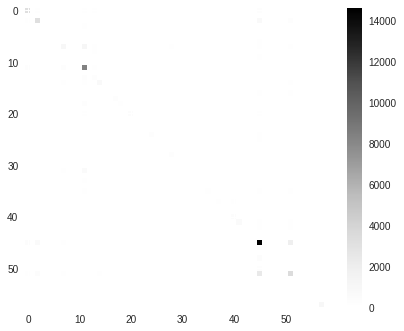

<Figure size 576x396 with 0 Axes>

In [84]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "other" and sd most commonly. 
# I think this is because they are some of the most common classes in the dataset.
# The 0% accuracy for bf was concerning so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly dark with a small number of bright dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")

Compared to the baseline using BiLSTM for utterance classification, the second method effectively leverage context information and achieve better performance. Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




## Advanced: Creating End-To-End Dialogue System

In the last section we want to create end-to-end dialogue system, following on from the seq2seq MT labs you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. In end-to-end dialogue systems, the encoder represents each utterance with a vector. The utterance vector is the hidden state after the last token of the utterance has been processed. The context LSTM keeps track of past utterances. The hidden state can be explained as the state of the dialogue system. The next utterance prediction is performed by a decoder LSTM, which takes the hidden state of the last LSTM and produces a probability distribution over the tokens in the next utterance. You can take the DA LSTM state of last section as input to a decoder which tries to generate the next utterance. You can add attention and monitor the performance. Instead of evaluating by an automatic evaluation method, you can show us some of the interesting predictions. 
